# Prophet

In [1]:
import numpy as np # linear algebra
import pandas as pd # dataframes, data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plots
# Tools from Scikit Learn library:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot
from prophet import Prophet
import itertools
#from pmdarima.arima import auto_arima
import statsmodels as stat
#!pip install -U statsmodels
sns.set()
# for min_max scaling

# for Box-Cox Transformation
from scipy import stats



## Importation de data

In [2]:
# Loading the training dataset as a Pandas DataFrame
df=pd.read_csv('ETG1.csv')
df

Unnamed: 0                       _id  RealP2  RealP3  RealP1  Vrms1  \
0                0  61d9cefbdd4ae07ecb861f64     8.5    25.8     3.2  260.3   
1                1  61d9cefbdd4ae07ecb861f68    12.4    23.7     7.6  260.5   
2                2  61d9cefbdd4ae07ecb861f6c     8.9    25.3     3.0  260.4   
3                3  61d9cefbdd4ae07ecb861f70    11.0    22.3     7.0  260.5   
4                4  61d9cefbdd4ae07ecb861f74    11.6    27.2     4.2  260.5   
...            ...                       ...     ...     ...     ...    ...   
862352      862352  62141bb4dd4ae07ecbbab1b4    12.0    28.2     6.6  259.3   
862353      862353  62141bb9dd4ae07ecbbab1b8     9.6    22.7     7.8  259.1   
862354      862354  62141bbedd4ae07ecbbab1bc    13.1    27.9     7.7  259.2   
862355      862355  62141bc3dd4ae07ecbbab1c0     7.6    24.4     8.4  259.1   
862356      862356  62141bc9dd4ae07ecbbab1c4    11.6    24.9   162.2  259.2   

        ETG                 date   index  Vrms2  Irms2  Irms3  Irms1  PowerF2  \
0         1  2022-01-01 00:00:02   59338  258.4  239.3  284.1  342.7    0.138   
1         1  2022-01-01 00:00:07   59339  258.3  240.5  272.0  332.6    0.200   
2         1  2022-01-01 00:00:13   59340  258.3  231.5  279.1  335.5    0.150   
3         1  2022-01-01 00:00:18   59341  258.3  238.4  272.7  343.8    0.179   
4         1  2022-01-01 00:00:23   59342  258.3  241.3  278.7  336.0    0.186   
...     ...                  ...     ...    ...    ...    ...    ...      ...   
862352    1  2022-02-22 00:09:40  921931  257.2  243.0  286.0  406.4    0.193   
862353    1  2022-02-22 00:09:45  921932  257.1  242.0  279.6  420.0    0.154   
862354    1  2022-02-22 00:09:50  921933  257.1  248.1  283.3  409.5    0.206   
862355    1  2022-02-22 00:09:55  921934  257.4  249.8  281.6  433.6    0.119   
862356    1  2022-02-22 00:10:01  921935  257.1  247.8  276.4  725.3    0.182   

        PowerF3  Vrms3  PowerF1  
0         0.350  260.2    0.036  
1         0.334  260.1    0.087  
2         0.348  260.2    0.034  
3         0.314  260.2    0.078  
4         0.375  260.3    0.048  
...         ...    ...      ...  
862352    0.380  259.0    0.063  
862353    0.313  258.8    0.072  
862354    0.380  258.9    0.072  
862355    0.335  258.7    0.074  
862356    0.348  258.7    0.863  

[862357 rows x 17 columns]

In [3]:
#transformer la colonne de type objet en type  date 
timefmt = "%Y-%m-%d %H:%M:%S" 
df['date'] = pd.to_datetime(df['date'], format = timefmt, errors='coerce')
df

Unnamed: 0                       _id  RealP2  RealP3  RealP1  Vrms1  \
0                0  61d9cefbdd4ae07ecb861f64     8.5    25.8     3.2  260.3   
1                1  61d9cefbdd4ae07ecb861f68    12.4    23.7     7.6  260.5   
2                2  61d9cefbdd4ae07ecb861f6c     8.9    25.3     3.0  260.4   
3                3  61d9cefbdd4ae07ecb861f70    11.0    22.3     7.0  260.5   
4                4  61d9cefbdd4ae07ecb861f74    11.6    27.2     4.2  260.5   
...            ...                       ...     ...     ...     ...    ...   
862352      862352  62141bb4dd4ae07ecbbab1b4    12.0    28.2     6.6  259.3   
862353      862353  62141bb9dd4ae07ecbbab1b8     9.6    22.7     7.8  259.1   
862354      862354  62141bbedd4ae07ecbbab1bc    13.1    27.9     7.7  259.2   
862355      862355  62141bc3dd4ae07ecbbab1c0     7.6    24.4     8.4  259.1   
862356      862356  62141bc9dd4ae07ecbbab1c4    11.6    24.9   162.2  259.2   

        ETG                date   index  Vrms2  Irms2  Irms3  Irms1  PowerF2  \
0         1 2022-01-01 00:00:02   59338  258.4  239.3  284.1  342.7    0.138   
1         1 2022-01-01 00:00:07   59339  258.3  240.5  272.0  332.6    0.200   
2         1 2022-01-01 00:00:13   59340  258.3  231.5  279.1  335.5    0.150   
3         1 2022-01-01 00:00:18   59341  258.3  238.4  272.7  343.8    0.179   
4         1 2022-01-01 00:00:23   59342  258.3  241.3  278.7  336.0    0.186   
...     ...                 ...     ...    ...    ...    ...    ...      ...   
862352    1 2022-02-22 00:09:40  921931  257.2  243.0  286.0  406.4    0.193   
862353    1 2022-02-22 00:09:45  921932  257.1  242.0  279.6  420.0    0.154   
862354    1 2022-02-22 00:09:50  921933  257.1  248.1  283.3  409.5    0.206   
862355    1 2022-02-22 00:09:55  921934  257.4  249.8  281.6  433.6    0.119   
862356    1 2022-02-22 00:10:01  921935  257.1  247.8  276.4  725.3    0.182   

        PowerF3  Vrms3  PowerF1  
0         0.350  260.2    0.036  
1         0.334  260.1    0.087  
2         0.348  260.2    0.034  
3         0.314  260.2    0.078  
4         0.375  260.3    0.048  
...         ...    ...      ...  
862352    0.380  259.0    0.063  
862353    0.313  258.8    0.072  
862354    0.380  258.9    0.072  
862355    0.335  258.7    0.074  
862356    0.348  258.7    0.863  

[862357 rows x 17 columns]

In [4]:
df = pd.read_csv('ETG1.csv', parse_dates = ['date'], index_col = ['date'])
df.head()

Unnamed: 0                       _id  RealP2  RealP3  \
date                                                                        
2022-01-01 00:00:02           0  61d9cefbdd4ae07ecb861f64     8.5    25.8   
2022-01-01 00:00:07           1  61d9cefbdd4ae07ecb861f68    12.4    23.7   
2022-01-01 00:00:13           2  61d9cefbdd4ae07ecb861f6c     8.9    25.3   
2022-01-01 00:00:18           3  61d9cefbdd4ae07ecb861f70    11.0    22.3   
2022-01-01 00:00:23           4  61d9cefbdd4ae07ecb861f74    11.6    27.2   

                     RealP1  Vrms1  ETG  index  Vrms2  Irms2  Irms3  Irms1  \
date                                                                         
2022-01-01 00:00:02     3.2  260.3    1  59338  258.4  239.3  284.1  342.7   
2022-01-01 00:00:07     7.6  260.5    1  59339  258.3  240.5  272.0  332.6   
2022-01-01 00:00:13     3.0  260.4    1  59340  258.3  231.5  279.1  335.5   
2022-01-01 00:00:18     7.0  260.5    1  59341  258.3  238.4  272.7  343.8   
2022-01-01 00:00:23     4.2  260.5    1  59342  258.3  241.3  278.7  336.0   

                     PowerF2  PowerF3  Vrms3  PowerF1  
date                                                   
2022-01-01 00:00:02    0.138    0.350  260.2    0.036  
2022-01-01 00:00:07    0.200    0.334  260.1    0.087  
2022-01-01 00:00:13    0.150    0.348  260.2    0.034  
2022-01-01 00:00:18    0.179    0.314  260.2    0.078  
2022-01-01 00:00:23    0.186    0.375  260.3    0.048

In [5]:
df['Rtot']=df['RealP1']+df['RealP2']+df['RealP3']

# Data processing

In [6]:
X_train, X_test, X_val= df[0:int(len(df)*0.60)], df[int(len(df)*0.60):int(len(df)*0.80)],df[int(len(df)*0.80):]


## Elimination des outliers

In [7]:
cols = ['Rtot'] # The columns you want to search for outliers in
#X_train=X_train['Irms1', 'PowerF1', 'RealP1']
# Calculate quantiles and IQR
Q1 = X_train[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = X_train[cols].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((X_train[cols] < (Q1 - 1.5 * IQR)) | (X_train[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_X = X_train[condition]

In [8]:
filtered_X

Unnamed: 0                       _id  RealP2  RealP3  \
date                                                                        
2022-01-01 00:00:02           0  61d9cefbdd4ae07ecb861f64     8.5    25.8   
2022-01-01 00:00:07           1  61d9cefbdd4ae07ecb861f68    12.4    23.7   
2022-01-01 00:00:13           2  61d9cefbdd4ae07ecb861f6c     8.9    25.3   
2022-01-01 00:00:18           3  61d9cefbdd4ae07ecb861f70    11.0    22.3   
2022-01-01 00:00:23           4  61d9cefbdd4ae07ecb861f74    11.6    27.2   
...                         ...                       ...     ...     ...   
2022-02-01 04:58:32      517409  61f8afe8dd4ae07ecba5a695    11.9    24.8   
2022-02-01 04:58:38      517410  61f8afeedd4ae07ecba5a699    11.1    26.8   
2022-02-01 04:58:43      517411  61f8aff3dd4ae07ecba5a69d     8.5    23.5   
2022-02-01 04:58:48      517412  61f8aff8dd4ae07ecba5a6a1    13.3    25.1   
2022-02-01 04:58:53      517413  61f8affddd4ae07ecba5a6a5     8.8    26.0   

                     RealP1  Vrms1  ETG   index  Vrms2  Irms2  Irms3  Irms1  \
date                                                                          
2022-01-01 00:00:02     3.2  260.3    1   59338  258.4  239.3  284.1  342.7   
2022-01-01 00:00:07     7.6  260.5    1   59339  258.3  240.5  272.0  332.6   
2022-01-01 00:00:13     3.0  260.4    1   59340  258.3  231.5  279.1  335.5   
2022-01-01 00:00:18     7.0  260.5    1   59341  258.3  238.4  272.7  343.8   
2022-01-01 00:00:23     4.2  260.5    1   59342  258.3  241.3  278.7  336.0   
...                     ...    ...  ...     ...    ...    ...    ...    ...   
2022-02-01 04:58:32    10.7  259.3    1  576948  257.4  272.3  300.8  382.9   
2022-02-01 04:58:38     7.4  259.3    1  576949  257.4  245.3  287.1  390.9   
2022-02-01 04:58:43     8.3  258.9    1  576950  257.4  246.1  284.3  397.5   
2022-02-01 04:58:48     9.4  259.0    1  576951  257.2  242.5  285.3  386.2   
2022-02-01 04:58:53     6.7  258.6    1  576952  257.2  242.1  283.9  388.0   

                     PowerF2  PowerF3  Vrms3  PowerF1  Rtot  
date                                                         
2022-01-01 00:00:02    0.138    0.350  260.2    0.036  37.5  
2022-01-01 00:00:07    0.200    0.334  260.1    0.087  43.7  
2022-01-01 00:00:13    0.150    0.348  260.2    0.034  37.2  
2022-01-01 00:00:18    0.179    0.314  260.2    0.078  40.3  
2022-01-01 00:00:23    0.186    0.375  260.3    0.048  43.0  
...                      ...      ...    ...      ...   ...  
2022-02-01 04:58:32    0.169    0.318  259.1    0.108  47.4  
2022-02-01 04:58:38    0.176    0.359  259.3    0.073  45.3  
2022-02-01 04:58:43    0.135    0.319  259.1    0.081  40.3  
2022-02-01 04:58:48    0.213    0.340  259.0    0.094  47.8  
2022-02-01 04:58:53    0.141    0.354  258.9    0.067  41.5  

[436628 rows x 17 columns]

## Scaling

In [9]:
x=filtered_X['Rtot']
x=pd.DataFrame(x)
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
sc.fit(x)

MinMaxScaler()

In [10]:
feature_scale=[feature for feature in filtered_X.columns if feature not in ['_id','ETG','index']]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(filtered_X[feature_scale])

MinMaxScaler()

In [11]:
scaler.data_max_

array([5.17413e+05, 5.71000e+02, 5.25600e+02, 5.67900e+02, 2.63100e+02,
       2.61500e+02, 4.84920e+03, 6.56500e+03, 6.58880e+03, 7.31000e-01,
       6.06000e-01, 2.63000e+02, 9.65000e-01, 5.97300e+02])

In [12]:
scaler.transform(filtered_X[feature_scale])

array([[0.00000000e+00, 1.43683196e-02, 4.90867580e-02, ...,
        8.27160494e-01, 3.73056995e-02, 3.26594090e-02],
       [1.93269207e-06, 2.12020326e-02, 4.50913242e-02, ...,
        8.20987654e-01, 9.01554404e-02, 4.33730776e-02],
       [3.86538413e-06, 1.50692132e-02, 4.81354642e-02, ...,
        8.27160494e-01, 3.52331606e-02, 3.21410057e-02],
       ...,
       [9.99996135e-01, 1.43683196e-02, 4.47108067e-02, ...,
        7.59259259e-01, 8.39378238e-02, 3.74978400e-02],
       [9.99998067e-01, 2.27790433e-02, 4.77549467e-02, ...,
        7.53086420e-01, 9.74093264e-02, 5.04579229e-02],
       [1.00000000e+00, 1.48939898e-02, 4.94672755e-02, ...,
        7.46913580e-01, 6.94300518e-02, 3.95714533e-02]])

In [13]:
# transform the train , and add on the Id 
data = pd.concat([filtered_X[['_id','index']].reset_index(drop=False),
                    pd.DataFrame(scaler.transform(filtered_X[feature_scale]), columns=feature_scale)],
                    axis=1)
data.set_index(data['index'])


date                       _id   index  Unnamed: 0  \
index                                                                      
59338  2022-01-01 00:00:02  61d9cefbdd4ae07ecb861f64   59338    0.000000   
59339  2022-01-01 00:00:07  61d9cefbdd4ae07ecb861f68   59339    0.000002   
59340  2022-01-01 00:00:13  61d9cefbdd4ae07ecb861f6c   59340    0.000004   
59341  2022-01-01 00:00:18  61d9cefbdd4ae07ecb861f70   59341    0.000006   
59342  2022-01-01 00:00:23  61d9cefbdd4ae07ecb861f74   59342    0.000008   
...                    ...                       ...     ...         ...   
576948 2022-02-01 04:58:32  61f8afe8dd4ae07ecba5a695  576948    0.999992   
576949 2022-02-01 04:58:38  61f8afeedd4ae07ecba5a699  576949    0.999994   
576950 2022-02-01 04:58:43  61f8aff3dd4ae07ecba5a69d  576950    0.999996   
576951 2022-02-01 04:58:48  61f8aff8dd4ae07ecba5a6a1  576951    0.999998   
576952 2022-02-01 04:58:53  61f8affddd4ae07ecba5a6a5  576952    1.000000   

          RealP2    RealP3    RealP1     Vrms1  Vrms2     Irms2     Irms3  \
index                                                                       
59338   0.014368  0.049087  0.005635  0.772358  0.752  0.004234  0.004533   
59339   0.021202  0.045091  0.013383  0.788618  0.744  0.004493  0.002615   
59340   0.015069  0.048135  0.005283  0.780488  0.744  0.002549  0.003740   
59341   0.018749  0.042428  0.012326  0.788618  0.744  0.004039  0.002726   
59342   0.019800  0.051750  0.007396  0.788618  0.744  0.004666  0.003677   
...          ...       ...       ...       ...    ...       ...       ...   
576948  0.020326  0.047184  0.018841  0.691057  0.672  0.011362  0.007180   
576949  0.018924  0.050989  0.013030  0.691057  0.672  0.005530  0.005008   
576950  0.014368  0.044711  0.014615  0.658537  0.672  0.005703  0.004565   
576951  0.022779  0.047755  0.016552  0.666667  0.656  0.004925  0.004723   
576952  0.014894  0.049467  0.011798  0.634146  0.656  0.004839  0.004501   

           Irms1   PowerF2   PowerF3     Vrms3   PowerF1      Rtot  
index                                                               
59338   0.004383  0.187671  0.577558  0.827160  0.037306  0.032659  
59339   0.002774  0.272603  0.551155  0.820988  0.090155  0.043373  
59340   0.003236  0.204110  0.574257  0.827160  0.035233  0.032141  
59341   0.004559  0.243836  0.518152  0.827160  0.080829  0.037498  
59342   0.003315  0.253425  0.618812  0.833333  0.049741  0.042163  
...          ...       ...       ...       ...       ...       ...  
576948  0.010791  0.230137  0.524752  0.759259  0.111917  0.049767  
576949  0.012066  0.239726  0.592409  0.771605  0.075648  0.046138  
576950  0.013118  0.183562  0.526403  0.759259  0.083938  0.037498  
576951  0.011317  0.290411  0.561056  0.753086  0.097409  0.050458  
576952  0.011604  0.191781  0.584158  0.746914  0.069430  0.039571  

[436628 rows x 17 columns]

In [14]:
# transform the test , and add on the Id 
datatest = pd.concat([X_test[['_id','index']].reset_index(drop=False),
                    pd.DataFrame(scaler.transform(X_test[feature_scale]), columns=feature_scale)],
                    axis=1)
datatest.set_index(datatest['index'])


date                       _id   index  Unnamed: 0  \
index                                                                      
576953 2022-02-01 04:58:58  61f8b002dd4ae07ecba5a6a9  576953    1.000002   
576954 2022-02-01 04:59:04  61f8b008dd4ae07ecba5a6ad  576954    1.000004   
576955 2022-02-01 04:59:09  61f8b00ddd4ae07ecba5a6b1  576955    1.000006   
576956 2022-02-01 04:59:14  61f8b012dd4ae07ecba5a6b5  576956    1.000008   
576957 2022-02-01 04:59:19  61f8b017dd4ae07ecba5a6b9  576957    1.000010   
...                    ...                       ...     ...         ...   
749419 2022-02-11 14:32:21  62066565dd4ae07ecbb02aea  749419    1.333326   
749420 2022-02-11 14:32:26  6206656add4ae07ecbb02aee  749420    1.333328   
749421 2022-02-11 14:32:31  6206656fdd4ae07ecbb02af2  749421    1.333329   
749422 2022-02-11 14:32:36  62066574dd4ae07ecbb02af6  749422    1.333331   
749423 2022-02-11 14:32:41  62066579dd4ae07ecbb02afa  749423    1.333333   

          RealP2    RealP3    RealP1     Vrms1  Vrms2     Irms2     Irms3  \
index                                                                       
576953  0.020676  0.046613  0.020778  0.658537  0.656  0.006243  0.003534   
576954  0.017873  0.053843  0.010037  0.658537  0.656  0.005292  0.004533   
576955  0.015069  0.043569  0.017433  0.658537  0.664  0.003521  0.003772   
576956  0.022429  0.053653  0.016904  0.650407  0.656  0.006675  0.003978   
576957  0.012791  0.045852  0.014263  0.658537  0.664  0.005789  0.004311   
...          ...       ...       ...       ...    ...       ...       ...   
749419  0.015770  0.041476  0.112520  0.439024  0.488  0.003953  0.003677   
749420  0.019800  0.055365  0.100018  0.463415  0.504  0.006523  0.005135   
749421  0.016296  0.042618  0.122205  0.455285  0.512  0.006804  0.004152   
749422  0.018574  0.052702  0.119387  0.463415  0.520  0.006351  0.005357   
749423  0.018749  0.045662  0.123437  0.463415  0.520  0.004601  0.002457   

           Irms1   PowerF2   PowerF3     Vrms3   PowerF1      Rtot  
index                                                               
576953  0.012895  0.258904  0.562706  0.740741  0.119171  0.051495  
576954  0.011206  0.228767  0.633663  0.765432  0.060104  0.044755  
576955  0.013469  0.200000  0.523102  0.746914  0.099482  0.039917  
576956  0.011333  0.278082  0.641914  0.753086  0.099482  0.055815  
576957  0.012752  0.163014  0.542904  0.746914  0.081865  0.036634  
...          ...       ...       ...       ...       ...       ...  
749419  0.066055  0.209589  0.501650  0.641975  0.354404  0.132020  
749420  0.060635  0.247945  0.646865  0.660494  0.330570  0.136340  
749421  0.070422  0.202740  0.509901  0.660494  0.370984  0.143079  
749422  0.070677  0.234247  0.613861  0.660494  0.360622  0.151719  
749423  0.070948  0.243836  0.567657  0.660494  0.373057  0.149473  

[172471 rows x 17 columns]

In [15]:
# transform the validation , and add on the Id 
dataval = pd.concat([X_val[['_id','index']].reset_index(drop=False),
                    pd.DataFrame(scaler.transform(X_val[feature_scale]), columns=feature_scale)],
                    axis=1)
dataval.set_index(dataval['index'])


date                       _id   index  Unnamed: 0  \
index                                                                      
749424 2022-02-11 14:32:47  6206657fdd4ae07ecbb02afe  749424    1.333335   
749425 2022-02-11 14:32:52  62066584dd4ae07ecbb02b02  749425    1.333337   
749426 2022-02-11 14:32:57  62066589dd4ae07ecbb02b06  749426    1.333339   
749427 2022-02-11 14:33:02  6206658edd4ae07ecbb02b0a  749427    1.333341   
749428 2022-02-11 14:33:07  62066594dd4ae07ecbb02b0e  749428    1.333343   
...                    ...                       ...     ...         ...   
921931 2022-02-22 00:09:40  62141bb4dd4ae07ecbbab1b4  921931    1.666661   
921932 2022-02-22 00:09:45  62141bb9dd4ae07ecbbab1b8  921932    1.666663   
921933 2022-02-22 00:09:50  62141bbedd4ae07ecbbab1bc  921933    1.666665   
921934 2022-02-22 00:09:55  62141bc3dd4ae07ecbbab1c0  921934    1.666667   
921935 2022-02-22 00:10:01  62141bc9dd4ae07ecbbab1c4  921935    1.666669   

          RealP2    RealP3    RealP1     Vrms1  Vrms2     Irms2     Irms3  \
index                                                                       
749424  0.017347  0.050038  0.118683  0.447154  0.512  0.004039  0.005341   
749425  0.020676  0.044901  0.100898  0.463415  0.520  0.005595  0.003725   
749426  0.015595  0.047184  0.090861  0.455285  0.504  0.003715  0.005706   
749427  0.022253  0.048706  0.103715  0.455285  0.512  0.005767  0.003661   
749428  0.014719  0.046423  0.101074  0.455285  0.520  0.005271  0.005103   
...          ...       ...       ...       ...    ...       ...       ...   
921931  0.020501  0.053653  0.011622  0.691057  0.656  0.005033  0.004834   
921932  0.016296  0.043189  0.013735  0.674797  0.648  0.004817  0.003820   
921933  0.022429  0.053082  0.013559  0.682927  0.648  0.006135  0.004406   
921934  0.012791  0.046423  0.014791  0.674797  0.672  0.006502  0.004137   
921935  0.019800  0.047374  0.285614  0.682927  0.648  0.006070  0.003312   

           Irms1   PowerF2   PowerF3     Vrms3   PowerF1      Rtot  
index                                                               
749424  0.070103  0.227397  0.582508  0.660494  0.360622  0.147399  
749425  0.058292  0.261644  0.541254  0.666667  0.339896  0.128564  
749426  0.058659  0.206849  0.544554  0.666667  0.305699  0.115777  
749427  0.059296  0.282192  0.587459  0.660494  0.346114  0.136340  
749428  0.061161  0.190411  0.542904  0.660494  0.331606  0.124244  
...          ...       ...       ...       ...       ...       ...  
921931  0.014537  0.263014  0.627063  0.753086  0.065285  0.048730  
921932  0.016705  0.209589  0.516502  0.740741  0.074611  0.037152  
921933  0.015031  0.280822  0.627063  0.746914  0.074611  0.052013  
921934  0.018873  0.161644  0.552805  0.734568  0.076684  0.037671  
921935  0.065369  0.247945  0.574257  0.734568  0.894301  0.311215  

[172472 rows x 17 columns]

In [16]:
X_train1=data[['date', 'Rtot']].rename(columns={"date": "ds", "Rtot": "y"})


## Modèle

In its essence, this library utilizes the additive regression model  y(t)  comprising the following components:

y(t)=g(t)+s(t)+h(t)+ϵt,
 
where:

*   Trend  g(t)  models non-periodic changes.
*   Seasonality  s(t)  represents periodic changes
*   Holidays component  h(t)  contributes information about holidays and events.


### Tuning

In [17]:
param_grid = {  
    # tuning those parameters can potentially improve the performance of our model
    'changepoint_prior_scale': [0.001, 0.1],
    #'seasonality_prior_scale': [0.01, 1.0],
    #'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

# Quick peek at what our combinations look like
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}]

In [18]:
for params in all_params:
    m = Prophet(**params).fit(X_train1)
    df_cv = cross_validation(m, initial = '10 days', period = '30 days', horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

21:36:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
21:39:59 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:58:30 - cmdstanpy - INFO - Chain [1] start processing
22:06:53 - cmdstanpy - INFO - Chain [1] done processing


   changepoint_prior_scale seasonality_mode      rmse
0                    0.001         additive  0.181016
1                    0.001   multiplicative  0.414451
2                    0.100         additive  0.351043
3                    0.100   multiplicative  0.244819
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'}


In [19]:
X_train, X_test = train_test_split(X_train1, test_size=0.25, random_state=40)


In [20]:
m = Prophet(changepoint_prior_scale= 0.001, seasonality_mode= 'additive')
m.fit(X_train)

22:13:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:19 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
forecast=m.predict(X_train)

In [22]:
# evaluate forecasts
from math import sqrt
rmse = sqrt(mean_squared_error(X_train['y'], forecast['yhat']))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 0.248


In [23]:
forecast=m.predict(X_test)

In [24]:
rmse = sqrt(mean_squared_error(X_test['y'], forecast['yhat']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.248


In [25]:
Xtest=datatest[['date', 'Rtot']].rename(columns={"date": "ds", "Rtot": "y"})

In [26]:
forecasttest = m.predict(Xtest)


In [27]:
forecasttest

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0      2022-02-01 04:58:58  0.218580   -0.099718    0.335808     0.218580   
1      2022-02-01 04:59:04  0.218580   -0.106638    0.337308     0.218580   
2      2022-02-01 04:59:09  0.218580   -0.115880    0.325430     0.218580   
3      2022-02-01 04:59:14  0.218580   -0.116556    0.345658     0.218580   
4      2022-02-01 04:59:19  0.218580   -0.104928    0.332692     0.218580   
...                    ...       ...         ...         ...          ...   
172466 2022-02-11 14:32:21  0.210529    0.035337    0.468776     0.197969   
172467 2022-02-11 14:32:26  0.210529    0.026115    0.476463     0.197968   
172468 2022-02-11 14:32:31  0.210529    0.033557    0.469359     0.197968   
172469 2022-02-11 14:32:36  0.210529    0.030402    0.458430     0.197968   
172470 2022-02-11 14:32:41  0.210529    0.034346    0.481531     0.197968   

        trend_upper  additive_terms  additive_terms_lower  \
0          0.218580       -0.105873             -0.105873   
1          0.218580       -0.105836             -0.105836   
2          0.218580       -0.105804             -0.105804   
3          0.218580       -0.105773             -0.105773   
4          0.218580       -0.105741             -0.105741   
...             ...             ...                   ...   
172466     0.224355        0.045070              0.045070   
172467     0.224356        0.045131              0.045131   
172468     0.224356        0.045192              0.045192   
172469     0.224356        0.045253              0.045253   
172470     0.224356        0.045314              0.045314   

        additive_terms_upper     daily  daily_lower  daily_upper    weekly  \
0                  -0.105873 -0.153172    -0.153172    -0.153172  0.047299   
1                  -0.105836 -0.153136    -0.153136    -0.153136  0.047300   
2                  -0.105804 -0.153106    -0.153106    -0.153106  0.047301   
3                  -0.105773 -0.153075    -0.153075    -0.153075  0.047302   
4                  -0.105741 -0.153044    -0.153044    -0.153044  0.047303   
...                      ...       ...          ...          ...       ...   
172466              0.045070  0.028011     0.028011     0.028011  0.017059   
172467              0.045131  0.028074     0.028074     0.028074  0.017057   
172468              0.045192  0.028138     0.028138     0.028138  0.017054   
172469              0.045253  0.028201     0.028201     0.028201  0.017052   
172470              0.045314  0.028265     0.028265     0.028265  0.017049   

        weekly_lower  weekly_upper  multiplicative_terms  \
0           0.047299      0.047299                   0.0   
1           0.047300      0.047300                   0.0   
2           0.047301      0.047301                   0.0   
3           0.047302      0.047302                   0.0   
4           0.047303      0.047303                   0.0   
...              ...           ...                   ...   
172466      0.017059      0.017059                   0.0   
172467      0.017057      0.017057                   0.0   
172468      0.017054      0.017054                   0.0   
172469      0.017052      0.017052                   0.0   
172470      0.017049      0.017049                   0.0   

        multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                              0.0                         0.0  0.112707  
1                              0.0                         0.0  0.112745  
2                              0.0                         0.0  0.112776  
3                              0.0                         0.0  0.112807  
4                              0.0                         0.0  0.112839  
...                            ...                         ...       ...  
172466                         0.0                         0.0  0.255600  
172467                         0.0                         0.0  0.255660  
172468                         0.

In [28]:
rmse = sqrt(mean_squared_error(Xtest['y'], forecasttest['yhat']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.866


In [29]:
Xtest=Xtest['y']
Xtest=Xtest.values.reshape(-1,1)
Xtest= sc.inverse_transform(Xtest)

In [30]:
yhat=forecasttest['yhat']
yhat=yhat.values.reshape(-1,1)
yhat= sc.inverse_transform(yhat)

In [31]:
n=0
for i in range (len (Xtest)):
    if np.abs(yhat[i]-Xtest[i])>100:
        n=n+1
        print(Xtest[i],'Surconsommation')
    else:
        print(Xtest[i],'normal')
print(n)

[48.4] normal
[44.5] normal
[41.7] normal
[50.9] normal
[39.8] normal
[49.5] normal
[40.4] normal
[47.3] normal
[39.4] normal
[48.7] normal
[41.2] normal
[45.6] normal
[41.1] normal
[47.4] normal
[42.3] normal
[46.1] normal
[47.8] normal
[39.5] normal
[49.6] normal
[44.9] normal
[40.6] normal
[51.] normal
[39.9] normal
[48.1] normal
[40.8] normal
[45.5] normal
[45.5] normal
[42.4] normal
[49.1] normal
[41.3] normal
[48.] normal
[45.8] normal
[42.7] normal
[51.2] normal
[40.7] normal
[47.6] normal
[43.1] normal
[42.5] normal
[46.7] normal
[39.7] normal
[47.2] normal
[39.9] normal
[51.4] normal
[41.4] normal
[50.1] normal
[38.8] normal
[49.3] normal
[40.2] normal
[49.4] normal
[40.8] normal
[48.] normal
[40.2] normal
[47.6] normal
[39.1] normal
[48.1] normal
[43.5] normal
[42.2] normal
[49.5] normal
[40.9] normal
[44.9] normal
[47.3] normal
[38.9] normal
[49.1] normal
[45.] normal
[37.1] normal
[49.5] normal
[44.3] normal
[42.] normal
[49.8] normal
[41.2] normal
[44.5] normal
[48.9] norm

[155.4] normal
[148.4] normal
[159.1] normal
[150.6] normal
[155.8] normal
[154.3] normal
[151.] normal
[156.5] normal
[148.5] normal
[161.] normal
[151.7] normal
[153.1] normal
[157.8] normal
[149.] normal
[155.1] normal
[154.2] normal
[149.8] normal
[160.6] normal
[148.5] normal
[157.2] normal
[149.6] normal
[156.7] normal
[154.5] normal
[157.8] normal
[152.5] normal
[157.2] normal
[152.8] normal
[159.9] normal
[154.5] normal
[159.9] normal
[153.8] normal
[159.5] normal
[156.1] normal
[162.3] normal
[155.4] normal
[162.8] normal
[153.1] normal
[157.7] normal
[159.6] normal
[153.4] normal
[156.5] normal
[158.9] normal
[150.7] normal
[159.4] normal
[156.9] normal
[157.2] normal
[161.8] normal
[151.4] normal
[159.5] normal
[150.7] normal
[156.] normal
[152.] normal
[157.6] normal
[160.5] normal
[154.8] normal
[163.8] normal
[153.7] normal
[160.7] normal
[160.] normal
[155.3] normal
[163.9] normal
[153.5] normal
[160.8] normal
[160.8] normal
[155.2] normal
[161.8] normal
[153.2] normal
[

[372.2] Surconsommation
[2008.6] Surconsommation
[2009.6] Surconsommation
[1988.4] Surconsommation
[1994.2] Surconsommation
[1986.4] Surconsommation
[1989.9] Surconsommation
[1990.8] Surconsommation
[1990.2] Surconsommation
[1978.2] Surconsommation
[1985.6] Surconsommation
[1991.6] Surconsommation
[1979.1] Surconsommation
[1982.3] Surconsommation
[1991.3] Surconsommation
[1979.1] Surconsommation
[1985.2] Surconsommation
[1992.] Surconsommation
[1989.5] Surconsommation
[1988.9] Surconsommation
[1989.] Surconsommation
[1980.6] Surconsommation
[1993.5] Surconsommation
[1978.8] Surconsommation
[1991.7] Surconsommation
[1980.] Surconsommation
[1987.2] Surconsommation
[1981.3] Surconsommation
[1988.] Surconsommation
[1984.] Surconsommation
[1984.1] Surconsommation
[1984.8] Surconsommation
[1985.9] Surconsommation
[1987.] Surconsommation
[1988.4] Surconsommation
[1978.1] Surconsommation
[1986.3] Surconsommation
[1976.7] Surconsommation
[1994.4] Surconsommation
[1981.2] Surconsommation
[1989.1

[1700.9] Surconsommation
[1700.9] Surconsommation
[1705.6] Surconsommation
[1711.8] Surconsommation
[1716.7] Surconsommation
[1728.8] Surconsommation
[1708.2] Surconsommation
[1710.5] Surconsommation
[1714.9] Surconsommation
[1714.6] Surconsommation
[1707.5] Surconsommation
[1694.3] Surconsommation
[1701.2] Surconsommation
[1703.2] Surconsommation
[1938.9] Surconsommation
[2050.2] Surconsommation
[2056.1] Surconsommation
[2052.8] Surconsommation
[2051.6] Surconsommation
[2033.8] Surconsommation
[419.7] Surconsommation
[416.3] Surconsommation
[423.3] Surconsommation
[422.6] Surconsommation
[429.2] Surconsommation
[420.1] Surconsommation
[422.1] Surconsommation
[414.7] Surconsommation
[420.9] Surconsommation
[417.9] Surconsommation
[416.6] Surconsommation
[416.] Surconsommation
[417.] Surconsommation
[417.3] Surconsommation
[422.7] Surconsommation
[405.2] Surconsommation
[426.6] Surconsommation
[426.3] Surconsommation
[418.8] Surconsommation
[415.9] Surconsommation
[405.3] Surconsommatio

[75.3] Surconsommation
[74.4] Surconsommation
[70.1] Surconsommation
[76.6] Surconsommation
[77.8] Surconsommation
[69.6] Surconsommation
[74.6] Surconsommation
[80.] Surconsommation
[69.2] Surconsommation
[87.6] Surconsommation
[68.2] Surconsommation
[72.1] Surconsommation
[84.5] Surconsommation
[77.3] Surconsommation
[78.] Surconsommation
[93.4] Surconsommation
[77.5] Surconsommation
[85.8] Surconsommation
[78.] Surconsommation
[83.3] Surconsommation
[77.1] Surconsommation
[89.6] Surconsommation
[76.3] Surconsommation
[83.6] Surconsommation
[73.] Surconsommation
[404.7] normal
[430.2] Surconsommation
[416.1] Surconsommation
[411.2] Surconsommation
[410.2] Surconsommation
[411.2] Surconsommation
[409.1] normal
[418.6] Surconsommation
[399.7] normal
[413.2] Surconsommation
[410.1] Surconsommation
[410.2] Surconsommation
[415.3] Surconsommation
[409.4] Surconsommation
[411.7] Surconsommation
[416.] Surconsommation
[412.] Surconsommation
[416.8] Surconsommation
[410.6] Surconsommation
[4

[406.9] Surconsommation
[420.4] Surconsommation
[422.1] Surconsommation
[415.9] Surconsommation
[426.7] Surconsommation
[411.1] Surconsommation
[419.9] Surconsommation
[410.3] Surconsommation
[425.7] Surconsommation
[425.1] Surconsommation
[430.3] Surconsommation
[425.3] Surconsommation
[426.8] Surconsommation
[431.1] Surconsommation
[420.] Surconsommation
[423.9] Surconsommation
[420.7] Surconsommation
[427.6] Surconsommation
[421.8] Surconsommation
[427.] Surconsommation
[425.9] Surconsommation
[424.3] Surconsommation
[427.7] Surconsommation
[426.3] Surconsommation
[424.1] Surconsommation
[431.2] Surconsommation
[422.4] Surconsommation
[428.8] Surconsommation
[426.6] Surconsommation
[424.2] Surconsommation
[430.6] Surconsommation
[430.3] Surconsommation
[430.6] Surconsommation
[433.6] Surconsommation
[419.6] Surconsommation
[433.5] Surconsommation
[434.1] Surconsommation
[424.9] Surconsommation
[435.6] Surconsommation
[440.8] Surconsommation
[432.3] Surconsommation
[447.5] Surconsomm

[369.1] normal
[376.2] Surconsommation
[390.] Surconsommation
[410.] Surconsommation
[433.8] Surconsommation
[420.3] Surconsommation
[430.9] Surconsommation
[420.3] Surconsommation
[429.2] Surconsommation
[423.] Surconsommation
[428.9] Surconsommation
[423.1] Surconsommation
[436.5] Surconsommation
[425.] Surconsommation
[440.3] Surconsommation
[437.1] Surconsommation
[432.4] Surconsommation
[446.8] Surconsommation
[442.9] Surconsommation
[435.4] Surconsommation
[448.9] Surconsommation
[436.2] Surconsommation
[416.7] Surconsommation
[418.4] Surconsommation
[400.6] Surconsommation
[404.3] Surconsommation
[392.4] Surconsommation
[393.5] Surconsommation
[380.6] Surconsommation
[400.8] Surconsommation
[410.] Surconsommation
[412.6] Surconsommation
[433.3] Surconsommation
[434.2] Surconsommation
[431.] Surconsommation
[445.2] Surconsommation
[424.5] Surconsommation
[428.] Surconsommation
[440.1] Surconsommation
[428.4] Surconsommation
[436.2] Surconsommation
[428.8] Surconsommation
[440.8] 

[573.] Surconsommation
[559.1] Surconsommation
[563.] Surconsommation
[566.7] Surconsommation
[535.6] Surconsommation
[542.7] Surconsommation
[526.7] Surconsommation
[536.5] Surconsommation
[524.] Surconsommation
[500.2] Surconsommation
[502.7] Surconsommation
[497.3] Surconsommation
[512.4] Surconsommation
[540.4] Surconsommation
[544.8] Surconsommation
[549.5] Surconsommation
[556.8] Surconsommation
[548.] Surconsommation
[560.4] Surconsommation
[561.7] Surconsommation
[563.3] Surconsommation
[567.6] Surconsommation
[549.7] Surconsommation
[567.6] Surconsommation
[557.2] Surconsommation
[551.] Surconsommation
[569.3] Surconsommation
[552.8] Surconsommation
[561.8] Surconsommation
[558.8] Surconsommation
[542.4] Surconsommation
[541.4] Surconsommation
[529.4] Surconsommation
[514.9] Surconsommation
[509.9] Surconsommation
[509.6] Surconsommation
[494.2] Surconsommation
[511.8] Surconsommation
[521.9] Surconsommation
[523.2] Surconsommation
[554.1] Surconsommation
[548.7] Surconsommati

[438.4] Surconsommation
[450.3] Surconsommation
[441.2] Surconsommation
[446.5] Surconsommation
[441.3] Surconsommation
[445.1] Surconsommation
[419.9] Surconsommation
[417.5] Surconsommation
[394.3] Surconsommation
[414.4] Surconsommation
[388.7] Surconsommation
[394.5] Surconsommation
[382.2] Surconsommation
[409.7] Surconsommation
[418.5] Surconsommation
[430.4] Surconsommation
[429.] Surconsommation
[437.3] Surconsommation
[442.2] Surconsommation
[450.] Surconsommation
[448.3] Surconsommation
[443.1] Surconsommation
[454.1] Surconsommation
[456.9] Surconsommation
[448.] Surconsommation
[452.7] Surconsommation
[469.5] Surconsommation
[467.4] Surconsommation
[458.1] Surconsommation
[437.2] Surconsommation
[434.3] Surconsommation
[417.] Surconsommation
[412.1] Surconsommation
[414.7] Surconsommation
[403.5] Surconsommation
[399.8] Surconsommation
[413.9] Surconsommation
[421.9] Surconsommation
[449.5] Surconsommation
[439.6] Surconsommation
[439.8] Surconsommation
[441.7] Surconsommat

[455.1] Surconsommation
[443.4] Surconsommation
[426.1] Surconsommation
[413.8] Surconsommation
[410.6] Surconsommation
[407.9] Surconsommation
[398.3] Surconsommation
[398.2] Surconsommation
[386.5] Surconsommation
[409.2] Surconsommation
[431.8] Surconsommation
[426.5] Surconsommation
[438.3] Surconsommation
[441.6] Surconsommation
[437.7] Surconsommation
[450.] Surconsommation
[441.1] Surconsommation
[450.2] Surconsommation
[444.5] Surconsommation
[449.8] Surconsommation
[444.7] Surconsommation
[449.9] Surconsommation
[452.8] Surconsommation
[447.4] Surconsommation
[426.6] Surconsommation
[415.3] Surconsommation
[411.2] Surconsommation
[403.4] Surconsommation
[401.8] Surconsommation
[388.6] Surconsommation
[391.8] Surconsommation
[386.3] Surconsommation
[412.7] Surconsommation
[431.5] Surconsommation
[432.2] Surconsommation
[446.8] Surconsommation
[437.9] Surconsommation
[448.6] Surconsommation
[447.2] Surconsommation
[448.1] Surconsommation
[453.4] Surconsommation
[443.] Surconsomm

[711.3] Surconsommation
[713.5] Surconsommation
[717.6] Surconsommation
[718.1] Surconsommation
[709.] Surconsommation
[717.4] Surconsommation
[724.6] Surconsommation
[714.9] Surconsommation
[729.9] Surconsommation
[736.2] Surconsommation
[727.3] Surconsommation
[745.8] Surconsommation
[756.1] Surconsommation
[750.4] Surconsommation
[752.3] Surconsommation
[747.5] Surconsommation
[762.9] Surconsommation
[757.9] Surconsommation
[750.6] Surconsommation
[764.9] Surconsommation
[764.4] Surconsommation
[762.8] Surconsommation
[770.] Surconsommation
[774.5] Surconsommation
[2470.] Surconsommation
[2446.5] Surconsommation
[2425.1] Surconsommation
[2428.6] Surconsommation
[2424.4] Surconsommation
[2416.1] Surconsommation
[2425.6] Surconsommation
[2437.8] Surconsommation
[2429.1] Surconsommation
[2443.9] Surconsommation
[2443.2] Surconsommation
[2462.7] Surconsommation
[2455.8] Surconsommation
[2456.9] Surconsommation
[2468.6] Surconsommation
[2478.7] Surconsommation
[2463.3] Surconsommation
[2

[306.] normal
[313.6] normal
[307.9] normal
[314.7] normal
[306.3] normal
[312.6] normal
[309.4] normal
[311.] normal
[305.9] normal
[295.6] normal
[308.2] normal
[302.3] normal
[303.6] normal
[311.7] normal
[302.4] normal
[311.9] normal
[308.3] normal
[303.5] normal
[312.8] normal
[302.8] normal
[303.4] normal
[310.6] normal
[313.3] normal
[308.8] normal
[310.9] normal
[315.6] normal
[308.3] normal
[314.1] normal
[314.1] normal
[311.2] normal
[314.9] normal
[307.2] normal
[309.1] normal
[316.5] normal
[307.5] normal
[310.6] normal
[310.1] normal
[313.5] normal
[308.8] normal
[316.] normal
[309.8] normal
[318.3] Surconsommation
[305.7] normal
[321.6] Surconsommation
[321.3] Surconsommation
[318.5] Surconsommation
[321.5] Surconsommation
[318.1] Surconsommation
[322.9] Surconsommation
[323.3] Surconsommation
[314.8] normal
[323.8] Surconsommation
[321.7] Surconsommation
[322.4] Surconsommation
[321.2] Surconsommation
[323.1] Surconsommation
[313.] normal
[326.8] Surconsommation
[321.2] 

[104.9] Surconsommation
[94.7] Surconsommation
[97.3] Surconsommation
[99.2] Surconsommation
[94.3] Surconsommation
[98.1] Surconsommation
[97.9] Surconsommation
[96.5] Surconsommation
[101.5] Surconsommation
[91.4] Surconsommation
[102.6] Surconsommation
[92.8] Surconsommation
[94.6] Surconsommation
[99.3] Surconsommation
[93.3] Surconsommation
[95.6] Surconsommation
[98.1] Surconsommation
[91.8] Surconsommation
[108.] Surconsommation
[96.2] Surconsommation
[91.4] Surconsommation
[100.5] Surconsommation
[97.2] Surconsommation
[97.2] Surconsommation
[99.9] Surconsommation
[88.9] Surconsommation
[94.7] Surconsommation
[85.9] Surconsommation
[92.7] Surconsommation
[97.3] Surconsommation
[89.8] Surconsommation
[98.8] Surconsommation
[56.2] Surconsommation
[54.6] Surconsommation
[60.8] Surconsommation
[55.9] Surconsommation
[52.6] Surconsommation
[58.3] Surconsommation
[56.] Surconsommation
[52.1] Surconsommation
[64.] Surconsommation
[58.5] Surconsommation
[66.4] Surconsommation
[58.5] Su

[248.2] normal
[255.5] normal
[255.3] normal
[255.9] normal
[258.6] normal
[257.4] normal
[256.4] normal
[255.9] normal
[255.6] normal
[251.] normal
[253.5] normal
[254.4] normal
[253.6] normal
[253.6] normal
[262.] normal
[254.] normal
[253.1] normal
[250.9] normal
[253.4] normal
[250.3] normal
[253.9] normal
[258.6] normal
[254.6] normal
[256.2] normal
[250.8] normal
[255.1] normal
[257.3] normal
[257.6] normal
[254.5] normal
[251.8] normal
[255.] normal
[253.] normal
[252.4] normal
[251.9] normal
[252.7] normal
[253.5] normal
[252.8] normal
[252.6] normal
[253.4] normal
[259.6] normal
[254.5] normal
[138.3] normal
[137.9] normal
[138.] normal
[136.3] normal
[138.6] normal
[137.5] normal
[150.2] normal
[137.2] normal
[136.6] normal
[137.7] normal
[136.4] normal
[138.4] normal
[134.1] normal
[138.7] normal
[136.7] normal
[129.2] normal
[139.3] normal
[134.4] normal
[145.9] normal
[136.9] normal
[135.4] normal
[135.9] normal
[134.3] normal
[138.1] normal
[144.9] normal
[136.7] normal
[

[141.3] normal
[143.2] normal
[142.1] normal
[140.7] normal
[141.5] normal
[143.7] normal
[141.8] normal
[140.1] normal
[141.4] normal
[142.4] normal
[142.7] normal
[143.5] normal
[139.9] normal
[140.7] normal
[141.5] normal
[141.6] normal
[143.6] normal
[140.3] normal
[142.2] normal
[140.6] normal
[139.8] normal
[142.6] normal
[141.8] normal
[141.2] normal
[142.4] normal
[141.7] normal
[139.8] normal
[141.5] normal
[141.4] normal
[141.8] normal
[141.2] normal
[142.9] normal
[143.4] normal
[141.9] normal
[141.3] normal
[141.1] normal
[141.6] normal
[141.7] normal
[141.9] normal
[142.5] normal
[142.1] normal
[141.3] normal
[143.1] normal
[141.5] normal
[141.5] normal
[143.9] normal
[141.6] normal
[141.9] normal
[143.4] normal
[140.3] normal
[141.9] normal
[142.5] normal
[141.7] normal
[142.3] normal
[142.5] normal
[142.3] normal
[142.7] normal
[144.4] normal
[140.3] normal
[142.2] normal
[142.2] normal
[143.2] normal
[143.3] normal
[142.3] normal
[143.3] normal
[142.5] normal
[142.1] no

[145.6] normal
[146.1] normal
[144.9] normal
[146.5] normal
[145.7] normal
[146.] normal
[146.1] normal
[146.1] normal
[145.3] normal
[144.5] normal
[146.1] normal
[146.5] normal
[147.3] normal
[146.3] normal
[145.6] normal
[144.8] normal
[147.5] normal
[147.9] normal
[144.4] normal
[146.2] normal
[146.6] normal
[146.3] normal
[144.3] normal
[146.5] normal
[145.4] normal
[145.1] normal
[144.4] normal
[146.] normal
[147.7] normal
[145.8] normal
[145.5] normal
[144.8] normal
[149.3] normal
[143.6] normal
[146.1] normal
[147.8] normal
[145.3] normal
[145.5] normal
[146.3] normal
[145.6] normal
[145.9] normal
[144.1] normal
[146.4] normal
[147.7] normal
[145.2] normal
[146.6] normal
[146.6] normal
[145.4] normal
[146.9] normal
[146.7] normal
[147.1] normal
[147.1] normal
[145.9] normal
[145.4] normal
[146.] normal
[144.5] normal
[147.4] normal
[145.9] normal
[144.1] normal
[145.6] normal
[145.4] normal
[145.7] normal
[145.9] normal
[147.2] normal
[145.7] normal
[145.9] normal
[147.1] norma

[40.7] normal
[42.7] normal
[49.4] normal
[47.3] normal
[45.3] normal
[39.3] normal
[47.1] normal
[48.8] normal
[43.6] normal
[41.5] normal
[43.8] normal
[50.2] normal
[40.9] normal
[43.8] normal
[49.3] normal
[42.9] normal
[41.4] normal
[49.7] normal
[43.1] normal
[44.3] normal
[47.1] normal
[40.2] normal
[48.3] normal
[37.8] normal
[47.9] normal
[42.6] normal
[38.6] normal
[40.8] normal
[46.7] normal
[46.4] normal
[46.7] normal
[37.7] normal
[43.5] normal
[49.2] normal
[46.8] normal
[42.3] normal
[40.1] normal
[45.] normal
[48.4] normal
[45.5] normal
[39.8] normal
[40.2] normal
[47.5] normal
[46.8] normal
[41.8] normal
[38.7] normal
[44.5] normal
[49.3] normal
[41.2] normal
[42.5] normal
[48.6] normal
[43.5] normal
[41.1] normal
[49.3] normal
[45.1] normal
[40.9] normal
[49.] normal
[43.7] normal
[43.3] normal
[49.6] normal
[40.] normal
[45.1] normal
[48.5] normal
[40.1] normal
[42.4] normal
[48.5] normal
[39.8] normal
[46.] normal
[45.9] normal
[40.8] normal
[46.2] normal
[40.9] nor

[156.1] normal
[164.] normal
[154.] normal
[163.6] normal
[155.9] normal
[163.6] normal
[160.6] normal
[157.2] normal
[153.3] normal
[156.8] normal
[160.5] normal
[164.3] normal
[161.8] normal
[160.] normal
[156.1] normal
[153.2] normal
[159.5] normal
[163.9] normal
[163.] normal
[157.] normal
[157.7] normal
[165.2] normal
[159.1] normal
[154.4] normal
[163.4] normal
[164.7] normal
[154.7] normal
[161.5] normal
[160.5] normal
[155.4] normal
[153.7] normal
[156.9] normal
[158.8] normal
[165.7] normal
[162.7] normal
[156.8] normal
[155.3] normal
[161.5] normal
[162.] normal
[157.3] normal
[153.8] normal
[155.7] normal
[155.7] normal
[150.9] normal
[151.9] normal
[154.9] normal
[158.8] normal
[162.1] normal
[162.3] normal
[162.7] normal
[161.5] normal
[157.4] normal
[154.2] normal
[156.] normal
[47.6] normal
[48.] normal
[44.2] normal
[40.2] normal
[44.1] normal
[49.] normal
[44.2] normal
[39.6] normal
[48.1] normal
[42.] normal
[40.5] normal
[49.5] normal
[39.8] normal
[42.5] normal
[47.

[46.5] normal
[48.5] normal
[46.5] normal
[40.7] normal
[40.3] normal
[47.5] normal
[48.] normal
[40.9] normal
[43.5] normal
[48.8] normal
[38.6] normal
[47.] normal
[47.9] normal
[39.3] normal
[47.8] normal
[45.1] normal
[39.1] normal
[49.7] normal
[45.] normal
[41.9] normal
[49.4] normal
[39.] normal
[49.2] normal
[41.8] normal
[45.3] normal
[46.1] normal
[39.2] normal
[49.6] normal
[39.8] normal
[48.5] normal
[37.7] normal
[44.7] normal
[46.2] normal
[42.1] normal
[46.3] normal
[43.2] normal
[47.1] normal
[40.6] normal
[43.6] normal
[48.8] normal
[47.9] normal
[40.7] normal
[41.9] normal
[47.2] normal
[47.5] normal
[40.2] normal
[42.4] normal
[51.7] normal
[41.1] normal
[40.7] normal
[49.] normal
[47.] normal
[45.2] normal
[40.] normal
[41.] normal
[44.7] normal
[50.2] normal
[45.9] normal
[40.7] normal
[44.7] normal
[49.5] normal
[45.1] normal
[40.1] normal
[49.3] normal
[45.4] normal
[38.9] normal
[50.5] normal
[43.8] normal
[40.8] normal
[48.7] normal
[40.9] normal
[44.4] normal


[45.3] normal
[41.3] normal
[49.2] normal
[41.2] normal
[45.8] normal
[44.1] normal
[45.5] normal
[43.9] normal
[47.] normal
[40.4] normal
[50.3] normal
[41.] normal
[49.] normal
[37.2] normal
[46.9] normal
[40.9] normal
[51.6] normal
[40.7] normal
[49.7] normal
[41.3] normal
[45.3] normal
[43.6] normal
[49.2] normal
[46.4] normal
[40.8] normal
[44.] normal
[46.6] normal
[48.] normal
[38.2] normal
[48.2] normal
[45.4] normal
[38.6] normal
[46.3] normal
[50.5] normal
[42.4] normal
[39.4] normal
[39.6] normal
[40.4] normal
[42.4] normal
[44.2] normal
[47.4] normal
[49.] normal
[50.2] normal
[48.2] normal
[40.9] normal
[38.3] normal
[43.4] normal
[48.5] normal
[41.4] normal
[48.] normal
[39.4] normal
[50.4] normal
[40.4] normal
[47.1] normal
[42.3] normal
[45.6] normal
[48.1] normal
[38.6] normal
[48.4] normal
[40.9] normal
[45.8] normal
[46.5] normal
[41.7] normal
[50.] normal
[43.1] normal
[40.1] normal
[42.4] normal
[47.5] normal
[45.8] normal
[40.] normal
[45.5] normal
[47.8] normal
[

[41.3] normal
[43.7] normal
[49.] normal
[39.7] normal
[42.7] normal
[50.2] normal
[39.9] normal
[47.9] normal
[46.3] normal
[41.7] normal
[47.6] normal
[44.5] normal
[41.1] normal
[48.5] normal
[39.5] normal
[48.3] normal
[40.9] normal
[45.3] normal
[44.9] normal
[44.7] normal
[44.2] normal
[41.3] normal
[48.] normal
[50.8] normal
[45.2] normal
[38.2] normal
[41.6] normal
[48.3] normal
[49.7] normal
[47.1] normal
[41.7] normal
[40.5] normal
[48.7] normal
[46.9] normal
[42.] normal
[42.] normal
[48.1] normal
[44.8] normal
[38.6] normal
[48.4] normal
[39.8] normal
[51.4] normal
[38.7] normal
[48.1] normal
[39.7] normal
[49.] normal
[41.4] normal
[46.3] normal
[45.] normal
[41.1] normal
[48.3] normal
[40.7] normal
[46.7] normal
[45.9] normal
[41.9] normal
[48.8] normal
[41.1] normal
[47.6] normal
[43.4] normal
[47.6] normal
[40.6] normal
[49.] normal
[44.1] normal
[42.7] normal
[46.8] normal
[40.1] normal
[47.6] normal
[44.] normal
[44.6] normal
[47.3] normal
[43.3] normal
[39.8] normal


[43.7] normal
[43.2] normal
[41.5] normal
[42.1] normal
[45.1] normal
[48.4] normal
[48.3] normal
[45.6] normal
[41.8] normal
[51.5] normal
[41.4] normal
[46.3] normal
[45.8] normal
[41.1] normal
[39.6] normal
[38.7] normal
[46.3] normal
[49.1] normal
[47.1] normal
[44.3] normal
[41.5] normal
[43.2] normal
[48.3] normal
[39.4] normal
[47.7] normal
[40.5] normal
[47.8] normal
[42.1] normal
[46.6] normal
[49.2] normal
[40.] normal
[47.] normal
[46.4] normal
[41.9] normal
[49.6] normal
[40.] normal
[48.2] normal
[42.4] normal
[44.9] normal
[46.8] normal
[41.] normal
[48.5] normal
[42.7] normal
[41.1] normal
[50.3] normal
[43.3] normal
[42.2] normal
[51.2] normal
[41.1] normal
[44.1] normal
[48.6] normal
[39.1] normal
[44.5] normal
[48.3] normal
[40.1] normal
[46.5] normal
[47.3] normal
[41.7] normal
[49.1] normal
[41.] normal
[43.2] normal
[48.3] normal
[39.4] normal
[49.3] normal
[42.9] normal
[46.5] normal
[44.8] normal
[41.5] normal
[49.3] normal
[39.3] normal
[48.8] normal
[40.7] norm

[50.4] normal
[39.2] normal
[40.1] normal
[47.] normal
[49.4] normal
[39.5] normal
[41.7] normal
[48.2] normal
[42.2] normal
[43.7] normal
[49.5] normal
[39.5] normal
[45.] normal
[48.5] normal
[43.5] normal
[41.1] normal
[49.4] normal
[41.2] normal
[43.2] normal
[50.] normal
[40.5] normal
[47.6] normal
[39.5] normal
[47.7] normal
[47.7] normal
[41.9] normal
[40.8] normal
[48.1] normal
[47.7] normal
[40.] normal
[48.] normal
[41.4] normal
[48.5] normal
[43.2] normal
[40.4] normal
[47.7] normal
[45.4] normal
[36.9] normal
[48.3] normal
[42.3] normal
[44.7] normal
[46.4] normal
[41.1] normal
[49.5] normal
[39.8] normal
[47.7] normal
[40.4] normal
[47.2] normal
[40.1] normal
[50.4] normal
[38.9] normal
[49.8] normal
[37.9] normal
[48.3] normal
[42.9] normal
[42.8] normal
[47.4] normal
[39.3] normal
[48.1] normal
[44.3] normal
[39.8] normal
[46.9] normal
[44.] normal
[41.9] normal
[47.] normal
[41.7] normal
[43.] normal
[50.7] normal
[40.1] normal
[43.6] normal
[48.9] normal
[40.1] normal


[45.1] normal
[47.7] normal
[45.5] normal
[38.1] normal
[40.1] normal
[42.3] normal
[48.7] normal
[46.1] normal
[39.1] normal
[44.2] normal
[49.1] normal
[43.5] normal
[39.5] normal
[46.1] normal
[47.] normal
[40.1] normal
[49.] normal
[40.6] normal
[45.5] normal
[43.2] normal
[43.8] normal
[42.3] normal
[47.] normal
[38.1] normal
[46.9] normal
[42.6] normal
[40.8] normal
[47.5] normal
[40.3] normal
[49.2] normal
[41.7] normal
[45.3] normal
[45.4] normal
[42.] normal
[45.2] normal
[40.2] normal
[45.3] normal
[45.3] normal
[39.4] normal
[48.4] normal
[41.7] normal
[46.9] normal
[40.8] normal
[47.5] normal
[40.2] normal
[47.7] normal
[41.5] normal
[46.7] normal
[42.4] normal
[43.9] normal
[47.7] normal
[40.4] normal
[44.1] normal
[46.] normal
[40.2] normal
[48.9] normal
[42.1] normal
[45.8] normal
[42.3] normal
[42.1] normal
[45.4] normal
[42.2] normal
[47.2] normal
[41.6] normal
[48.1] normal
[39.6] normal
[49.9] normal
[42.9] normal
[40.4] normal
[46.4] normal
[47.5] normal
[40.1] norm

[183.] normal
[194.] normal
[191.2] normal
[184.3] normal
[190.3] normal
[184.8] normal
[186.] normal
[191.9] normal
[193.4] normal
[188.6] normal
[187.5] normal
[200.6] normal
[186.3] normal
[188.3] normal
[193.] normal
[191.9] normal
[186.] normal
[185.] normal
[193.2] normal
[192.9] normal
[187.2] normal
[191.] normal
[195.7] normal
[188.5] normal
[194.7] normal
[187.7] normal
[197.7] normal
[188.5] normal
[189.8] normal
[193.7] normal
[191.8] normal
[185.3] normal
[196.2] normal
[190.4] normal
[186.7] normal
[195.1] normal
[185.7] normal
[190.8] normal
[196.6] normal
[187.9] normal
[187.6] normal
[197.4] normal
[189.9] normal
[186.5] normal
[198.9] normal
[194.] normal
[187.1] normal
[191.5] normal
[193.6] normal
[186.7] normal
[186.8] normal
[195.7] normal
[190.2] normal
[188.1] normal
[190.4] normal
[187.6] normal
[194.4] normal
[189.3] normal
[194.4] normal
[187.7] normal
[192.9] normal
[193.4] normal
[190.1] normal
[193.6] normal
[203.1] normal
[202.3] normal
[198.5] normal
[20

[434.1] Surconsommation
[428.3] Surconsommation
[437.9] Surconsommation
[451.4] Surconsommation
[443.9] Surconsommation
[456.4] Surconsommation
[440.2] Surconsommation
[437.8] Surconsommation
[442.2] Surconsommation
[457.] Surconsommation
[440.8] Surconsommation
[457.5] Surconsommation
[442.3] Surconsommation
[469.3] Surconsommation
[416.9] Surconsommation
[421.6] Surconsommation
[417.3] Surconsommation
[406.1] Surconsommation
[385.2] Surconsommation
[395.1] Surconsommation
[392.8] Surconsommation
[414.2] Surconsommation
[411.4] Surconsommation
[425.5] Surconsommation
[443.2] Surconsommation
[444.5] Surconsommation
[435.5] Surconsommation
[427.4] Surconsommation
[449.7] Surconsommation
[434.2] Surconsommation
[445.7] Surconsommation
[446.2] Surconsommation
[444.5] Surconsommation
[431.9] Surconsommation
[429.1] Surconsommation
[432.] Surconsommation
[437.5] Surconsommation
[431.] Surconsommation
[441.9] Surconsommation
[442.2] Surconsommation
[436.8] Surconsommation
[445.5] Surconsomma

[2198.] Surconsommation
[2186.2] Surconsommation
[2193.6] Surconsommation
[2186.] Surconsommation
[2187.1] Surconsommation
[2196.7] Surconsommation
[2182.1] Surconsommation
[2188.8] Surconsommation
[2179.] Surconsommation
[2191.1] Surconsommation
[2183.1] Surconsommation
[2191.3] Surconsommation
[2185.8] Surconsommation
[2174.7] Surconsommation
[2178.8] Surconsommation
[2177.5] Surconsommation
[2174.] Surconsommation
[2178.] Surconsommation
[2175.6] Surconsommation
[2166.9] Surconsommation
[2178.1] Surconsommation
[2171.] Surconsommation
[2166.8] Surconsommation
[2170.4] Surconsommation
[2176.4] Surconsommation
[2174.2] Surconsommation
[2166.2] Surconsommation
[2176.8] Surconsommation
[2175.3] Surconsommation
[2168.5] Surconsommation
[2169.] Surconsommation
[2178.] Surconsommation
[2166.8] Surconsommation
[2175.9] Surconsommation
[2180.7] Surconsommation
[2170.9] Surconsommation
[2152.] Surconsommation
[2164.5] Surconsommation
[2137.5] Surconsommation
[2140.1] Surconsommation
[2117.9] 

[1728.6] Surconsommation
[1723.2] Surconsommation
[1733.5] Surconsommation
[1732.5] Surconsommation
[1730.2] Surconsommation
[1722.5] Surconsommation
[1736.7] Surconsommation
[1691.6] Surconsommation
[1694.3] Surconsommation
[1689.] Surconsommation
[1687.9] Surconsommation
[1693.] Surconsommation
[1688.9] Surconsommation
[1690.7] Surconsommation
[1697.8] Surconsommation
[1682.3] Surconsommation
[1689.6] Surconsommation
[1693.] Surconsommation
[1691.1] Surconsommation
[1709.2] Surconsommation
[1683.9] Surconsommation
[1683.1] Surconsommation
[1681.5] Surconsommation
[113.3] Surconsommation
[118.5] Surconsommation
[99.7] Surconsommation
[108.7] Surconsommation
[114.6] Surconsommation
[114.] Surconsommation
[106.5] Surconsommation
[116.7] Surconsommation
[106.2] Surconsommation
[108.9] Surconsommation
[118.6] Surconsommation
[104.3] Surconsommation
[103.3] Surconsommation
[102.8] Surconsommation
[98.8] Surconsommation
[96.9] Surconsommation
[98.9] Surconsommation
[99.9] Surconsommation
[1

[457.4] Surconsommation
[454.1] Surconsommation
[463.5] Surconsommation
[447.2] Surconsommation
[103.8] Surconsommation
[94.] Surconsommation
[99.7] Surconsommation
[99.7] Surconsommation
[112.1] Surconsommation
[75.9] Surconsommation
[85.7] Surconsommation
[77.2] Surconsommation
[84.] Surconsommation
[86.5] Surconsommation
[89.5] Surconsommation
[90.6] Surconsommation
[88.1] Surconsommation
[96.] Surconsommation
[86.1] Surconsommation
[92.6] Surconsommation
[97.8] Surconsommation
[93.5] Surconsommation
[91.] Surconsommation
[89.] Surconsommation
[95.8] Surconsommation
[96.5] Surconsommation
[90.7] Surconsommation
[85.9] Surconsommation
[95.2] Surconsommation
[97.3] Surconsommation
[94.6] Surconsommation
[85.5] Surconsommation
[93.6] Surconsommation
[99.4] Surconsommation
[97.9] Surconsommation
[90.9] Surconsommation
[98.3] Surconsommation
[98.] Surconsommation
[90.5] Surconsommation
[93.1] Surconsommation
[96.2] Surconsommation
[94.9] Surconsommation
[95.8] Surconsommation
[106.1] Sur

[1482.8] Surconsommation
[1317.8] Surconsommation
[1480.2] Surconsommation
[1474.9] Surconsommation
[1478.1] Surconsommation
[1476.1] Surconsommation
[1477.1] Surconsommation
[1486.3] Surconsommation
[1481.2] Surconsommation
[1472.1] Surconsommation
[1472.4] Surconsommation
[1450.2] Surconsommation
[142.3] normal
[1460.6] Surconsommation
[1469.7] Surconsommation
[1479.6] Surconsommation
[1467.4] Surconsommation
[1473.1] Surconsommation
[295.8] Surconsommation
[1468.] Surconsommation
[1486.7] Surconsommation
[1469.6] Surconsommation
[1461.1] Surconsommation
[1468.1] Surconsommation
[1377.1] Surconsommation
[1463.1] Surconsommation
[1454.] Surconsommation
[1735.6] Surconsommation
[1799.9] Surconsommation
[1800.2] Surconsommation
[1790.5] Surconsommation
[1803.3] Surconsommation
[1780.5] Surconsommation
[445.9] Surconsommation
[435.1] Surconsommation
[439.4] Surconsommation
[450.6] Surconsommation
[446.8] Surconsommation
[1806.8] Surconsommation
[1792.8] Surconsommation
[1805.1] Surconsom

[2348.9] Surconsommation
[2346.3] Surconsommation
[2358.7] Surconsommation
[2350.1] Surconsommation
[2349.1] Surconsommation
[2347.4] Surconsommation
[2352.] Surconsommation
[2348.8] Surconsommation
[2344.8] Surconsommation
[2357.9] Surconsommation
[2352.9] Surconsommation
[2410.9] Surconsommation
[2412.5] Surconsommation
[2433.3] Surconsommation
[2453.9] Surconsommation
[2456.6] Surconsommation
[2472.4] Surconsommation
[2467.] Surconsommation
[2417.5] Surconsommation
[2405.6] Surconsommation
[2396.3] Surconsommation
[2381.] Surconsommation
[2393.3] Surconsommation
[2384.4] Surconsommation
[3745.7] Surconsommation
[3740.] Surconsommation
[3732.] Surconsommation
[3711.6] Surconsommation
[2809.2] Surconsommation
[3716.1] Surconsommation
[3725.2] Surconsommation
[3711.3] Surconsommation
[3713.1] Surconsommation
[3715.6] Surconsommation
[3696.3] Surconsommation
[3708.6] Surconsommation
[3709.5] Surconsommation
[3693.] Surconsommation
[3695.] Surconsommation
[2923.5] Surconsommation
[3688.6

[448.6] Surconsommation
[445.9] Surconsommation
[455.5] Surconsommation
[459.6] Surconsommation
[442.5] Surconsommation
[443.7] Surconsommation
[450.1] Surconsommation
[476.5] Surconsommation
[458.3] Surconsommation
[457.2] Surconsommation
[457.4] Surconsommation
[463.2] Surconsommation
[460.4] Surconsommation
[476.7] Surconsommation
[467.] Surconsommation
[472.2] Surconsommation
[472.4] Surconsommation
[474.7] Surconsommation
[466.7] Surconsommation
[465.3] Surconsommation
[482.2] Surconsommation
[483.5] Surconsommation
[489.] Surconsommation
[479.1] Surconsommation
[498.1] Surconsommation
[136.6] normal
[139.] normal
[140.5] normal
[127.7] normal
[135.1] normal
[135.2] normal
[144.7] normal
[134.4] normal
[133.1] normal
[146.9] normal
[125.] normal
[134.3] normal
[130.7] normal
[127.5] normal
[121.8] normal
[130.7] normal
[134.8] normal
[141.5] normal
[141.9] normal
[129.6] normal
[124.8] normal
[134.5] normal
[136.8] normal
[141.7] normal
[134.2] normal
[136.9] normal
[126.6] normal

[506.1] Surconsommation
[502.] Surconsommation
[506.8] Surconsommation
[502.1] Surconsommation
[461.3] Surconsommation
[482.5] Surconsommation
[471.5] Surconsommation
[471.5] Surconsommation
[474.2] Surconsommation
[466.7] Surconsommation
[467.6] Surconsommation
[479.4] Surconsommation
[478.9] Surconsommation
[481.3] Surconsommation
[483.4] Surconsommation
[482.] Surconsommation
[483.1] Surconsommation
[493.3] Surconsommation
[114.] Surconsommation
[120.7] normal
[127.4] normal
[121.9] normal
[122.4] normal
[123.6] normal
[131.1] normal
[128.3] normal
[134.7] normal
[129.5] normal
[129.5] normal
[128.2] normal
[127.4] normal
[129.7] normal
[129.3] normal
[138.4] normal
[142.2] normal
[145.7] normal
[136.7] normal
[131.5] normal
[137.7] normal
[126.6] normal
[149.7] normal
[133.1] normal
[137.] normal
[125.9] normal
[125.1] normal
[133.9] normal
[125.6] normal
[133.2] normal
[125.7] normal
[126.2] normal
[136.1] normal
[124.3] normal
[137.] normal
[129.] normal
[137.2] normal
[128.4] no

[141.2] normal
[138.2] normal
[138.3] normal
[133.2] normal
[138.5] normal
[134.8] normal
[140.1] normal
[135.7] normal
[142.1] normal
[140.5] normal
[137.5] normal
[136.4] normal
[135.1] normal
[137.1] normal
[134.1] normal
[136.5] normal
[132.7] normal
[135.6] normal
[134.4] normal
[135.6] normal
[129.] normal
[135.9] normal
[133.4] normal
[132.3] normal
[137.5] normal
[127.4] normal
[131.7] normal
[132.5] normal
[132.9] normal
[135.7] normal
[139.4] normal
[133.3] normal
[132.] normal
[129.4] normal
[125.8] normal
[123.9] Surconsommation
[112.8] Surconsommation
[121.1] Surconsommation
[123.] Surconsommation
[125.9] normal
[136.4] normal
[125.5] normal
[125.] Surconsommation
[124.3] Surconsommation
[126.4] normal
[121.9] Surconsommation
[123.] Surconsommation
[120.8] Surconsommation
[118.6] Surconsommation
[135.5] normal
[133.3] normal
[136.3] normal
[133.7] normal
[131.3] normal
[128.8] normal
[131.9] normal
[130.6] normal
[127.7] normal
[125.6] normal
[130.5] normal
[131.8] normal


[226.9] normal
[226.] normal
[221.9] normal
[223.4] normal
[231.5] normal
[229.6] normal
[226.7] normal
[240.2] normal
[235.1] normal
[236.5] normal
[237.1] normal
[242.5] normal
[238.3] normal
[240.7] normal
[234.8] normal
[232.2] normal
[230.5] normal
[238.4] normal
[235.1] normal
[229.6] normal
[230.4] normal
[231.2] normal
[229.7] normal
[232.3] normal
[235.9] normal
[233.3] normal
[230.4] normal
[233.] normal
[234.] normal
[231.] normal
[227.5] normal
[236.] normal
[235.] normal
[231.] normal
[233.1] normal
[227.1] normal
[229.3] normal
[229.1] normal
[236.4] normal
[242.6] normal
[246.1] normal
[239.5] normal
[252.2] normal
[246.9] normal
[246.6] normal
[246.4] normal
[244.] normal
[246.4] normal
[244.3] normal
[246.5] normal
[248.4] normal
[246.5] normal
[247.7] normal
[248.9] normal
[249.4] normal
[251.] normal
[251.9] normal
[247.7] normal
[248.8] normal
[253.9] normal
[250.8] normal
[252.] normal
[250.3] normal
[250.5] normal
[251.5] normal
[251.3] normal
[252.8] normal
[248.

[139.3] normal
[139.3] normal
[142.] normal
[140.4] normal
[137.9] normal
[139.2] normal
[139.1] normal
[138.8] normal
[140.] normal
[139.9] normal
[139.3] normal
[140.3] normal
[136.6] normal
[137.9] normal
[140.] normal
[140.3] normal
[139.4] normal
[139.4] normal
[139.6] normal
[137.8] normal
[140.2] normal
[138.7] normal
[139.2] normal
[140.3] normal
[138.7] normal
[140.7] normal
[140.6] normal
[138.7] normal
[138.4] normal
[140.6] normal
[138.9] normal
[140.] normal
[139.2] normal
[138.3] normal
[138.9] normal
[137.6] normal
[138.7] normal
[141.4] normal
[140.1] normal
[139.8] normal
[138.9] normal
[140.] normal
[139.7] normal
[139.7] normal
[139.5] normal
[139.4] normal
[139.4] normal
[138.4] normal
[138.4] normal
[140.5] normal
[141.] normal
[138.8] normal
[139.3] normal
[139.3] normal
[140.] normal
[138.2] normal
[139.5] normal
[138.2] normal
[136.7] normal
[139.6] normal
[139.8] normal
[139.9] normal
[137.4] normal
[138.] normal
[137.4] normal
[139.7] normal
[137.3] normal
[13

[142.1] normal
[140.6] normal
[140.6] normal
[141.3] normal
[143.8] normal
[143.3] normal
[143.1] normal
[142.3] normal
[142.4] normal
[142.5] normal
[141.1] normal
[142.3] normal
[142.7] normal
[141.] normal
[140.3] normal
[141.8] normal
[142.] normal
[143.] normal
[144.] normal
[140.] normal
[144.5] normal
[142.4] normal
[144.2] normal
[143.3] normal
[143.8] normal
[143.8] normal
[143.1] normal
[144.4] normal
[143.9] normal
[143.6] normal
[144.3] normal
[144.6] normal
[143.9] normal
[144.8] normal
[143.7] normal
[144.6] normal
[143.3] normal
[143.] normal
[142.7] normal
[144.4] normal
[144.9] normal
[142.9] normal
[142.4] normal
[143.1] normal
[143.] normal
[143.] normal
[142.5] normal
[142.6] normal
[144.] normal
[142.8] normal
[144.] normal
[141.8] normal
[145.] normal
[143.] normal
[143.2] normal
[143.5] normal
[142.1] normal
[141.9] normal
[144.1] normal
[143.3] normal
[142.8] normal
[143.3] normal
[144.4] normal
[144.2] normal
[145.] normal
[141.8] normal
[144.5] normal
[144.7] 

[165.4] normal
[151.5] normal
[156.7] normal
[146.6] normal
[158.5] normal
[146.3] normal
[156.] normal
[147.1] normal
[153.4] normal
[149.2] normal
[156.7] normal
[148.] normal
[157.3] normal
[147.5] normal
[157.8] normal
[148.7] normal
[159.5] normal
[157.1] normal
[151.9] normal
[159.1] normal
[154.6] normal
[150.3] normal
[165.2] normal
[150.4] normal
[160.6] normal
[151.2] normal
[151.3] normal
[158.7] normal
[148.8] normal
[147.8] normal
[155.8] normal
[149.6] normal
[150.9] normal
[156.3] normal
[145.4] normal
[152.9] normal
[157.7] normal
[149.5] normal
[152.7] normal
[158.3] normal
[147.8] normal
[156.] normal
[157.6] normal
[150.4] normal
[160.2] normal
[156.3] normal
[153.7] normal
[158.9] normal
[155.] normal
[158.2] normal
[161.2] normal
[154.3] normal
[161.2] normal
[157.9] normal
[151.1] normal
[154.3] normal
[157.3] normal
[147.1] normal
[159.4] normal
[150.5] normal
[159.7] normal
[150.8] normal
[158.2] normal
[156.6] normal
[152.] normal
[159.] normal
[155.1] normal
[

[37.4] normal
[35.9] normal
[43.6] normal
[46.5] normal
[40.] normal
[39.6] normal
[44.9] normal
[44.] normal
[38.2] normal
[43.4] normal
[45.6] normal
[39.6] normal
[41.2] normal
[46.9] normal
[38.2] normal
[47.2] normal
[37.3] normal
[45.4] normal
[38.2] normal
[47.5] normal
[41.5] normal
[38.9] normal
[46.6] normal
[40.6] normal
[42.4] normal
[43.9] normal
[40.] normal
[46.5] normal
[37.8] normal
[46.2] normal
[40.] normal
[40.6] normal
[47.] normal
[37.6] normal
[44.2] normal
[43.] normal
[40.2] normal
[48.3] normal
[38.7] normal
[44.4] normal
[45.7] normal
[37.6] normal
[42.7] normal
[45.6] normal
[38.5] normal
[46.] normal
[41.6] normal
[40.4] normal
[47.9] normal
[42.6] normal
[41.9] normal
[45.2] normal
[37.9] normal
[48.4] normal
[37.6] normal
[45.1] normal
[39.9] normal
[42.5] normal
[44.3] normal
[38.1] normal
[46.9] normal
[39.8] normal
[45.5] normal
[35.3] normal
[44.4] normal
[37.6] normal
[45.7] normal
[46.9] normal
[44.5] normal
[39.1] normal
[37.4] normal
[40.7] normal

[47.3] normal
[41.1] normal
[39.2] normal
[45.8] normal
[45.8] normal
[37.6] normal
[47.3] normal
[39.3] normal
[45.4] normal
[39.8] normal
[46.8] normal
[38.8] normal
[43.5] normal
[47.3] normal
[37.4] normal
[46.4] normal
[45.] normal
[39.3] normal
[44.7] normal
[46.4] normal
[41.6] normal
[37.5] normal
[45.8] normal
[47.4] normal
[39.9] normal
[40.9] normal
[48.5] normal
[41.5] normal
[42.5] normal
[47.5] normal
[38.8] normal
[45.1] normal
[45.5] normal
[38.8] normal
[46.] normal
[42.7] normal
[40.9] normal
[46.4] normal
[41.8] normal
[42.3] normal
[46.9] normal
[38.3] normal
[46.8] normal
[37.7] normal
[47.2] normal
[39.2] normal
[43.9] normal
[40.3] normal
[43.4] normal
[43.2] normal
[48.3] normal
[39.9] normal
[38.9] normal
[48.] normal
[43.] normal
[38.2] normal
[48.3] normal
[40.6] normal
[41.6] normal
[46.6] normal
[38.9] normal
[46.2] normal
[38.7] normal
[46.7] normal
[41.] normal
[47.4] normal
[38.6] normal
[47.5] normal
[38.8] normal
[40.6] normal
[47.1] normal
[40.6] norm

[39.8] normal
[50.6] normal
[39.1] normal
[44.3] normal
[38.8] normal
[43.5] normal
[42.8] normal
[42.] normal
[45.2] normal
[40.1] normal
[46.4] normal
[41.8] normal
[43.5] normal
[45.2] normal
[37.9] normal
[49.1] normal
[38.6] normal
[42.] normal
[47.] normal
[38.3] normal
[40.] normal
[50.1] normal
[45.3] normal
[38.9] normal
[43.2] normal
[49.3] normal
[38.9] normal
[42.6] normal
[46.6] normal
[39.7] normal
[46.9] normal
[37.6] normal
[47.6] normal
[38.5] normal
[47.] normal
[38.9] normal
[45.] normal
[38.6] normal
[47.3] normal
[38.7] normal
[45.3] normal
[43.1] normal
[38.7] normal
[46.] normal
[39.3] normal
[43.7] normal
[47.2] normal
[1138.3] Surconsommation
[187.5] normal
[207.8] Surconsommation
[203.4] Surconsommation
[196.9] Surconsommation
[190.2] normal
[181.9] normal
[180.1] normal
[172.] normal
[161.8] normal
[161.] normal
[167.7] normal
[158.9] normal
[150.9] normal
[156.5] normal
[155.8] normal
[147.2] normal
[159.5] normal
[145.6] normal
[155.3] normal
[148.] normal


[34.5] normal
[45.6] normal
[39.6] normal
[42.] normal
[45.6] normal
[38.1] normal
[47.1] normal
[36.4] normal
[47.1] normal
[38.1] normal
[44.] normal
[41.3] normal
[41.7] normal
[46.7] normal
[39.1] normal
[49.2] normal
[37.8] normal
[45.] normal
[42.2] normal
[38.2] normal
[46.9] normal
[38.8] normal
[41.7] normal
[40.2] normal
[38.7] normal
[46.2] normal
[37.2] normal
[49.4] normal
[37.3] normal
[46.7] normal
[39.5] normal
[42.9] normal
[46.3] normal
[37.9] normal
[46.2] normal
[37.9] normal
[45.3] normal
[43.5] normal
[38.] normal
[48.2] normal
[40.9] normal
[41.3] normal
[47.4] normal
[39.] normal
[47.3] normal
[40.8] normal
[43.1] normal
[43.6] normal
[36.6] normal
[47.8] normal
[37.8] normal
[44.9] normal
[39.] normal
[45.2] normal
[43.8] normal
[41.] normal
[45.6] normal
[36.6] normal
[46.5] normal
[45.1] normal
[37.3] normal
[45.5] normal
[41.8] normal
[37.9] normal
[46.5] normal
[40.] normal
[41.4] normal
[44.3] normal
[47.] normal
[34.9] normal
[43.] normal
[46.] normal
[39

[1818.3] Surconsommation
[1811.1] Surconsommation
[1818.7] Surconsommation
[1808.2] Surconsommation
[1815.8] Surconsommation
[1806.9] Surconsommation
[1814.8] Surconsommation
[1808.2] Surconsommation
[1814.2] Surconsommation
[1809.1] Surconsommation
[1815.] Surconsommation
[1811.6] Surconsommation
[1816.] Surconsommation
[1814.6] Surconsommation
[1817.2] Surconsommation
[1817.3] Surconsommation
[1824.5] Surconsommation
[1815.] Surconsommation
[1821.7] Surconsommation
[1810.9] Surconsommation
[1821.] Surconsommation
[1810.4] Surconsommation
[1808.] Surconsommation
[1814.7] Surconsommation
[1804.5] Surconsommation
[1816.4] Surconsommation
[151.1] normal
[148.2] normal
[160.7] normal
[149.6] normal
[148.4] normal
[158.] normal
[151.8] normal
[147.3] normal
[153.9] normal
[154.9] normal
[147.2] normal
[153.3] normal
[156.3] normal
[149.4] normal
[159.8] normal
[160.] normal
[157.1] normal
[164.5] normal
[152.3] normal
[162.3] normal
[154.6] normal
[159.3] normal
[156.8] normal
[151.7] norm

[42.5] normal
[43.9] normal
[45.6] normal
[40.9] normal
[39.7] normal
[46.9] normal
[44.7] normal
[36.8] normal
[42.1] normal
[47.6] normal
[41.] normal
[39.3] normal
[46.3] normal
[38.3] normal
[44.6] normal
[45.8] normal
[39.5] normal
[38.4] normal
[45.4] normal
[45.8] normal
[37.7] normal
[42.1] normal
[46.2] normal
[40.3] normal
[38.8] normal
[46.5] normal
[39.1] normal
[44.9] normal
[43.6] normal
[39.7] normal
[46.5] normal
[38.1] normal
[48.9] normal
[40.4] normal
[46.6] normal
[38.] normal
[47.4] normal
[39.8] normal
[48.8] normal
[37.6] normal
[48.2] normal
[39.] normal
[45.] normal
[40.6] normal
[38.] normal
[46.] normal
[38.] normal
[45.] normal
[40.4] normal
[42.] normal
[46.1] normal
[40.] normal
[38.5] normal
[41.3] normal
[44.1] normal
[47.1] normal
[48.9] normal
[46.2] normal
[40.] normal
[38.2] normal
[45.1] normal
[46.] normal
[37.5] normal
[42.3] normal
[47.4] normal
[41.3] normal
[43.4] normal
[45.5] normal
[38.9] normal
[44.] normal
[45.2] normal
[37.] normal
[46.4]

[45.6] normal
[44.4] normal
[37.7] normal
[39.7] normal
[47.5] normal
[44.2] normal
[39.2] normal
[42.7] normal
[44.5] normal
[45.] normal
[36.5] normal
[44.1] normal
[47.4] normal
[40.7] normal
[38.6] normal
[44.9] normal
[43.8] normal
[38.6] normal
[42.2] normal
[45.9] normal
[36.4] normal
[46.6] normal
[45.] normal
[41.] normal
[48.7] normal
[37.9] normal
[47.5] normal
[37.2] normal
[45.4] normal
[38.4] normal
[45.4] normal
[41.] normal
[41.9] normal
[46.7] normal
[44.9] normal
[36.3] normal
[39.] normal
[47.5] normal
[37.8] normal
[39.8] normal
[46.4] normal
[36.8] normal
[46.] normal
[40.8] normal
[45.6] normal
[41.8] normal
[42.9] normal
[44.1] normal
[39.9] normal
[43.6] normal
[38.6] normal
[48.3] normal
[37.3] normal
[47.1] normal
[41.] normal
[41.8] normal
[42.6] normal
[43.5] normal
[43.7] normal
[39.7] normal
[45.2] normal
[40.3] normal
[48.1] normal
[39.1] normal
[43.9] normal
[41.2] normal
[42.9] normal
[44.1] normal
[41.4] normal
[45.1] normal
[39.4] normal
[47.3] normal

[350.7] Surconsommation
[351.4] Surconsommation
[348.8] Surconsommation
[344.6] Surconsommation
[353.8] Surconsommation
[349.8] Surconsommation
[352.7] Surconsommation
[355.1] Surconsommation
[351.2] Surconsommation
[355.3] Surconsommation
[356.2] Surconsommation
[354.8] Surconsommation
[358.6] Surconsommation
[357.1] Surconsommation
[363.3] Surconsommation
[349.5] Surconsommation
[355.3] Surconsommation
[355.] Surconsommation
[357.2] Surconsommation
[354.6] Surconsommation
[359.1] Surconsommation
[349.6] Surconsommation
[358.2] Surconsommation
[353.6] Surconsommation
[360.2] Surconsommation
[360.6] Surconsommation
[360.6] Surconsommation
[353.4] Surconsommation
[369.1] Surconsommation
[363.5] Surconsommation
[362.1] Surconsommation
[365.] Surconsommation
[357.] Surconsommation
[361.] Surconsommation
[374.5] Surconsommation
[360.1] Surconsommation
[366.1] Surconsommation
[370.9] Surconsommation
[364.1] Surconsommation
[370.3] Surconsommation
[369.4] Surconsommation
[372.2] Surconsommat

[541.8] Surconsommation
[526.2] Surconsommation
[533.8] Surconsommation
[527.4] Surconsommation
[536.] Surconsommation
[538.1] Surconsommation
[539.1] Surconsommation
[540.2] Surconsommation
[539.9] Surconsommation
[536.8] Surconsommation
[547.4] Surconsommation
[553.] Surconsommation
[552.6] Surconsommation
[538.8] Surconsommation
[553.5] Surconsommation
[552.2] Surconsommation
[549.3] Surconsommation
[542.9] Surconsommation
[546.4] Surconsommation
[541.5] Surconsommation
[551.] Surconsommation
[542.2] Surconsommation
[550.4] Surconsommation
[546.2] Surconsommation
[546.3] Surconsommation
[542.1] Surconsommation
[556.2] Surconsommation
[547.2] Surconsommation
[548.2] Surconsommation
[544.5] Surconsommation
[546.2] Surconsommation
[541.4] Surconsommation
[550.4] Surconsommation
[541.6] Surconsommation
[552.6] Surconsommation
[546.1] Surconsommation
[550.6] Surconsommation
[548.9] Surconsommation
[552.9] Surconsommation
[558.1] Surconsommation
[546.9] Surconsommation
[556.3] Surconsomma

[891.] Surconsommation
[882.4] Surconsommation
[907.4] Surconsommation
[906.6] Surconsommation
[877.2] Surconsommation
[887.5] Surconsommation
[878.3] Surconsommation
[879.8] Surconsommation
[870.5] Surconsommation
[877.9] Surconsommation
[874.] Surconsommation
[870.5] Surconsommation
[912.6] Surconsommation
[870.4] Surconsommation
[876.3] Surconsommation
[874.9] Surconsommation
[890.3] Surconsommation
[894.5] Surconsommation
[874.3] Surconsommation
[867.] Surconsommation
[879.5] Surconsommation
[870.2] Surconsommation
[880.5] Surconsommation
[872.7] Surconsommation
[882.2] Surconsommation
[890.1] Surconsommation
[899.5] Surconsommation
[882.1] Surconsommation
[899.3] Surconsommation
[893.4] Surconsommation
[914.2] Surconsommation
[902.8] Surconsommation
[912.2] Surconsommation
[909.6] Surconsommation
[909.9] Surconsommation
[557.3] Surconsommation
[553.2] Surconsommation
[560.6] Surconsommation
[558.8] Surconsommation
[606.8] Surconsommation
[583.8] Surconsommation
[568.6] Surconsomma

[90.1] Surconsommation
[82.1] Surconsommation
[93.5] Surconsommation
[86.] Surconsommation
[83.5] Surconsommation
[84.9] Surconsommation
[85.5] Surconsommation
[97.5] Surconsommation
[78.5] Surconsommation
[84.3] Surconsommation
[88.6] Surconsommation
[80.1] Surconsommation
[83.8] Surconsommation
[85.2] Surconsommation
[79.2] Surconsommation
[84.8] Surconsommation
[107.] Surconsommation
[98.4] Surconsommation
[94.3] Surconsommation
[97.] Surconsommation
[121.8] Surconsommation
[94.7] Surconsommation
[90.2] Surconsommation
[86.7] Surconsommation
[119.6] Surconsommation
[93.3] Surconsommation
[450.8] Surconsommation
[482.4] Surconsommation
[481.4] Surconsommation
[497.1] Surconsommation
[496.3] Surconsommation
[496.6] Surconsommation
[497.8] Surconsommation
[491.2] Surconsommation
[498.] Surconsommation
[495.] Surconsommation
[500.3] Surconsommation
[492.3] Surconsommation
[497.] Surconsommation
[508.3] Surconsommation
[504.1] Surconsommation
[496.8] Surconsommation
[498.3] Surconsommati

[98.3] normal
[128.8] normal
[86.] normal
[94.4] normal
[86.9] normal
[83.5] normal
[86.5] normal
[87.8] normal
[99.] normal
[81.7] normal
[91.] normal
[882.7] Surconsommation
[529.5] Surconsommation
[553.4] Surconsommation
[567.3] Surconsommation
[536.6] Surconsommation
[519.4] Surconsommation
[512.2] Surconsommation
[509.7] Surconsommation
[521.6] Surconsommation
[502.3] Surconsommation
[516.7] Surconsommation
[516.2] Surconsommation
[512.2] Surconsommation
[522.3] Surconsommation
[514.6] Surconsommation
[526.8] Surconsommation
[515.1] Surconsommation
[520.6] Surconsommation
[516.8] Surconsommation
[515.1] Surconsommation
[521.6] Surconsommation
[510.4] Surconsommation
[532.3] Surconsommation
[514.3] Surconsommation
[524.3] Surconsommation
[520.2] Surconsommation
[526.9] Surconsommation
[522.6] Surconsommation
[526.8] Surconsommation
[89.9] normal
[85.] normal
[120.6] normal
[90.4] normal
[97.8] normal
[106.8] normal
[85.7] normal
[96.8] normal
[87.5] normal
[95.9] normal
[85.] norma

[918.7] Surconsommation
[903.1] Surconsommation
[900.9] Surconsommation
[919.7] Surconsommation
[901.2] Surconsommation
[915.8] Surconsommation
[939.6] Surconsommation
[885.5] Surconsommation
[939.2] Surconsommation
[917.8] Surconsommation
[908.7] Surconsommation
[910.5] Surconsommation
[915.8] Surconsommation
[919.3] Surconsommation
[916.] Surconsommation
[917.7] Surconsommation
[888.7] Surconsommation
[923.6] Surconsommation
[921.1] Surconsommation
[961.4] Surconsommation
[939.4] Surconsommation
[924.7] Surconsommation
[926.7] Surconsommation
[479.4] Surconsommation
[473.2] Surconsommation
[484.4] Surconsommation
[470.4] Surconsommation
[465.5] Surconsommation
[457.2] Surconsommation
[465.8] Surconsommation
[491.8] Surconsommation
[492.6] Surconsommation
[473.8] Surconsommation
[470.7] Surconsommation
[462.3] Surconsommation
[481.8] Surconsommation
[462.2] Surconsommation
[454.1] Surconsommation
[458.6] Surconsommation
[462.] Surconsommation
[461.] Surconsommation
[455.6] Surconsomma

[366.7] Surconsommation
[333.3] Surconsommation
[328.8] Surconsommation
[341.6] Surconsommation
[335.] Surconsommation
[356.9] Surconsommation
[339.] Surconsommation
[338.9] Surconsommation
[351.3] Surconsommation
[350.7] Surconsommation
[339.1] Surconsommation
[342.1] Surconsommation
[345.7] Surconsommation
[336.] Surconsommation
[341.1] Surconsommation
[346.7] Surconsommation
[344.] Surconsommation
[350.6] Surconsommation
[334.8] Surconsommation
[346.4] Surconsommation
[351.6] Surconsommation
[359.3] Surconsommation
[342.8] Surconsommation
[365.4] Surconsommation
[370.1] Surconsommation
[348.9] Surconsommation
[353.7] Surconsommation
[343.] Surconsommation
[353.2] Surconsommation
[365.3] Surconsommation
[351.8] Surconsommation
[348.1] Surconsommation
[368.1] Surconsommation
[379.1] Surconsommation
[347.1] Surconsommation
[352.4] Surconsommation
[341.4] Surconsommation
[348.4] Surconsommation
[386.4] Surconsommation
[365.5] Surconsommation
[361.3] Surconsommation
[340.5] Surconsommati

[454.9] Surconsommation
[447.8] Surconsommation
[452.2] Surconsommation
[462.9] Surconsommation
[460.4] Surconsommation
[466.9] Surconsommation
[462.9] Surconsommation
[452.3] Surconsommation
[455.4] Surconsommation
[458.1] Surconsommation
[451.2] Surconsommation
[455.3] Surconsommation
[453.5] Surconsommation
[452.7] Surconsommation
[462.5] Surconsommation
[464.] Surconsommation
[470.9] Surconsommation
[471.1] Surconsommation
[465.2] Surconsommation
[451.8] Surconsommation
[454.7] Surconsommation
[452.7] Surconsommation
[456.7] Surconsommation
[462.9] Surconsommation
[468.7] Surconsommation
[452.5] Surconsommation
[459.1] Surconsommation
[454.3] Surconsommation
[456.5] Surconsommation
[451.3] Surconsommation
[461.4] Surconsommation
[461.6] Surconsommation
[461.3] Surconsommation
[454.3] Surconsommation
[450.3] Surconsommation
[462.7] Surconsommation
[457.7] Surconsommation
[465.7] Surconsommation
[447.8] Surconsommation
[464.2] Surconsommation
[455.1] Surconsommation
[460.3] Surconsom

[362.3] Surconsommation
[367.1] Surconsommation
[360.8] Surconsommation
[362.7] Surconsommation
[368.3] Surconsommation
[365.9] Surconsommation
[369.] Surconsommation
[362.8] Surconsommation
[370.7] Surconsommation
[361.] Surconsommation
[371.1] Surconsommation
[360.5] Surconsommation
[367.7] Surconsommation
[362.1] Surconsommation
[361.6] Surconsommation
[360.2] Surconsommation
[366.5] Surconsommation
[370.6] Surconsommation
[370.4] Surconsommation
[370.9] Surconsommation
[367.3] Surconsommation
[369.4] Surconsommation
[2038.4] Surconsommation
[2021.2] Surconsommation
[2026.3] Surconsommation
[2012.8] Surconsommation
[2010.7] Surconsommation
[2012.] Surconsommation
[2011.] Surconsommation
[2016.8] Surconsommation
[2007.] Surconsommation
[2018.5] Surconsommation
[2005.6] Surconsommation
[2013.4] Surconsommation
[2014.1] Surconsommation
[2008.8] Surconsommation
[2012.3] Surconsommation
[2005.6] Surconsommation
[2021.8] Surconsommation
[2007.7] Surconsommation
[2012.] Surconsommation
[20

[132.7] normal
[133.2] normal
[132.5] normal
[128.5] normal
[133.4] normal
[133.8] normal
[126.6] normal
[116.6] normal
[110.7] Surconsommation
[103.5] Surconsommation
[113.9] normal
[104.1] Surconsommation
[113.9] normal
[106.1] Surconsommation
[113.6] normal
[102.7] Surconsommation
[114.6] normal
[108.] Surconsommation
[106.5] Surconsommation
[113.3] normal
[102.] Surconsommation
[117.3] normal
[105.7] Surconsommation
[113.1] normal
[102.1] Surconsommation
[111.3] Surconsommation
[104.9] Surconsommation
[110.9] Surconsommation
[101.3] Surconsommation
[113.3] normal
[104.1] Surconsommation
[106.2] Surconsommation
[103.5] Surconsommation
[116.7] normal
[110.5] Surconsommation
[117.8] normal
[108.3] Surconsommation
[116.1] normal
[116.7] normal
[119.6] normal
[114.8] normal
[114.2] normal
[120.5] normal
[111.7] normal
[122.1] normal
[108.] Surconsommation
[116.6] normal
[116.8] normal
[115.] normal
[119.4] normal
[109.9] Surconsommation
[118.2] normal
[118.9] normal
[109.8] Surconsommat

[282.8] normal
[278.4] normal
[279.1] normal
[273.9] normal
[273.] normal
[271.1] normal
[266.7] normal
[266.6] normal
[267.7] normal
[268.4] normal
[267.1] normal
[266.4] normal
[266.4] normal
[265.6] normal
[268.] normal
[267.4] normal
[265.5] normal
[266.1] normal
[268.] normal
[267.2] normal
[268.] normal
[269.3] normal
[270.] normal
[269.2] normal
[270.8] normal
[270.9] normal
[268.] normal
[270.8] normal
[271.6] normal
[270.3] normal
[270.2] normal
[269.9] normal
[271.3] normal
[267.1] normal
[267.1] normal
[268.5] normal
[269.4] normal
[269.] normal
[272.2] normal
[272.2] normal
[269.6] normal
[268.9] normal
[271.6] normal
[270.3] normal
[271.9] normal
[271.5] normal
[274.6] normal
[272.] normal
[272.4] normal
[271.8] normal
[272.3] normal
[273.2] normal
[274.] normal
[271.6] normal
[271.3] normal
[272.4] normal
[272.9] normal
[270.9] normal
[271.2] normal
[272.3] normal
[272.5] normal
[273.4] normal
[272.9] normal
[273.6] normal
[273.5] normal
[271.3] normal
[272.6] normal
[271

[145.] normal
[147.2] normal
[145.5] normal
[145.] normal
[145.] normal
[147.9] normal
[146.3] normal
[145.6] normal
[147.1] normal
[148.] normal
[146.2] normal
[147.] normal
[145.8] normal
[145.8] normal
[144.7] normal
[146.6] normal
[146.8] normal
[144.5] normal
[142.8] normal
[146.] normal
[146.4] normal
[148.6] normal
[145.9] normal
[144.2] normal
[146.5] normal
[145.7] normal
[143.8] normal
[146.5] normal
[145.4] normal
[146.1] normal
[145.5] normal
[143.4] normal
[144.2] normal
[146.4] normal
[146.4] normal
[146.] normal
[144.1] normal
[145.5] normal
[144.4] normal
[144.8] normal
[145.4] normal
[145.2] normal
[144.9] normal
[147.] normal
[143.1] normal
[144.9] normal
[146.3] normal
[144.7] normal
[151.2] normal
[151.] normal
[146.2] normal
[146.] normal
[144.1] normal
[145.9] normal
[145.7] normal
[145.6] normal
[149.4] normal
[141.] normal
[143.2] normal
[144.9] normal
[144.9] normal
[144.2] normal
[145.6] normal
[144.3] normal
[145.4] normal
[144.6] normal
[145.6] normal
[146.1

[136.4] normal
[136.1] normal
[135.4] normal
[136.2] normal
[137.2] normal
[135.9] normal
[136.] normal
[133.9] normal
[135.8] normal
[135.5] normal
[136.2] normal
[135.6] normal
[136.6] normal
[136.7] normal
[137.3] normal
[135.2] normal
[137.9] normal
[136.6] normal
[136.8] normal
[137.1] normal
[138.2] normal
[136.6] normal
[136.] normal
[135.] normal
[136.7] normal
[137.2] normal
[137.6] normal
[137.] normal
[137.5] normal
[136.] normal
[136.3] normal
[138.] normal
[138.3] normal
[134.6] normal
[136.7] normal
[136.5] normal
[137.3] normal
[138.5] normal
[139.3] normal
[137.7] normal
[137.8] normal
[137.3] normal
[134.6] normal
[136.6] normal
[137.5] normal
[136.8] normal
[137.2] normal
[136.] normal
[138.9] normal
[138.8] normal
[137.] normal
[138.3] normal
[135.6] normal
[136.2] normal
[138.4] normal
[138.8] normal
[139.] normal
[138.] normal
[137.1] normal
[135.8] normal
[139.2] normal
[141.1] normal
[139.8] normal
[136.8] normal
[138.6] normal
[137.4] normal
[137.5] normal
[137.

[137.7] normal
[139.1] normal
[137.8] normal
[138.] normal
[138.9] normal
[136.9] normal
[138.2] normal
[138.6] normal
[137.5] normal
[138.7] normal
[137.9] normal
[139.9] normal
[137.7] normal
[137.6] normal
[137.8] normal
[137.9] normal
[137.9] normal
[136.6] normal
[136.3] normal
[137.9] normal
[138.9] normal
[138.4] normal
[136.5] normal
[138.5] normal
[139.] normal
[138.8] normal
[137.4] normal
[137.4] normal
[139.4] normal
[139.4] normal
[139.2] normal
[136.3] normal
[138.1] normal
[138.3] normal
[137.7] normal
[138.8] normal
[137.2] normal
[140.7] normal
[138.4] normal
[138.6] normal
[138.2] normal
[137.9] normal
[138.7] normal
[138.3] normal
[137.1] normal
[137.7] normal
[139.3] normal
[137.8] normal
[138.6] normal
[136.9] normal
[138.9] normal
[138.2] normal
[137.9] normal
[138.5] normal
[135.8] normal
[136.6] normal
[139.1] normal
[138.2] normal
[138.8] normal
[137.4] normal
[139.1] normal
[140.1] normal
[138.8] normal
[140.] normal
[139.2] normal
[138.1] normal
[139.7] norma

[46.8] normal
[49.2] normal
[42.1] normal
[47.2] normal
[40.5] normal
[50.4] normal
[42.1] normal
[48.3] normal
[41.9] normal
[48.2] normal
[41.6] normal
[49.3] normal
[43.] normal
[51.5] normal
[44.2] normal
[47.] normal
[44.6] normal
[47.8] normal
[41.2] normal
[51.5] normal
[43.7] normal
[49.] normal
[47.4] normal
[45.] normal
[50.] normal
[43.6] normal
[46.9] normal
[49.4] normal
[42.] normal
[51.7] normal
[43.2] normal
[49.5] normal
[48.2] normal
[41.2] normal
[49.9] normal
[46.9] normal
[43.2] normal
[50.5] normal
[42.1] normal
[46.9] normal
[46.2] normal
[42.8] normal
[50.2] normal
[40.1] normal
[45.9] normal
[43.5] normal
[43.4] normal
[48.9] normal
[41.] normal
[51.4] normal
[41.1] normal
[49.8] normal
[41.] normal
[50.6] normal
[41.3] normal
[50.3] normal
[45.1] normal
[43.6] normal
[50.7] normal
[43.3] normal
[50.5] normal
[42.5] normal
[48.2] normal
[44.3] normal
[47.8] normal
[44.4] normal
[45.1] normal
[46.2] normal
[43.8] normal
[48.] normal
[41.7] normal
[50.1] normal
[

[52.1] normal
[42.9] normal
[50.9] normal
[41.2] normal
[51.9] normal
[42.8] normal
[50.2] normal
[41.4] normal
[850.9] Surconsommation
[195.3] Surconsommation
[199.5] Surconsommation
[208.2] Surconsommation
[203.6] Surconsommation
[192.7] Surconsommation
[189.8] normal
[174.8] normal
[172.2] normal
[173.9] normal
[162.5] normal
[167.4] normal
[160.2] normal
[162.2] normal
[159.4] normal
[150.4] normal
[156.8] normal
[148.1] normal
[155.4] normal
[150.9] normal
[151.6] normal
[159.] normal
[149.2] normal
[157.5] normal
[153.8] normal
[152.9] normal
[156.6] normal
[150.2] normal
[162.8] normal
[153.3] normal
[159.1] normal
[161.4] normal
[154.8] normal
[161.7] normal
[157.1] normal
[155.] normal
[162.1] normal
[153.1] normal
[161.7] normal
[153.5] normal
[155.1] normal
[158.7] normal
[153.5] normal
[161.5] normal
[150.9] normal
[159.3] normal
[153.3] normal
[158.] normal
[158.4] normal
[153.8] normal
[159.2] normal
[152.9] normal
[160.3] normal
[153.3] normal
[160.4] normal
[160.4] norm

[42.3] normal
[48.2] normal
[49.5] normal
[41.6] normal
[47.9] normal
[49.3] normal
[42.1] normal
[47.7] normal
[51.9] normal
[43.] normal
[45.5] normal
[53.2] normal
[42.5] normal
[46.2] normal
[54.5] normal
[45.7] normal
[42.9] normal
[53.4] normal
[41.6] normal
[48.8] normal
[45.7] normal
[47.3] normal
[47.9] normal
[44.9] normal
[50.7] normal
[43.9] normal
[48.2] normal
[49.1] normal
[47.2] normal
[50.2] normal
[42.7] normal
[51.4] normal
[41.8] normal
[49.9] normal
[46.8] normal
[41.4] normal
[46.6] normal
[51.5] normal
[46.] normal
[46.9] normal
[51.1] normal
[42.1] normal
[46.7] normal
[50.5] normal
[40.6] normal
[51.] normal
[44.7] normal
[46.5] normal
[50.3] normal
[42.8] normal
[51.8] normal
[43.3] normal
[52.4] normal
[42.4] normal
[49.1] normal
[42.8] normal
[47.6] normal
[49.8] normal
[42.] normal
[45.8] normal
[49.7] normal
[42.2] normal
[47.3] normal
[48.5] normal
[42.1] normal
[50.7] normal
[41.4] normal
[50.2] normal
[40.6] normal
[49.] normal
[42.4] normal
[50.3] norm

[46.7] normal
[43.] normal
[51.4] normal
[41.1] normal
[49.7] normal
[41.1] normal
[49.8] normal
[38.1] normal
[48.3] normal
[42.5] normal
[40.1] normal
[44.5] normal
[48.7] normal
[50.4] normal
[45.2] normal
[39.9] normal
[46.1] normal
[50.6] normal
[42.1] normal
[44.8] normal
[50.3] normal
[40.9] normal
[47.7] normal
[47.4] normal
[40.1] normal
[49.6] normal
[46.2] normal
[39.2] normal
[49.4] normal
[44.9] normal
[42.] normal
[48.3] normal
[41.] normal
[49.9] normal
[45.9] normal
[42.5] normal
[48.] normal
[41.3] normal
[50.9] normal
[44.1] normal
[47.1] normal
[47.] normal
[42.2] normal
[49.1] normal
[43.6] normal
[45.6] normal
[50.] normal
[43.] normal
[48.3] normal
[46.7] normal
[42.2] normal
[49.] normal
[42.2] normal
[47.9] normal
[44.8] normal
[42.8] normal
[50.9] normal
[41.6] normal
[46.1] normal
[50.] normal
[41.3] normal
[49.3] normal
[47.3] normal
[41.6] normal
[51.3] normal
[43.6] normal
[45.9] normal
[49.4] normal
[41.1] normal
[48.9] normal
[49.5] normal
[43.2] normal
[

[46.5] normal
[44.1] normal
[41.9] normal
[41.2] normal
[41.7] normal
[44.2] normal
[49.2] normal
[49.3] normal
[51.1] normal
[48.4] normal
[46.3] normal
[40.8] normal
[41.2] normal
[42.8] normal
[43.9] normal
[46.8] normal
[47.9] normal
[50.7] normal
[50.6] normal
[47.] normal
[42.4] normal
[40.3] normal
[41.4] normal
[45.3] normal
[48.1] normal
[50.6] normal
[49.1] normal
[44.4] normal
[39.8] normal
[40.5] normal
[41.8] normal
[46.3] normal
[48.5] normal
[49.9] normal
[48.9] normal
[45.3] normal
[41.2] normal
[41.5] normal
[46.2] normal
[49.8] normal
[51.1] normal
[47.1] normal
[44.2] normal
[39.6] normal
[41.4] normal
[46.7] normal
[48.1] normal
[48.8] normal
[43.4] normal
[48.6] normal
[42.5] normal
[50.6] normal
[41.1] normal
[49.9] normal
[42.9] normal
[50.8] normal
[41.5] normal
[49.9] normal
[45.6] normal
[42.5] normal
[50.4] normal
[42.6] normal
[46.6] normal
[48.7] normal
[41.1] normal
[48.] normal
[48.2] normal
[40.3] normal
[48.8] normal
[44.6] normal
[40.6] normal
[42.] no

[48.5] normal
[41.1] normal
[47.8] normal
[49.7] normal
[41.8] normal
[45.3] normal
[49.] normal
[45.6] normal
[42.5] normal
[50.8] normal
[42.8] normal
[47.2] normal
[48.7] normal
[41.5] normal
[48.6] normal
[42.4] normal
[50.5] normal
[41.7] normal
[47.3] normal
[47.6] normal
[41.5] normal
[50.1] normal
[44.3] normal
[45.3] normal
[51.] normal
[41.9] normal
[50.] normal
[44.6] normal
[42.4] normal
[49.7] normal
[43.2] normal
[50.9] normal
[49.3] normal
[46.5] normal
[40.3] normal
[48.] normal
[50.1] normal
[43.7] normal
[42.7] normal
[47.6] normal
[51.3] normal
[42.1] normal
[44.2] normal
[51.3] normal
[44.2] normal
[42.4] normal
[50.4] normal
[45.7] normal
[42.9] normal
[51.5] normal
[44.9] normal
[43.8] normal
[50.8] normal
[41.5] normal
[49.8] normal
[41.3] normal
[50.8] normal
[43.2] normal
[47.5] normal
[46.4] normal
[44.8] normal
[52.] normal
[41.3] normal
[51.6] normal
[44.6] normal
[46.4] normal
[48.7] normal
[42.9] normal
[49.5] normal
[41.6] normal
[50.6] normal
[42.3] norm

[46.4] normal
[42.3] normal
[50.] normal
[41.9] normal
[46.5] normal
[50.5] normal
[47.7] normal
[43.] normal
[48.3] normal
[49.5] normal
[42.8] normal
[45.3] normal
[50.6] normal
[42.7] normal
[51.5] normal
[41.9] normal
[48.6] normal
[42.] normal
[51.] normal
[43.3] normal
[47.5] normal
[48.3] normal
[40.4] normal
[196.9] Surconsommation
[200.] Surconsommation
[204.] Surconsommation
[205.3] Surconsommation
[196.] Surconsommation
[191.1] Surconsommation
[174.7] Surconsommation
[178.2] Surconsommation
[169.4] normal
[166.6] normal
[169.] normal
[158.8] normal
[156.7] normal
[163.3] normal
[148.2] normal
[153.] normal
[159.1] normal
[148.3] normal
[157.9] normal
[147.7] normal
[154.5] normal
[154.2] normal
[147.7] normal
[158.5] normal
[155.6] normal
[149.6] normal
[156.1] normal
[156.8] normal
[150.5] normal
[157.7] normal
[159.6] normal
[151.4] normal
[159.5] normal
[159.] normal
[150.8] normal
[160.2] normal
[157.8] normal
[151.8] normal
[159.3] normal
[153.5] normal
[151.8] normal
[

[43.3] normal
[50.] normal
[42.8] normal
[49.1] normal
[42.1] normal
[50.1] normal
[44.] normal
[45.6] normal
[50.8] normal
[43.4] normal
[42.9] normal
[45.3] normal
[48.8] normal
[51.3] normal
[47.] normal
[45.1] normal
[41.1] normal
[42.5] normal
[46.9] normal
[50.6] normal
[48.7] normal
[43.9] normal
[40.6] normal
[43.1] normal
[47.5] normal
[50.5] normal
[51.6] normal
[44.9] normal
[40.4] normal
[45.4] normal
[49.9] normal
[51.1] normal
[47.] normal
[41.6] normal
[42.1] normal
[46.4] normal
[50.3] normal
[51.3] normal
[46.1] normal
[41.2] normal
[44.3] normal
[50.1] normal
[49.8] normal
[46.4] normal
[44.9] normal
[40.6] normal
[46.1] normal
[50.5] normal
[49.6] normal
[45.2] normal
[40.3] normal
[47.] normal
[49.8] normal
[49.8] normal
[42.2] normal
[42.4] normal
[48.1] normal
[49.4] normal
[45.5] normal
[39.7] normal
[43.9] normal
[49.5] normal
[50.3] normal
[46.4] normal
[41.5] normal
[42.4] normal
[49.2] normal
[50.5] normal
[44.9] normal
[40.7] normal
[43.3] normal
[48.7] norm

[192.6] normal
[197.] normal
[189.8] normal
[193.3] normal
[194.9] normal
[188.4] normal
[199.6] normal
[205.7] normal
[195.5] normal
[195.] normal
[194.9] normal
[191.4] normal
[197.1] normal
[188.8] normal
[197.6] normal
[192.3] normal
[196.9] normal
[195.2] normal
[197.3] normal
[190.7] normal
[195.5] normal
[188.9] normal
[199.7] normal
[189.4] normal
[197.] normal
[189.1] normal
[197.1] normal
[191.9] normal
[195.2] normal
[193.3] normal
[197.7] normal
[189.7] normal
[199.] normal
[190.] normal
[193.3] normal
[191.7] normal
[192.1] normal
[189.3] normal
[200.1] normal
[193.3] normal
[186.4] normal
[197.2] normal
[195.2] normal
[186.6] normal
[196.] normal
[195.] normal
[188.1] normal
[279.4] Surconsommation
[276.5] Surconsommation
[276.8] Surconsommation
[277.7] Surconsommation
[268.9] Surconsommation
[281.8] Surconsommation
[272.9] Surconsommation
[278.7] Surconsommation
[277.9] Surconsommation
[272.5] Surconsommation
[278.6] Surconsommation
[268.2] Surconsommation
[278.1] Surcon

[87.6] Surconsommation
[88.1] Surconsommation
[96.4] Surconsommation
[79.3] Surconsommation
[85.8] Surconsommation
[89.] Surconsommation
[82.9] Surconsommation
[79.4] Surconsommation
[89.4] Surconsommation
[87.3] Surconsommation
[81.3] Surconsommation
[91.6] Surconsommation
[80.] Surconsommation
[91.8] Surconsommation
[89.6] Surconsommation
[87.9] Surconsommation
[91.5] Surconsommation
[87.3] Surconsommation
[84.] Surconsommation
[78.9] Surconsommation
[82.1] Surconsommation
[83.2] Surconsommation
[87.] Surconsommation
[90.6] Surconsommation
[86.1] Surconsommation
[79.3] Surconsommation
[81.6] Surconsommation
[89.2] Surconsommation
[89.9] Surconsommation
[84.5] Surconsommation
[83.1] Surconsommation
[88.1] Surconsommation
[84.4] Surconsommation
[79.9] Surconsommation
[91.1] Surconsommation
[80.9] Surconsommation
[89.] Surconsommation
[80.7] Surconsommation
[88.] Surconsommation
[87.6] Surconsommation
[85.2] Surconsommation
[89.3] Surconsommation
[84.3] Surconsommation
[88.7] Surconsomm

[105.3] Surconsommation
[100.3] Surconsommation
[98.4] Surconsommation
[103.3] Surconsommation
[90.7] Surconsommation
[99.3] Surconsommation
[87.6] Surconsommation
[109.8] Surconsommation
[91.5] Surconsommation
[97.5] Surconsommation
[93.9] Surconsommation
[103.9] Surconsommation
[102.] Surconsommation
[89.4] Surconsommation
[94.6] Surconsommation
[93.4] Surconsommation
[98.8] Surconsommation
[94.9] Surconsommation
[98.1] Surconsommation
[89.1] Surconsommation
[93.7] Surconsommation
[97.] Surconsommation
[92.4] Surconsommation
[94.4] Surconsommation
[98.7] Surconsommation
[89.9] Surconsommation
[103.3] Surconsommation
[102.5] Surconsommation
[95.2] Surconsommation
[90.8] Surconsommation
[98.6] Surconsommation
[96.9] Surconsommation
[96.] Surconsommation
[91.7] Surconsommation
[95.9] Surconsommation
[91.] Surconsommation
[88.3] Surconsommation
[100.2] Surconsommation
[95.3] Surconsommation
[103.6] Surconsommation
[87.8] Surconsommation
[101.5] Surconsommation
[85.8] Surconsommation
[93.

[211.5] normal
[208.9] normal
[205.1] normal
[213.2] normal
[207.3] normal
[197.] normal
[206.7] normal
[200.1] normal
[202.7] normal
[205.3] normal
[195.8] normal
[208.8] normal
[206.] normal
[205.2] normal
[211.6] normal
[201.2] normal
[211.7] normal
[205.3] normal
[213.8] normal
[206.4] normal
[214.5] normal
[202.9] normal
[211.1] normal
[206.1] normal
[209.2] normal
[204.2] normal
[214.3] normal
[200.] normal
[211.5] normal
[212.3] normal
[208.4] normal
[210.3] normal
[205.5] normal
[202.2] normal
[217.3] normal
[208.1] normal
[205.2] normal
[210.5] normal
[204.7] normal
[209.7] normal
[212.5] normal
[203.9] normal
[211.7] normal
[210.2] normal
[207.5] normal
[209.9] normal
[204.2] normal
[225.1] normal
[212.3] normal
[216.8] normal
[219.6] normal
[227.6] normal
[217.9] normal
[216.3] normal
[224.4] normal
[215.2] normal
[215.8] normal
[216.8] normal
[213.9] normal
[208.2] normal
[196.4] normal
[202.4] normal
[209.2] normal
[201.8] normal
[204.] normal
[206.2] normal
[198.2] normal

[364.7] Surconsommation
[368.2] Surconsommation
[403.8] Surconsommation
[382.8] Surconsommation
[379.6] Surconsommation
[386.8] Surconsommation
[390.4] Surconsommation
[390.4] Surconsommation
[388.] Surconsommation
[381.6] Surconsommation
[388.8] Surconsommation
[389.7] Surconsommation
[390.2] Surconsommation
[381.] Surconsommation
[372.4] Surconsommation
[380.1] Surconsommation
[379.5] Surconsommation
[369.7] Surconsommation
[381.] Surconsommation
[381.2] Surconsommation
[377.1] Surconsommation
[387.8] Surconsommation
[377.1] Surconsommation
[385.6] Surconsommation
[384.7] Surconsommation
[393.9] Surconsommation
[381.1] Surconsommation
[390.] Surconsommation
[382.7] Surconsommation
[393.] Surconsommation
[387.7] Surconsommation
[408.8] Surconsommation
[403.5] Surconsommation
[393.1] Surconsommation
[399.8] Surconsommation
[400.7] Surconsommation
[396.6] Surconsommation
[400.9] Surconsommation
[417.8] Surconsommation
[399.3] Surconsommation
[397.4] Surconsommation
[398.5] Surconsommati

[558.4] Surconsommation
[563.5] Surconsommation
[569.2] Surconsommation
[572.] Surconsommation
[567.6] Surconsommation
[568.9] Surconsommation
[567.4] Surconsommation
[570.1] Surconsommation
[560.9] Surconsommation
[569.6] Surconsommation
[588.8] Surconsommation
[574.4] Surconsommation
[573.6] Surconsommation
[570.4] Surconsommation
[559.5] Surconsommation
[561.2] Surconsommation
[577.7] Surconsommation
[581.1] Surconsommation
[584.2] Surconsommation
[576.6] Surconsommation
[586.3] Surconsommation
[581.5] Surconsommation
[573.6] Surconsommation
[583.1] Surconsommation
[576.9] Surconsommation
[576.8] Surconsommation
[578.9] Surconsommation
[576.8] Surconsommation
[574.6] Surconsommation
[583.5] Surconsommation
[585.3] Surconsommation
[593.7] Surconsommation
[585.] Surconsommation
[587.8] Surconsommation
[588.9] Surconsommation
[567.8] Surconsommation
[560.8] Surconsommation
[549.1] Surconsommation
[542.5] Surconsommation
[530.9] Surconsommation
[215.5] normal
[210.3] normal
[218.1] norm

[120.9] normal
[112.3] normal
[114.6] normal
[393.5] Surconsommation
[1911.3] Surconsommation
[1922.9] Surconsommation
[1904.3] Surconsommation
[1895.9] Surconsommation
[1894.7] Surconsommation
[1810.4] Surconsommation
[1916.9] Surconsommation
[1907.5] Surconsommation
[1898.6] Surconsommation
[1891.1] Surconsommation
[1873.1] Surconsommation
[1889.1] Surconsommation
[1873.6] Surconsommation
[1880.8] Surconsommation
[1879.7] Surconsommation
[1885.] Surconsommation
[1890.1] Surconsommation
[1889.6] Surconsommation
[477.6] Surconsommation
[479.3] Surconsommation
[482.9] Surconsommation
[475.4] Surconsommation
[474.9] Surconsommation
[486.6] Surconsommation
[467.4] Surconsommation
[487.] Surconsommation
[477.9] Surconsommation
[483.2] Surconsommation
[481.7] Surconsommation
[1875.6] Surconsommation
[1884.6] Surconsommation
[1873.] Surconsommation
[1877.3] Surconsommation
[535.] Surconsommation
[1871.9] Surconsommation
[1879.9] Surconsommation
[1876.3] Surconsommation
[1882.2] Surconsommati

[1715.7] Surconsommation
[1730.7] Surconsommation
[1724.] Surconsommation
[1718.4] Surconsommation
[1724.] Surconsommation
[1731.9] Surconsommation
[1720.6] Surconsommation
[1723.5] Surconsommation
[1728.4] Surconsommation
[1723.] Surconsommation
[1721.8] Surconsommation
[1724.9] Surconsommation
[1729.9] Surconsommation
[1728.8] Surconsommation
[1723.2] Surconsommation
[1731.9] Surconsommation
[1727.8] Surconsommation
[1726.5] Surconsommation
[1725.3] Surconsommation
[1740.] Surconsommation
[1731.9] Surconsommation
[1732.2] Surconsommation
[1734.2] Surconsommation
[1724.4] Surconsommation
[1727.5] Surconsommation
[1735.5] Surconsommation
[1726.] Surconsommation
[1733.9] Surconsommation
[1726.7] Surconsommation
[1733.] Surconsommation
[54.4] normal
[49.1] normal
[59.9] normal
[58.7] normal
[51.1] normal
[67.9] normal
[59.9] normal
[51.3] normal
[62.8] normal
[70.] normal
[55.4] normal
[63.9] normal
[54.5] normal
[57.] normal
[60.4] normal
[54.9] normal
[61.] normal
[53.4] normal
[67.8] 

[221.4] normal
[201.5] normal
[217.4] normal
[210.7] normal
[222.7] normal
[202.1] normal
[213.2] normal
[199.] normal
[216.2] normal
[206.8] normal
[197.8] normal
[199.7] normal
[216.7] normal
[202.4] normal
[207.] normal
[204.6] normal
[202.2] normal
[203.2] normal
[204.8] normal
[212.3] normal
[233.5] normal
[203.7] normal
[213.8] normal
[216.] normal
[201.2] normal
[212.7] normal
[209.6] normal
[200.4] normal
[216.4] normal
[205.2] normal
[218.6] normal
[221.7] normal
[202.4] normal
[219.3] normal
[210.] normal
[220.] normal
[212.7] normal
[214.2] normal
[200.3] normal
[207.8] normal
[199.5] normal
[206.7] normal
[207.3] normal
[216.5] normal
[216.5] normal
[221.3] normal
[213.6] normal
[200.5] normal
[195.2] normal
[191.9] normal
[219.2] normal
[212.1] normal
[196.6] normal
[201.1] normal
[81.] normal
[88.7] normal
[80.2] normal
[89.6] normal
[84.4] normal
[93.3] normal
[88.7] normal
[89.1] normal
[94.4] normal
[86.7] normal
[86.] normal
[99.3] normal
[80.5] normal
[84.6] normal
[

[89.9] normal
[91.8] normal
[92.6] normal
[88.5] normal
[88.8] normal
[100.4] normal
[89.5] normal
[97.5] normal
[92.] normal
[94.9] normal
[96.7] normal
[89.6] normal
[86.7] Surconsommation
[93.] normal
[91.3] normal
[99.1] normal
[81.7] Surconsommation
[94.6] normal
[93.2] normal
[99.5] normal
[89.5] normal
[95.5] normal
[86.] Surconsommation
[99.3] normal
[90.4] normal
[92.7] normal
[94.4] normal
[92.4] normal
[92.4] normal
[95.6] normal
[96.2] normal
[83.] Surconsommation
[91.3] normal
[91.5] normal
[85.5] Surconsommation
[89.7] normal
[96.] normal
[88.4] normal
[99.5] normal
[89.6] normal
[87.4] Surconsommation
[91.9] normal
[93.7] normal
[82.9] Surconsommation
[88.8] normal
[90.7] normal
[98.7] normal
[97.3] normal
[91.9] normal
[94.5] normal
[96.7] normal
[89.1] normal
[91.3] normal
[110.4] normal
[78.1] Surconsommation
[105.5] normal
[90.4] normal
[84.7] Surconsommation
[92.5] normal
[90.] normal
[83.1] Surconsommation
[93.4] normal
[81.5] Surconsommation
[91.1] normal
[88.6] S

[275.2] normal
[270.5] normal
[275.8] normal
[274.] normal
[273.9] normal
[274.9] normal
[270.6] normal
[271.7] normal
[278.4] normal
[270.] normal
[272.] normal
[276.4] normal
[269.2] normal
[269.4] normal
[276.9] normal
[268.8] normal
[266.7] normal
[276.2] normal
[278.2] normal
[264.9] normal
[274.4] normal
[272.2] normal
[255.1] normal
[264.6] normal
[530.8] Surconsommation
[553.7] Surconsommation
[575.6] Surconsommation
[593.] Surconsommation
[585.7] Surconsommation
[581.1] Surconsommation
[593.2] Surconsommation
[592.9] Surconsommation
[595.2] Surconsommation
[612.7] Surconsommation
[613.7] Surconsommation
[601.] Surconsommation
[602.6] Surconsommation
[588.8] Surconsommation
[590.2] Surconsommation
[589.5] Surconsommation
[585.4] Surconsommation
[585.8] Surconsommation
[597.] Surconsommation
[586.5] Surconsommation
[606.6] Surconsommation
[594.1] Surconsommation
[600.2] Surconsommation
[601.6] Surconsommation
[597.6] Surconsommation
[596.8] Surconsommation
[613.4] Surconsommatio

[508.6] Surconsommation
[520.8] Surconsommation
[508.1] Surconsommation
[521.1] Surconsommation
[489.8] Surconsommation
[499.] Surconsommation
[475.7] Surconsommation
[475.1] Surconsommation
[459.7] Surconsommation
[460.6] Surconsommation
[451.] Surconsommation
[454.2] Surconsommation
[452.5] Surconsommation
[470.4] Surconsommation
[513.7] Surconsommation
[511.6] Surconsommation
[512.1] Surconsommation
[511.1] Surconsommation
[527.3] Surconsommation
[520.1] Surconsommation
[500.8] Surconsommation
[498.4] Surconsommation
[491.1] Surconsommation
[462.9] Surconsommation
[468.] Surconsommation
[445.8] Surconsommation
[451.8] Surconsommation
[457.7] Surconsommation
[441.8] Surconsommation
[476.2] Surconsommation
[494.6] Surconsommation
[519.9] Surconsommation
[506.] Surconsommation
[518.6] Surconsommation
[512.1] Surconsommation
[549.7] Surconsommation
[159.4] normal
[162.4] normal
[168.6] normal
[165.1] normal
[171.3] normal
[163.] normal
[172.4] normal
[168.] normal
[165.3] normal
[169.] 

[151.4] normal
[154.3] normal
[165.9] normal
[152.7] normal
[154.4] normal
[158.6] normal
[156.7] normal
[157.9] normal
[153.8] normal
[158.8] normal
[156.2] normal
[156.5] normal
[158.9] normal
[157.5] normal
[159.3] normal
[157.9] normal
[168.2] normal
[167.2] normal
[161.7] normal
[170.6] normal
[167.] normal
[159.7] normal
[157.4] normal
[152.7] normal
[151.8] normal
[158.8] normal
[160.8] normal
[175.] normal
[176.9] normal
[172.7] normal
[149.9] normal
[148.] normal
[150.8] normal
[148.3] normal
[147.8] normal
[150.7] normal
[166.9] normal
[170.1] normal
[139.7] normal
[134.7] normal
[137.4] normal
[140.1] normal
[132.6] normal
[137.9] normal
[139.7] normal
[138.] normal
[135.9] normal
[140.5] normal
[137.3] normal
[169.] normal
[166.6] normal
[166.6] normal
[167.6] normal
[168.4] normal
[167.2] normal
[168.4] normal
[166.7] normal
[165.6] normal
[168.2] normal
[165.] normal
[173.3] normal
[168.9] normal
[168.8] normal
[168.3] normal
[168.3] normal
[169.7] normal
[168.2] normal
[

[243.7] normal
[241.9] normal
[243.6] normal
[242.2] normal
[241.9] normal
[243.1] normal
[242.2] normal
[242.3] normal
[243.6] normal
[245.2] normal
[241.7] normal
[242.2] normal
[243.4] normal
[244.6] normal
[242.1] normal
[241.4] normal
[245.2] normal
[243.7] normal
[243.1] normal
[244.7] normal
[243.6] normal
[241.1] normal
[242.4] normal
[241.6] normal
[242.7] normal
[241.5] normal
[242.2] normal
[243.4] normal
[243.7] normal
[243.2] normal
[243.7] normal
[240.8] normal
[240.1] normal
[242.4] normal
[238.9] normal
[241.5] normal
[242.] normal
[244.] normal
[244.5] normal
[240.5] normal
[242.1] normal
[244.] normal
[241.5] normal
[242.4] normal
[242.6] normal
[241.7] normal
[242.9] normal
[243.8] normal
[243.5] normal
[240.6] normal
[240.3] normal
[242.3] normal
[241.8] normal
[242.8] normal
[241.5] normal
[240.9] normal
[127.2] normal
[125.4] normal
[124.8] normal
[125.5] normal
[126.1] normal
[126.3] normal
[128.] normal
[126.9] normal
[126.2] normal
[128.4] normal
[127.8] normal

[129.6] normal
[128.9] normal
[129.7] normal
[129.] normal
[131.4] normal
[130.9] normal
[129.3] normal
[128.5] normal
[128.1] normal
[128.7] normal
[129.9] normal
[129.5] normal
[131.3] normal
[128.8] normal
[128.6] normal
[129.6] normal
[129.] normal
[130.9] normal
[130.6] normal
[130.9] normal
[129.7] normal
[129.3] normal
[130.1] normal
[130.5] normal
[130.9] normal
[127.6] normal
[128.] normal
[128.1] normal
[130.9] normal
[128.4] normal
[131.5] normal
[128.] normal
[129.4] normal
[131.1] normal
[129.7] normal
[128.5] normal
[129.6] normal
[131.5] normal
[129.3] normal
[128.8] normal
[130.6] normal
[128.5] normal
[130.9] normal
[129.5] normal
[130.7] normal
[132.5] normal
[130.5] normal
[128.7] normal
[129.9] normal
[129.9] normal
[130.4] normal
[130.] normal
[130.9] normal
[130.9] normal
[130.8] normal
[131.4] normal
[130.4] normal
[130.3] normal
[130.5] normal
[129.5] normal
[129.9] normal
[131.1] normal
[129.6] normal
[129.] normal
[131.9] normal
[132.2] normal
[130.3] normal
[

[132.] normal
[133.9] normal
[132.4] normal
[134.1] normal
[133.3] normal
[132.3] normal
[133.3] normal
[131.1] normal
[134.8] normal
[132.6] normal
[132.9] normal
[132.3] normal
[135.2] normal
[132.4] normal
[132.] normal
[133.3] normal
[132.5] normal
[132.4] normal
[133.3] normal
[132.9] normal
[134.] normal
[134.7] normal
[135.3] normal
[134.2] normal
[132.4] normal
[133.4] normal
[133.9] normal
[133.] normal
[134.5] normal
[132.3] normal
[135.] normal
[135.4] normal
[132.7] normal
[133.4] normal
[134.] normal
[131.9] normal
[133.2] normal
[132.6] normal
[132.1] normal
[135.6] normal
[132.3] normal
[132.7] normal
[133.9] normal
[132.4] normal
[133.4] normal
[134.1] normal
[132.3] normal
[134.5] normal
[133.] normal
[134.] normal
[131.9] normal
[133.3] normal
[133.5] normal
[132.] normal
[134.1] normal
[132.5] normal
[132.1] normal
[133.4] normal
[130.7] normal
[132.3] normal
[133.2] normal
[135.] normal
[131.4] normal
[132.8] normal
[133.1] normal
[131.5] normal
[131.3] normal
[132.

[43.3] normal
[46.3] normal
[41.5] normal
[47.] normal
[43.7] normal
[46.6] normal
[44.1] normal
[43.4] normal
[47.5] normal
[42.4] normal
[48.1] normal
[41.5] normal
[47.] normal
[43.] normal
[46.7] normal
[43.3] normal
[44.9] normal
[42.6] normal
[47.1] normal
[42.9] normal
[47.1] normal
[41.6] normal
[46.2] normal
[39.1] normal
[49.1] normal
[41.2] normal
[52.4] normal
[39.6] normal
[49.4] normal
[37.4] normal
[48.9] normal
[41.2] normal
[48.7] normal
[40.1] normal
[49.4] normal
[39.8] normal
[48.4] normal
[42.4] normal
[44.] normal
[47.4] normal
[40.2] normal
[49.6] normal
[41.4] normal
[42.8] normal
[48.4] normal
[40.3] normal
[48.1] normal
[40.4] normal
[47.6] normal
[44.6] normal
[42.5] normal
[47.8] normal
[39.7] normal
[48.8] normal
[42.9] normal
[42.7] normal
[47.2] normal
[43.] normal
[50.5] normal
[40.] normal
[48.8] normal
[45.3] normal
[40.6] normal
[52.2] normal
[42.] normal
[45.6] normal
[48.4] normal
[39.6] normal
[49.2] normal
[44.7] normal
[44.2] normal
[49.6] normal

[41.] normal
[44.1] normal
[49.2] normal
[44.3] normal
[42.2] normal
[48.] normal
[40.8] normal
[45.2] normal
[48.4] normal
[41.9] normal
[44.1] normal
[48.5] normal
[38.1] normal
[46.5] normal
[46.3] normal
[39.8] normal
[49.8] normal
[40.9] normal
[44.5] normal
[50.1] normal
[40.9] normal
[46.5] normal
[45.3] normal
[40.4] normal
[51.] normal
[40.] normal
[46.8] normal
[46.3] normal
[39.7] normal
[48.7] normal
[44.3] normal
[45.9] normal
[48.8] normal
[41.1] normal
[48.] normal
[42.8] normal
[47.] normal
[45.2] normal
[41.1] normal
[45.4] normal
[46.1] normal
[41.9] normal
[42.6] normal
[38.3] normal
[42.9] normal
[46.2] normal
[50.] normal
[44.] normal
[41.6] normal
[44.5] normal
[48.6] normal
[45.] normal
[40.6] normal
[45.4] normal
[47.4] normal
[40.] normal
[45.5] normal
[47.7] normal
[38.7] normal
[49.7] normal
[41.3] normal
[49.7] normal
[40.3] normal
[49.3] normal
[39.] normal
[48.2] normal
[47.6] normal
[39.2] normal
[48.1] normal
[43.6] normal
[41.6] normal
[49.1] normal
[41

[1815.6] Surconsommation
[1829.1] Surconsommation
[1818.7] Surconsommation
[1829.8] Surconsommation
[1818.2] Surconsommation
[1826.9] Surconsommation
[1819.3] Surconsommation
[1830.] Surconsommation
[1821.7] Surconsommation
[1822.5] Surconsommation
[1830.2] Surconsommation
[1820.1] Surconsommation
[1829.2] Surconsommation
[1820.5] Surconsommation
[1821.9] Surconsommation
[1831.6] Surconsommation
[1824.5] Surconsommation
[1823.4] Surconsommation
[1828.2] Surconsommation
[1824.2] Surconsommation
[1816.3] Surconsommation
[1832.2] Surconsommation
[1829.7] Surconsommation
[1821.4] Surconsommation
[1831.6] Surconsommation
[1823.2] Surconsommation
[1830.4] Surconsommation
[1829.6] Surconsommation
[1821.3] Surconsommation
[163.3] Surconsommation
[154.] Surconsommation
[160.6] Surconsommation
[160.3] Surconsommation
[157.2] Surconsommation
[167.] Surconsommation
[160.4] Surconsommation
[162.1] Surconsommation
[157.5] Surconsommation
[164.6] Surconsommation
[157.1] Surconsommation
[164.8] Surcon

[42.1] normal
[38.8] normal
[43.9] normal
[47.3] normal
[47.8] normal
[41.2] normal
[41.9] normal
[48.8] normal
[42.6] normal
[43.6] normal
[47.6] normal
[39.9] normal
[46.3] normal
[42.1] normal
[43.2] normal
[49.] normal
[40.2] normal
[50.5] normal
[40.7] normal
[45.6] normal
[40.8] normal
[47.9] normal
[42.6] normal
[46.8] normal
[44.4] normal
[42.9] normal
[47.2] normal
[42.1] normal
[47.1] normal
[43.6] normal
[46.] normal
[44.7] normal
[45.4] normal
[44.3] normal
[42.6] normal
[46.1] normal
[44.4] normal
[44.7] normal
[46.9] normal
[40.8] normal
[50.4] normal
[38.1] normal
[48.6] normal
[39.1] normal
[46.3] normal
[43.8] normal
[44.7] normal
[46.7] normal
[43.8] normal
[40.7] normal
[50.9] normal
[40.9] normal
[45.8] normal
[46.8] normal
[41.] normal
[49.4] normal
[39.5] normal
[46.4] normal
[46.8] normal
[40.2] normal
[50.5] normal
[40.7] normal
[49.7] normal
[39.7] normal
[48.6] normal
[37.7] normal
[46.7] normal
[47.2] normal
[47.2] normal
[45.9] normal
[43.4] normal
[38.8] no

[41.7] normal
[45.3] normal
[49.] normal
[42.] normal
[42.2] normal
[50.7] normal
[43.4] normal
[43.1] normal
[41.] normal
[41.9] normal
[42.1] normal
[43.5] normal
[47.5] normal
[48.1] normal
[38.9] normal
[43.8] normal
[48.2] normal
[45.5] normal
[42.7] normal
[49.] normal
[47.7] normal
[41.8] normal
[41.7] normal
[43.9] normal
[48.1] normal
[48.7] normal
[42.6] normal
[42.6] normal
[50.8] normal
[43.] normal
[43.4] normal
[47.6] normal
[41.] normal
[49.1] normal
[39.1] normal
[50.7] normal
[41.6] normal
[47.7] normal
[42.4] normal
[45.9] normal
[42.1] normal
[47.8] normal
[45.6] normal
[43.2] normal
[47.6] normal
[41.4] normal
[48.2] normal
[50.] normal
[44.8] normal
[41.9] normal
[43.7] normal
[49.6] normal
[44.9] normal
[38.5] normal
[47.5] normal
[48.5] normal
[38.9] normal
[48.2] normal
[43.7] normal
[41.7] normal
[47.7] normal
[41.6] normal
[51.3] normal
[42.7] normal
[49.8] normal
[40.3] normal
[49.] normal
[42.3] normal
[47.1] normal
[46.5] normal
[41.8] normal
[50.8] normal


[49.4] normal
[46.1] normal
[40.6] normal
[40.7] normal
[49.7] normal
[42.1] normal
[39.4] normal
[45.] normal
[49.4] normal
[38.5] normal
[45.2] normal
[43.3] normal
[42.1] normal
[45.9] normal
[43.4] normal
[45.8] normal
[42.6] normal
[44.8] normal
[43.] normal
[45.5] normal
[38.] normal
[48.2] normal
[40.] normal
[50.4] normal
[38.6] normal
[48.9] normal
[41.1] normal
[48.7] normal
[39.3] normal
[49.4] normal
[40.4] normal
[47.] normal
[47.5] normal
[38.2] normal
[45.1] normal
[49.1] normal
[43.3] normal
[40.5] normal
[46.5] normal
[42.1] normal
[40.7] normal
[47.] normal
[41.8] normal
[45.9] normal
[46.7] normal
[39.7] normal
[48.8] normal
[38.3] normal
[47.9] normal
[41.6] normal
[42.8] normal
[43.] normal
[37.8] normal
[48.1] normal
[41.6] normal
[43.5] normal
[42.] normal
[46.6] normal
[40.2] normal
[49.7] normal
[40.3] normal
[47.9] normal
[38.4] normal
[46.8] normal
[43.3] normal
[47.1] normal
[44.5] normal
[44.3] normal
[44.9] normal
[42.7] normal
[46.9] normal
[38.] normal
[

[40.2] normal
[49.] normal
[40.6] normal
[47.3] normal
[49.9] normal
[41.4] normal
[42.1] normal
[48.6] normal
[40.8] normal
[45.4] normal
[46.5] normal
[41.5] normal
[47.9] normal
[41.4] normal
[44.2] normal
[47.1] normal
[39.1] normal
[44.9] normal
[48.7] normal
[39.2] normal
[42.1] normal
[50.] normal
[40.5] normal
[47.6] normal
[44.7] normal
[41.4] normal
[46.9] normal
[39.4] normal
[49.8] normal
[40.5] normal
[47.3] normal
[41.7] normal
[47.7] normal
[39.8] normal
[50.] normal
[38.6] normal
[50.1] normal
[39.2] normal
[48.5] normal
[39.5] normal
[48.6] normal
[38.1] normal
[49.6] normal
[41.8] normal
[45.6] normal
[46.1] normal
[39.] normal
[47.6] normal
[42.9] normal
[41.1] normal
[49.6] normal
[43.5] normal
[43.8] normal
[49.5] normal
[42.5] normal
[41.8] normal
[48.9] normal
[40.3] normal
[41.6] normal
[48.7] normal
[41.4] normal
[39.6] normal
[43.8] normal
[48.2] normal
[47.1] normal
[44.2] normal
[40.3] normal
[40.5] normal
[49.7] normal
[42.9] normal
[43.] normal
[48.5] norm

[46.3] normal
[41.8] normal
[46.6] normal
[43.8] normal
[45.9] normal
[41.6] normal
[46.1] normal
[42.4] normal
[48.2] normal
[42.8] normal
[44.7] normal
[48.3] normal
[43.4] normal
[39.8] normal
[44.] normal
[48.] normal
[45.9] normal
[43.9] normal
[42.4] normal
[42.1] normal
[38.8] normal
[43.] normal
[46.6] normal
[50.6] normal
[42.4] normal
[40.8] normal
[41.2] normal
[49.7] normal
[47.2] normal
[39.7] normal
[44.4] normal
[50.3] normal
[42.1] normal
[41.9] normal
[47.] normal
[44.3] normal
[42.] normal
[49.1] normal
[39.2] normal
[43.] normal
[47.2] normal
[40.] normal
[43.4] normal
[47.] normal
[41.9] normal
[40.1] normal
[47.4] normal
[46.9] normal
[40.5] normal
[38.9] normal
[46.9] normal
[49.4] normal
[42.6] normal
[37.4] normal
[44.] normal
[51.2] normal
[40.7] normal
[41.6] normal
[48.2] normal
[40.3] normal
[44.7] normal
[45.5] normal
[39.3] normal
[48.5] normal
[41.] normal
[48.2] normal
[40.8] normal
[47.8] normal
[40.1] normal
[46.8] normal
[40.9] normal
[45.] normal
[44

[47.7] normal
[47.8] normal
[45.7] normal
[41.1] normal
[38.1] normal
[44.1] normal
[48.4] normal
[43.8] normal
[38.9] normal
[46.4] normal
[48.1] normal
[40.6] normal
[43.] normal
[48.7] normal
[39.1] normal
[49.] normal
[46.3] normal
[39.3] normal
[41.] normal
[48.8] normal
[45.6] normal
[39.6] normal
[44.] normal
[47.1] normal
[40.2] normal
[43.1] normal
[46.9] normal
[40.8] normal
[50.2] normal
[41.3] normal
[44.6] normal
[44.3] normal
[43.2] normal
[43.] normal
[44.8] normal
[42.9] normal
[47.8] normal
[39.6] normal
[47.8] normal
[42.] normal
[42.9] normal
[46.7] normal
[39.] normal
[43.] normal
[49.5] normal
[42.] normal
[40.4] normal
[48.2] normal
[47.] normal
[41.5] normal
[40.3] normal
[44.6] normal
[49.4] normal
[42.3] normal
[39.5] normal
[45.3] normal
[47.3] normal
[42.7] normal
[41.] normal
[48.9] normal
[46.7] normal
[39.7] normal
[47.9] normal
[44.4] normal
[40.8] normal
[44.7] normal
[49.4] normal
[46.] normal
[40.2] normal
[44.5] normal
[52.] normal
[44.3] normal
[39.4

[63.7] normal
[70.3] normal
[78.7] normal
[76.6] normal
[38.] normal
[43.2] normal
[37.5] normal
[37.1] normal
[45.2] normal
[35.] normal
[39.7] normal
[45.9] normal
[35.8] normal
[41.1] normal
[46.] normal
[40.3] normal
[47.8] normal
[39.4] normal
[50.1] normal
[39.9] normal
[48.7] normal
[46.8] normal
[43.2] normal
[35.3] normal
[44.5] normal
[33.5] normal
[41.9] normal
[36.5] normal
[37.5] normal
[50.2] normal
[40.9] normal
[45.] normal
[47.6] normal
[38.3] normal
[49.6] normal
[41.2] normal
[51.8] normal
[41.2] normal
[48.9] normal
[41.4] normal
[48.6] normal
[42.3] normal
[49.8] normal
[40.6] normal
[48.5] normal
[40.8] normal
[48.6] normal
[40.8] normal
[48.8] normal
[41.4] normal
[48.5] normal
[43.5] normal
[47.4] normal
[43.] normal
[52.7] normal
[41.2] normal
[49.9] normal
[39.6] normal
[47.8] normal
[37.2] normal
[35.] normal
[42.3] normal
[38.3] normal
[36.1] normal
[42.7] normal
[39.6] normal
[49.4] normal
[47.3] normal
[40.5] normal
[48.4] normal
[43.5] normal
[43.4] norma

[96.5] Surconsommation
[110.2] normal
[102.6] normal
[115.6] normal
[123.7] normal
[104.7] normal
[108.6] normal
[95.2] Surconsommation
[111.8] normal
[111.3] normal
[98.3] Surconsommation
[103.1] normal
[107.6] normal
[96.] Surconsommation
[98.3] Surconsommation
[102.3] Surconsommation
[104.9] normal
[100.] Surconsommation
[88.3] Surconsommation
[97.4] Surconsommation
[95.6] Surconsommation
[90.9] Surconsommation
[96.6] Surconsommation
[89.3] Surconsommation
[100.7] Surconsommation
[103.8] Surconsommation
[104.1] normal
[101.8] Surconsommation
[106.8] normal
[120.1] normal
[95.3] Surconsommation
[109.1] normal
[122.7] normal
[106.5] normal
[113.3] normal
[109.] normal
[92.7] Surconsommation
[111.7] normal
[100.5] Surconsommation
[112.9] normal
[101.5] Surconsommation
[110.3] normal
[125.2] normal
[98.1] Surconsommation
[97.1] Surconsommation
[100.6] Surconsommation
[100.8] Surconsommation
[97.1] Surconsommation
[109.5] normal
[97.5] Surconsommation
[107.3] normal
[98.4] Surconsommatio

[572.2] Surconsommation
[572.8] Surconsommation
[572.3] Surconsommation
[581.8] Surconsommation
[577.] Surconsommation
[573.5] Surconsommation
[579.1] Surconsommation
[567.8] Surconsommation
[582.5] Surconsommation
[573.2] Surconsommation
[579.1] Surconsommation
[573.5] Surconsommation
[588.] Surconsommation
[560.7] Surconsommation
[559.8] Surconsommation
[542.2] Surconsommation
[544.2] Surconsommation
[528.] Surconsommation
[509.9] Surconsommation
[534.9] Surconsommation
[554.6] Surconsommation
[546.6] Surconsommation
[558.1] Surconsommation
[564.5] Surconsommation
[556.9] Surconsommation
[567.9] Surconsommation
[562.] Surconsommation
[557.2] Surconsommation
[569.3] Surconsommation
[566.5] Surconsommation
[561.9] Surconsommation
[566.1] Surconsommation
[569.5] Surconsommation
[571.] Surconsommation
[568.3] Surconsommation
[575.8] Surconsommation
[564.1] Surconsommation
[558.8] Surconsommation
[569.5] Surconsommation
[581.1] Surconsommation
[557.5] Surconsommation
[573.7] Surconsommati

[137.3] Surconsommation
[135.] Surconsommation
[142.] Surconsommation
[132.4] Surconsommation
[134.7] Surconsommation
[131.] Surconsommation
[136.9] Surconsommation
[131.1] Surconsommation
[128.] Surconsommation
[132.4] Surconsommation
[147.2] normal
[127.4] Surconsommation
[136.2] Surconsommation
[132.2] Surconsommation
[136.8] Surconsommation
[135.4] Surconsommation
[132.] Surconsommation
[137.6] Surconsommation
[141.5] Surconsommation
[129.4] Surconsommation
[141.9] Surconsommation
[136.6] Surconsommation
[135.8] Surconsommation
[151.6] normal
[127.8] Surconsommation
[137.9] Surconsommation
[123.7] Surconsommation
[137.4] Surconsommation
[134.5] Surconsommation
[136.6] Surconsommation
[126.7] Surconsommation
[136.2] Surconsommation
[131.4] Surconsommation
[142.1] Surconsommation
[134.7] Surconsommation
[138.4] Surconsommation
[139.] Surconsommation
[140.7] Surconsommation
[131.4] Surconsommation
[150.] normal
[135.2] Surconsommation
[141.3] Surconsommation
[145.2] normal
[137.] Surc

[128.7] normal
[126.2] normal
[134.1] normal
[144.9] normal
[127.9] normal
[137.9] normal
[139.1] normal
[127.5] normal
[133.3] normal
[132.6] normal
[136.3] normal
[128.6] normal
[135.5] normal
[131.5] normal
[130.1] normal
[144.4] normal
[129.2] normal
[138.2] normal
[125.1] normal
[142.4] normal
[132.3] normal
[135.9] normal
[127.5] normal
[126.2] normal
[140.2] normal
[133.1] normal
[125.7] normal
[133.5] normal
[134.5] normal
[132.6] normal
[128.2] normal
[125.5] normal
[128.1] normal
[133.1] normal
[122.7] normal
[134.8] normal
[131.6] normal
[121.8] normal
[131.1] normal
[135.7] normal
[125.8] normal
[133.7] normal
[130.8] normal
[112.8] normal
[125.2] normal
[123.9] normal
[121.] normal
[129.9] normal
[124.8] normal
[137.5] normal
[267.3] normal
[272.1] normal
[276.2] normal
[266.3] normal
[277.2] normal
[262.5] normal
[255.5] normal
[240.1] normal
[243.1] normal
[238.1] normal
[245.5] normal
[240.] normal
[240.2] normal
[245.5] normal
[228.2] normal
[240.3] normal
[235.4] norm

[65.7] normal
[75.4] normal
[67.3] normal
[62.6] normal
[73.] normal
[64.4] normal
[72.5] normal
[64.4] normal
[65.2] normal
[70.6] normal
[60.9] normal
[69.8] normal
[66.8] normal
[74.2] normal
[74.7] normal
[64.1] normal
[70.6] normal
[76.5] normal
[68.1] normal
[70.6] normal
[72.3] normal
[65.6] normal
[73.1] normal
[68.3] normal
[74.6] normal
[79.8] normal
[69.5] normal
[72.3] normal
[76.2] normal
[68.3] normal
[67.5] normal
[67.5] normal
[68.8] normal
[70.3] normal
[74.1] normal
[72.5] normal
[58.6] normal
[71.4] normal
[65.1] normal
[67.6] normal
[69.4] normal
[66.7] normal
[74.2] normal
[69.9] normal
[72.5] normal
[62.9] normal
[80.7] normal
[62.9] normal
[74.8] normal
[77.6] normal
[68.5] normal
[76.] normal
[64.7] normal
[72.6] normal
[63.4] normal
[76.8] normal
[64.6] normal
[75.2] normal
[73.3] normal
[70.5] normal
[62.4] normal
[66.9] normal
[74.8] normal
[63.2] normal
[72.4] normal
[63.7] normal
[73.8] normal
[65.3] normal
[71.7] normal
[58.8] normal
[68.8] normal
[62.7] n

[187.3] normal
[186.1] normal
[179.6] normal
[178.4] normal
[184.7] normal
[188.4] normal
[190.] normal
[182.5] normal
[191.7] normal
[193.3] normal
[180.5] normal
[181.3] normal
[190.2] normal
[193.1] normal
[191.6] normal
[186.1] normal
[191.7] normal
[185.6] normal
[179.8] normal
[192.5] normal
[187.1] normal
[182.7] normal
[179.4] normal
[188.2] normal
[188.9] normal
[189.7] normal
[188.8] normal
[191.4] normal
[204.7] normal
[186.2] normal
[186.] normal
[193.8] normal
[183.7] normal
[180.2] normal
[184.7] normal
[188.3] normal
[194.1] normal
[189.] normal
[185.6] normal
[190.9] normal
[204.1] normal
[200.7] normal
[198.] normal
[199.1] normal
[207.9] Surconsommation
[198.6] normal
[201.7] normal
[206.9] Surconsommation
[183.7] normal
[194.5] normal
[183.6] normal
[184.1] normal
[192.1] normal
[190.1] normal
[182.8] normal
[190.7] normal
[199.] normal
[201.7] normal
[191.9] normal
[192.4] normal
[182.7] normal
[191.4] normal
[185.4] normal
[191.6] normal
[187.9] normal
[190.4] norm

[86.3] normal
[83.6] normal
[87.1] normal
[78.9] normal
[82.1] normal
[84.8] normal
[78.8] normal
[85.3] normal
[77.6] normal
[84.7] normal
[83.5] normal
[82.5] normal
[86.6] normal
[79.2] normal
[90.] normal
[83.7] normal
[79.6] normal
[87.6] normal
[82.1] normal
[84.] normal
[86.3] normal
[76.2] normal
[78.7] normal
[97.1] normal
[84.8] normal
[82.4] normal
[77.1] normal
[79.2] normal
[86.5] normal
[85.8] normal
[79.] normal
[88.7] normal
[83.8] normal
[80.3] normal
[86.3] normal
[86.] normal
[78.3] normal
[77.8] normal
[85.5] normal
[83.4] normal
[77.6] normal
[84.5] normal
[84.6] normal
[84.5] normal
[82.4] normal
[79.8] normal
[81.1] normal
[82.1] normal
[78.] normal
[82.2] normal
[84.7] normal
[86.5] normal
[89.6] normal
[76.4] normal
[85.4] normal
[85.] normal
[80.8] normal
[82.8] normal
[86.8] normal
[82.9] normal
[79.1] normal
[78.3] normal
[83.3] normal
[86.7] normal
[82.7] normal
[80.6] normal
[76.1] normal
[86.1] normal
[89.4] normal
[85.] normal
[66.6] normal
[78.2] normal

[148.7] normal
[164.1] normal
[156.9] normal
[163.6] normal
[155.5] normal
[164.1] normal
[159.7] normal
[157.3] normal
[165.3] normal
[156.9] normal
[162.6] normal
[45.7] normal
[41.5] normal
[49.2] normal
[42.] normal
[47.] normal
[43.5] normal
[40.1] normal
[47.6] normal
[44.5] normal
[39.] normal
[47.1] normal
[44.] normal
[39.8] normal
[46.5] normal
[43.1] normal
[40.3] normal
[46.] normal
[47.] normal
[45.9] normal
[41.8] normal
[38.] normal
[39.9] normal
[46.1] normal
[48.6] normal
[41.7] normal
[40.9] normal
[48.3] normal
[43.6] normal
[40.7] normal
[49.7] normal
[43.3] normal
[43.7] normal
[41.2] normal
[38.9] normal
[40.6] normal
[48.] normal
[46.9] normal
[41.7] normal
[42.8] normal
[46.2] normal
[49.] normal
[40.8] normal
[40.8] normal
[48.5] normal
[44.5] normal
[39.6] normal
[46.] normal
[47.1] normal
[40.] normal
[43.7] normal
[48.] normal
[38.7] normal
[47.8] normal
[43.5] normal
[42.7] normal
[42.2] normal
[43.4] normal
[42.9] normal
[44.2] normal
[43.] normal
[39.7] n

[45.5] normal
[42.5] normal
[45.7] normal
[40.] normal
[41.6] normal
[48.5] normal
[39.4] normal
[47.1] normal
[44.3] normal
[42.9] normal
[47.] normal
[40.6] normal
[48.5] normal
[42.6] normal
[41.7] normal
[49.4] normal
[38.2] normal
[49.8] normal
[39.3] normal
[48.8] normal
[40.4] normal
[50.5] normal
[43.3] normal
[48.3] normal
[44.1] normal
[46.2] normal
[42.8] normal
[43.4] normal
[45.2] normal
[44.8] normal
[42.5] normal
[48.8] normal
[39.6] normal
[47.9] normal
[38.9] normal
[45.8] normal
[45.3] normal
[39.1] normal
[46.8] normal
[44.7] normal
[39.6] normal
[49.3] normal
[46.] normal
[39.8] normal
[48.6] normal
[40.9] normal
[42.6] normal
[49.8] normal
[41.8] normal
[41.8] normal
[48.3] normal
[39.5] normal
[45.2] normal
[47.1] normal
[39.6] normal
[48.] normal
[44.4] normal
[42.1] normal
[47.8] normal
[39.5] normal
[46.4] normal
[44.6] normal
[40.4] normal
[48.6] normal
[45.8] normal
[40.3] normal
[46.9] normal
[47.3] normal
[40.1] normal
[42.] normal
[47.5] normal
[40.8] norm

[161.9] normal
[165.6] normal
[155.6] normal
[159.8] normal
[163.5] normal
[156.4] normal
[161.7] normal
[163.3] normal
[156.9] normal
[159.6] normal
[163.8] normal
[155.6] normal
[164.4] normal
[154.8] normal
[164.5] normal
[161.4] normal
[159.8] normal
[165.2] normal
[159.] normal
[161.3] normal
[162.6] normal
[160.1] normal
[160.] normal
[154.7] normal
[165.7] normal
[156.9] normal
[164.2] normal
[40.9] normal
[47.3] normal
[40.] normal
[47.5] normal
[43.9] normal
[37.] Surconsommation
[40.] normal
[45.4] normal
[49.2] normal
[43.7] normal
[40.1] normal
[40.6] normal
[47.5] normal
[46.7] normal
[39.5] normal
[45.5] normal
[41.8] normal
[46.7] normal
[47.] normal
[40.] normal
[49.] normal
[43.4] normal
[44.7] normal
[49.] normal
[38.5] Surconsommation
[46.] normal
[43.7] normal
[44.8] normal
[45.4] normal
[40.6] normal
[39.5] normal
[45.9] normal
[50.2] normal
[44.9] normal
[38.6] Surconsommation
[38.7] Surconsommation
[45.2] normal
[49.1] normal
[44.8] normal
[40.3] normal
[48.3] no

[145.7] normal
[143.4] normal
[142.7] normal
[143.] normal
[143.3] normal
[145.3] normal
[143.8] normal
[145.2] normal
[144.5] normal
[145.8] normal
[145.2] normal
[144.9] normal
[145.7] normal
[145.7] normal
[144.9] normal
[144.5] normal
[144.2] normal
[143.4] normal
[144.3] normal
[144.5] normal
[145.3] normal
[142.6] normal
[143.6] normal
[148.1] normal
[145.9] normal
[143.7] normal
[143.4] normal
[142.6] normal
[142.2] normal
[141.6] normal
[143.7] normal
[143.6] normal
[141.1] normal
[140.5] normal
[143.2] normal
[144.] normal
[144.3] normal
[142.7] normal
[142.3] normal
[143.1] normal
[143.] normal
[144.2] normal
[144.] normal
[141.6] normal
[140.2] normal
[141.2] normal
[143.8] normal
[142.2] normal
[142.] normal
[142.8] normal
[142.7] normal
[142.2] normal
[143.] normal
[142.6] normal
[143.2] normal
[142.7] normal
[142.8] normal
[143.3] normal
[143.8] normal
[144.9] normal
[144.1] normal
[144.9] normal
[142.3] normal
[142.4] normal
[144.5] normal
[144.6] normal
[142.7] normal
[

[135.9] normal
[138.3] normal
[137.4] normal
[139.1] normal
[137.6] normal
[137.4] normal
[137.] normal
[137.3] normal
[140.9] normal
[139.1] normal
[137.7] normal
[136.5] normal
[138.] normal
[138.5] normal
[139.7] normal
[138.8] normal
[139.] normal
[137.6] normal
[137.9] normal
[136.3] normal
[138.6] normal
[139.5] normal
[136.3] normal
[138.] normal
[137.9] normal
[139.7] normal
[136.1] normal
[138.] normal
[138.3] normal
[139.5] normal
[136.4] normal
[138.1] normal
[137.5] normal
[136.2] normal
[135.8] normal
[137.8] normal
[136.9] normal
[138.3] normal
[137.9] normal
[139.9] normal
[137.] normal
[138.6] normal
[137.4] normal
[138.4] normal
[138.6] normal
[136.8] normal
[138.7] normal
[136.8] normal
[137.6] normal
[138.1] normal
[136.9] normal
[138.7] normal
[138.1] normal
[138.1] normal
[135.5] normal
[137.1] normal
[136.6] normal
[138.] normal
[137.5] normal
[138.8] normal
[137.9] normal
[135.9] normal
[138.] normal
[135.5] normal
[137.8] normal
[139.3] normal
[138.4] normal
[13

[130.9] normal
[131.8] normal
[130.9] normal
[129.4] normal
[133.1] normal
[132.7] normal
[130.7] normal
[131.6] normal
[130.7] normal
[131.5] normal
[132.4] normal
[131.5] normal
[133.4] normal
[131.7] normal
[132.8] normal
[132.1] normal
[133.] normal
[133.2] normal
[130.5] normal
[132.] normal
[133.] normal
[131.8] normal
[130.] normal
[132.7] normal
[130.8] normal
[132.7] normal
[131.9] normal
[132.4] normal
[131.7] normal
[133.2] normal
[132.7] normal
[132.8] normal
[132.4] normal
[129.6] normal
[131.1] normal
[132.5] normal
[130.6] normal
[131.5] normal
[131.9] normal
[130.4] normal
[130.2] normal
[131.1] normal
[130.9] normal
[131.5] normal
[130.1] normal
[130.7] normal
[130.1] normal
[131.8] normal
[130.] normal
[130.9] normal
[130.7] normal
[130.6] normal
[131.8] normal
[131.4] normal
[131.8] normal
[131.9] normal
[132.] normal
[132.4] normal
[131.4] normal
[129.9] normal
[133.2] normal
[131.2] normal
[129.9] normal
[130.2] normal
[133.5] normal
[130.9] normal
[131.8] normal
[

[134.] normal
[132.2] normal
[132.6] normal
[131.3] normal
[135.1] normal
[134.1] normal
[133.1] normal
[132.5] normal
[133.] normal
[133.6] normal
[133.] normal
[134.8] normal
[130.8] normal
[134.1] normal
[134.1] normal
[133.5] normal
[131.7] normal
[132.7] normal
[133.2] normal
[133.] normal
[131.8] normal
[131.8] normal
[132.9] normal
[131.2] normal
[134.6] normal
[132.4] normal
[131.6] normal
[136.4] normal
[133.] normal
[131.3] normal
[133.9] normal
[132.6] normal
[131.3] normal
[134.3] normal
[132.1] normal
[132.4] normal
[132.9] normal
[132.8] normal
[132.3] normal
[131.7] normal
[134.3] normal
[133.] normal
[132.5] normal
[133.9] normal
[133.5] normal
[132.7] normal
[134.1] normal
[131.9] normal
[132.3] normal
[132.3] normal
[134.1] normal
[132.5] normal
[133.3] normal
[134.7] normal
[132.6] normal
[132.4] normal
[131.1] normal
[134.3] normal
[133.5] normal
[133.2] normal
[133.4] normal
[132.7] normal
[132.6] normal
[133.6] normal
[134.] normal
[133.] normal
[133.6] normal
[13

[135.8] normal
[135.5] normal
[134.5] normal
[135.9] normal
[134.3] normal
[133.1] normal
[134.1] normal
[137.] normal
[135.1] normal
[134.9] normal
[136.] normal
[136.4] normal
[132.8] normal
[133.2] normal
[135.8] normal
[135.8] normal
[135.5] normal
[136.] normal
[133.8] normal
[135.4] normal
[134.6] normal
[134.1] normal
[136.2] normal
[135.4] normal
[135.] normal
[135.6] normal
[135.6] normal
[133.1] normal
[135.4] normal
[136.3] normal
[136.] normal
[135.3] normal
[135.6] normal
[135.] normal
[135.1] normal
[137.2] normal
[133.4] normal
[137.7] normal
[136.6] normal
[137.1] normal
[135.8] normal
[136.7] normal
[134.3] normal
[134.5] normal
[136.6] normal
[137.7] normal
[136.4] normal
[135.7] normal
[135.4] normal
[136.2] normal
[136.2] normal
[136.9] normal
[136.] normal
[135.3] normal
[136.2] normal
[136.2] normal
[133.] normal
[134.7] normal
[136.8] normal
[136.9] normal
[135.6] normal
[135.9] normal
[138.3] normal
[135.8] normal
[136.] normal
[136.4] normal
[134.2] normal
[137

[134.3] normal
[134.8] normal
[136.] normal
[136.4] normal
[137.4] normal
[136.7] normal
[135.8] normal
[137.5] normal
[135.3] normal
[137.2] normal
[136.7] normal
[135.6] normal
[136.3] normal
[138.] normal
[135.1] normal
[137.1] normal
[136.4] normal
[136.9] normal
[136.5] normal
[138.] normal
[138.4] normal
[136.4] normal
[136.2] normal
[138.1] normal
[138.] normal
[138.] normal
[136.4] normal
[137.] normal
[134.9] normal
[136.3] normal
[134.4] normal
[135.9] normal
[138.2] normal
[136.5] normal
[136.4] normal
[136.9] normal
[137.5] normal
[137.8] normal
[137.4] normal
[136.7] normal
[138.3] normal
[136.2] normal
[137.6] normal
[138.1] normal
[137.8] normal
[138.1] normal
[136.5] normal
[135.6] normal
[138.1] normal
[135.6] normal
[136.1] normal
[138.6] normal
[136.9] normal
[138.6] normal
[137.4] normal
[137.] normal
[138.2] normal
[135.1] normal
[137.1] normal
[136.5] normal
[136.6] normal
[138.3] normal
[136.1] normal
[137.1] normal
[136.3] normal
[137.6] normal
[134.4] normal
[1

[40.6] normal
[48.7] normal
[39.7] normal
[47.8] normal
[39.5] normal
[47.1] normal
[40.8] normal
[45.3] normal
[44.1] normal
[44.5] normal
[45.8] normal
[41.7] normal
[44.5] normal
[44.9] normal
[41.5] normal
[47.] normal
[38.3] normal
[48.3] normal
[39.9] normal
[51.5] normal
[43.2] normal
[39.3] normal
[48.5] normal
[41.4] normal
[42.6] normal
[48.4] normal
[41.3] normal
[42.8] normal
[49.] normal
[39.7] normal
[44.1] normal
[48.8] normal
[39.9] normal
[45.4] normal
[47.5] normal
[40.1] normal
[47.4] normal
[43.5] normal
[41.3] normal
[45.2] normal
[43.3] normal
[43.5] normal
[48.1] normal
[37.] normal
[47.4] normal
[38.4] normal
[48.9] normal
[41.1] normal
[41.1] normal
[49.2] normal
[38.8] normal
[46.3] normal
[47.] normal
[40.1] normal
[47.7] normal
[42.7] normal
[39.7] normal
[47.1] normal
[38.3] normal
[47.6] normal
[38.9] normal
[46.9] normal
[40.2] normal
[48.2] normal
[39.] normal
[47.7] normal
[39.] normal
[49.5] normal
[38.] normal
[47.2] normal
[39.9] normal
[45.4] normal

[47.] normal
[48.2] normal
[45.6] normal
[44.4] normal
[40.7] normal
[42.3] normal
[40.2] normal
[39.2] normal
[43.7] normal
[42.6] normal
[48.1] normal
[47.5] normal
[49.1] normal
[47.6] normal
[46.9] normal
[46.5] normal
[43.9] normal
[42.4] normal
[38.9] normal
[37.9] normal
[42.6] normal
[45.8] normal
[48.9] normal
[45.4] normal
[41.4] normal
[40.] normal
[42.5] normal
[48.] normal
[47.7] normal
[42.7] normal
[39.4] normal
[44.4] normal
[48.9] normal
[38.9] normal
[45.6] normal
[40.3] normal
[48.3] normal
[38.9] normal
[48.1] normal
[43.7] normal
[39.7] normal
[48.4] normal
[39.4] normal
[46.1] normal
[41.9] normal
[41.4] normal
[45.5] normal
[36.8] normal
[45.] normal
[41.6] normal
[50.8] normal
[40.9] normal
[44.8] normal
[47.5] normal
[40.5] normal
[44.] normal
[47.8] normal
[39.9] normal
[40.3] normal
[47.9] normal
[45.5] normal
[37.3] normal
[46.] normal
[44.3] normal
[37.] normal
[46.7] normal
[44.7] normal
[42.3] normal
[45.6] normal
[39.8] normal
[45.] normal
[41.9] normal


[45.3] normal
[37.5] normal
[48.4] normal
[47.9] normal
[40.2] normal
[41.9] normal
[47.6] normal
[49.5] normal
[43.6] normal
[42.2] normal
[40.6] normal
[48.4] normal
[42.4] normal
[42.3] normal
[47.5] normal
[39.2] normal
[42.1] normal
[47.2] normal
[40.4] normal
[48.4] normal
[38.5] normal
[46.8] normal
[43.1] normal
[43.2] normal
[47.6] normal
[37.7] normal
[47.8] normal
[41.9] normal
[41.6] normal
[50.5] normal
[44.] normal
[36.6] normal
[49.5] normal
[39.] normal
[51.8] normal
[42.9] normal
[39.6] normal
[48.3] normal
[44.6] normal
[40.1] normal
[47.9] normal
[40.6] normal
[42.3] normal
[47.] normal
[38.2] normal
[53.5] normal
[39.] normal
[43.6] normal
[45.9] normal
[37.8] normal
[46.9] normal
[42.6] normal
[40.6] normal
[46.8] normal
[39.1] normal
[47.2] normal
[39.3] normal
[47.7] normal
[42.3] normal
[43.3] normal
[45.4] normal
[40.3] normal
[49.3] normal
[40.5] normal
[43.6] normal
[43.] normal
[45.6] normal
[41.5] normal
[43.9] normal
[47.4] normal
[38.6] normal
[46.6] norm

[49.1] normal
[39.9] normal
[46.7] normal
[44.4] normal
[44.4] normal
[45.3] normal
[41.3] normal
[46.9] normal
[42.9] normal
[45.5] normal
[45.8] normal
[39.5] normal
[49.5] normal
[39.7] normal
[45.8] normal
[46.4] normal
[38.8] normal
[48.9] normal
[44.8] normal
[40.9] normal
[47.8] normal
[44.8] normal
[39.4] normal
[43.4] normal
[48.6] normal
[39.8] normal
[46.9] normal
[46.3] normal
[39.3] normal
[46.1] normal
[43.4] normal
[43.1] normal
[47.] normal
[40.4] normal
[48.8] normal
[41.8] normal
[43.7] normal
[46.7] normal
[38.6] normal
[47.2] normal
[43.] normal
[42.] normal
[47.6] normal
[38.] normal
[48.] normal
[41.] normal
[43.] normal
[47.1] normal
[39.2] normal
[48.6] normal
[45.8] normal
[39.8] normal
[39.5] normal
[44.7] normal
[48.3] normal
[42.9] normal
[39.1] normal
[48.] normal
[48.7] normal
[44.9] normal
[40.5] normal
[39.7] normal
[47.] normal
[47.6] normal
[38.2] normal
[47.5] normal
[46.8] normal
[39.4] normal
[47.7] normal
[46.1] normal
[38.8] normal
[47.9] normal
[

[38.5] normal
[39.9] normal
[41.5] normal
[43.2] normal
[43.8] normal
[45.7] normal
[48.2] normal
[47.5] normal
[48.4] normal
[48.9] normal
[48.2] normal
[45.2] normal
[44.8] normal
[40.7] normal
[38.8] normal
[39.5] normal
[43.7] normal
[46.3] normal
[47.7] normal
[47.6] normal
[48.] normal
[41.7] normal
[38.4] normal
[42.5] normal
[46.6] normal
[48.4] normal
[47.8] normal
[42.9] normal
[39.] normal
[41.2] normal
[46.3] normal
[46.7] normal
[40.1] normal
[45.4] normal
[47.6] normal
[38.1] normal
[49.3] normal
[41.] normal
[48.5] normal
[45.1] normal
[45.6] normal
[40.] normal
[41.9] normal
[49.5] normal
[47.9] normal
[40.7] normal
[48.1] normal
[41.] normal
[39.2] normal
[41.3] normal
[45.5] normal
[48.4] normal
[48.4] normal
[42.8] normal
[39.8] normal
[40.8] normal
[47.1] normal
[46.8] normal
[44.5] normal
[38.7] normal
[44.3] normal
[49.] normal
[39.] normal
[43.] normal
[49.2] normal
[42.2] normal
[47.5] normal
[43.8] normal
[39.2] normal
[45.3] normal
[47.] normal
[39.8] normal
[

[46.5] normal
[40.1] normal
[45.5] normal
[46.9] normal
[40.6] normal
[41.] normal
[47.4] normal
[43.5] normal
[38.] normal
[47.] normal
[44.5] normal
[41.4] normal
[47.2] normal
[39.3] normal
[46.7] normal
[38.5] normal
[48.3] normal
[41.6] normal
[46.5] normal
[40.4] normal
[48.2] normal
[42.5] normal
[39.] normal
[48.1] normal
[39.7] normal
[48.1] normal
[42.4] normal
[46.2] normal
[45.3] normal
[44.] normal
[44.4] normal
[47.5] normal
[40.7] normal
[48.8] normal
[46.3] normal
[42.7] normal
[39.] normal
[39.9] normal
[43.5] normal
[48.] normal
[44.5] normal
[40.5] normal
[46.3] normal
[47.7] normal
[47.] normal
[46.3] normal
[40.] normal
[43.5] normal
[44.5] normal
[49.8] normal
[43.2] normal
[40.9] normal
[46.4] normal
[46.5] normal
[38.3] normal
[48.6] normal
[42.6] normal
[40.8] normal
[49.3] normal
[41.9] normal
[42.7] normal
[48.8] normal
[40.2] normal
[41.6] normal
[48.2] normal
[45.7] normal
[38.9] normal
[43.2] normal
[47.6] normal
[40.9] normal
[47.4] normal
[39.6] normal
[

[48.2] normal
[38.7] normal
[49.9] normal
[40.4] normal
[43.6] normal
[48.7] normal
[39.7] normal
[49.9] normal
[41.5] normal
[47.] normal
[44.2] normal
[46.4] normal
[41.] normal
[47.3] normal
[40.9] normal
[44.] normal
[48.4] normal
[38.4] normal
[48.5] normal
[44.] normal
[40.7] normal
[49.] normal
[45.1] normal
[39.2] normal
[47.4] normal
[40.6] normal
[48.7] normal
[43.3] normal
[45.1] normal
[46.5] normal
[42.] normal
[49.6] normal
[44.1] normal
[39.6] normal
[43.1] normal
[46.2] normal
[49.5] normal
[47.7] normal
[40.7] normal
[39.6] normal
[40.4] normal
[46.8] normal
[50.4] normal
[45.5] normal
[38.7] normal
[45.1] normal
[48.5] normal
[37.6] normal
[48.1] normal
[42.2] normal
[45.4] normal
[44.] normal
[46.8] normal
[43.1] normal
[43.3] normal
[45.3] normal
[40.7] normal
[48.4] normal
[40.] normal
[48.9] normal
[42.9] normal
[46.3] normal
[47.9] normal
[45.9] normal
[43.5] normal
[37.2] normal
[41.3] normal
[43.9] normal
[49.7] normal
[44.5] normal
[40.3] normal
[47.3] normal


[160.] Surconsommation
[157.8] Surconsommation
[162.5] Surconsommation
[167.1] Surconsommation
[164.9] Surconsommation
[153.4] Surconsommation
[158.3] Surconsommation
[166.8] Surconsommation
[156.9] Surconsommation
[164.6] Surconsommation
[156.6] Surconsommation
[158.8] Surconsommation
[157.9] Surconsommation
[163.2] Surconsommation
[165.4] Surconsommation
[159.8] Surconsommation
[153.8] Surconsommation
[163.3] Surconsommation
[163.3] Surconsommation
[158.4] Surconsommation
[157.2] Surconsommation
[163.9] Surconsommation
[161.7] Surconsommation
[155.1] Surconsommation
[162.7] Surconsommation
[160.] Surconsommation
[157.8] Surconsommation
[164.2] Surconsommation
[158.2] Surconsommation
[164.3] Surconsommation
[155.6] Surconsommation
[166.8] Surconsommation
[155.3] Surconsommation
[164.5] Surconsommation
[163.1] Surconsommation
[154.9] Surconsommation
[151.8] Surconsommation
[155.] Surconsommation
[41.9] normal
[44.3] normal
[47.] normal
[49.1] normal
[40.2] normal
[41.1] normal
[45.6] n

[45.2] normal
[47.5] normal
[40.] normal
[49.8] normal
[41.8] normal
[46.4] normal
[46.4] normal
[39.2] normal
[47.6] normal
[44.1] normal
[42.3] normal
[46.9] normal
[38.4] normal
[48.3] normal
[42.7] normal
[43.4] normal
[48.3] normal
[40.3] normal
[40.4] normal
[43.] normal
[48.8] normal
[48.1] normal
[45.9] normal
[39.8] normal
[42.7] normal
[48.1] normal
[46.6] normal
[40.4] normal
[48.2] normal
[44.6] normal
[40.6] normal
[48.7] normal
[47.7] normal
[41.2] normal
[47.] normal
[48.7] normal
[37.9] normal
[47.7] normal
[44.4] normal
[39.1] normal
[49.6] normal
[37.7] normal
[48.] normal
[39.] normal
[48.2] normal
[37.4] normal
[48.2] normal
[39.9] normal
[46.9] normal
[44.9] normal
[40.2] normal
[50.9] normal
[42.4] normal
[42.6] normal
[48.8] normal
[40.6] normal
[49.] normal
[41.9] normal
[40.8] normal
[49.9] normal
[44.6] normal
[41.7] normal
[48.7] normal
[42.1] normal
[39.5] normal
[44.2] normal
[46.] normal
[40.5] normal
[45.9] normal
[416.9] Surconsommation
[42.2] normal
[48

[161.8] Surconsommation
[162.2] Surconsommation
[157.5] Surconsommation
[166.6] Surconsommation
[154.4] Surconsommation
[163.] Surconsommation
[160.8] Surconsommation
[157.2] Surconsommation
[163.5] Surconsommation
[158.6] Surconsommation
[156.6] Surconsommation
[166.6] Surconsommation
[159.4] Surconsommation
[158.1] Surconsommation
[165.6] Surconsommation
[154.9] Surconsommation
[162.] Surconsommation
[160.2] Surconsommation
[158.5] Surconsommation
[161.8] Surconsommation
[155.9] Surconsommation
[165.] Surconsommation
[154.5] Surconsommation
[165.7] Surconsommation
[159.3] Surconsommation
[156.7] Surconsommation
[164.5] Surconsommation
[153.6] Surconsommation
[162.6] Surconsommation
[158.4] Surconsommation
[158.8] Surconsommation
[162.7] Surconsommation
[155.3] Surconsommation
[164.5] Surconsommation
[157.3] Surconsommation
[158.] Surconsommation
[164.5] Surconsommation
[155.4] Surconsommation
[162.1] Surconsommation
[160.6] Surconsommation
[152.5] Surconsommation
[164.8] Surconsommat

[48.4] normal
[37.7] normal
[49.2] normal
[40.8] normal
[49.3] normal
[41.3] normal
[47.2] normal
[41.6] normal
[48.9] normal
[42.8] normal
[40.2] normal
[46.1] normal
[39.6] normal
[45.9] normal
[47.5] normal
[40.2] normal
[47.8] normal
[47.3] normal
[39.8] normal
[46.4] normal
[47.3] normal
[38.9] normal
[48.1] normal
[42.] normal
[43.] normal
[49.4] normal
[42.7] normal
[39.5] normal
[48.] normal
[46.5] normal
[37.9] normal
[45.] normal
[47.6] normal
[46.1] normal
[43.3] normal
[43.3] normal
[47.8] normal
[46.8] normal
[39.7] normal
[44.6] normal
[48.7] normal
[42.9] normal
[39.9] normal
[48.4] normal
[45.9] normal
[40.6] normal
[47.8] normal
[41.8] normal
[43.] normal
[48.8] normal
[38.3] normal
[47.1] normal
[41.7] normal
[43.2] normal
[47.] normal
[39.1] normal
[48.9] normal
[39.8] normal
[48.1] normal
[39.7] normal
[49.6] normal
[38.9] normal
[46.] normal
[47.5] normal
[41.1] normal
[45.1] normal
[50.8] normal
[37.5] normal
[46.4] normal
[45.7] normal
[42.8] normal
[42.2] normal

[42.1] Surconsommation
[46.6] Surconsommation
[48.2] Surconsommation
[45.2] Surconsommation
[38.3] Surconsommation
[47.4] Surconsommation
[46.2] Surconsommation
[38.4] Surconsommation
[45.] Surconsommation
[46.2] Surconsommation
[39.7] Surconsommation
[50.1] Surconsommation
[38.6] Surconsommation
[47.9] Surconsommation
[47.1] Surconsommation
[41.9] Surconsommation
[39.4] Surconsommation
[42.6] Surconsommation
[47.3] Surconsommation
[47.] Surconsommation
[39.1] Surconsommation
[42.5] Surconsommation
[50.8] Surconsommation
[38.2] Surconsommation
[46.5] Surconsommation
[51.1] Surconsommation
[37.6] Surconsommation
[47.4] Surconsommation
[40.8] Surconsommation
[42.6] Surconsommation
[48.7] Surconsommation
[41.8] Surconsommation
[43.4] Surconsommation
[47.3] Surconsommation
[38.5] Surconsommation
[48.5] Surconsommation
[38.5] Surconsommation
[52.3] Surconsommation
[39.4] Surconsommation
[48.] Surconsommation
[38.4] Surconsommation
[46.3] Surconsommation
[42.3] Surconsommation
[40.3] Surcons

[45.1] Surconsommation
[37.4] Surconsommation
[44.6] Surconsommation
[48.7] Surconsommation
[41.4] Surconsommation
[41.1] Surconsommation
[47.4] Surconsommation
[42.9] Surconsommation
[40.5] Surconsommation
[48.2] Surconsommation
[39.4] Surconsommation
[47.2] Surconsommation
[42.6] Surconsommation
[43.3] Surconsommation
[45.7] Surconsommation
[41.5] Surconsommation
[43.4] Surconsommation
[48.3] Surconsommation
[38.9] Surconsommation
[48.] Surconsommation
[41.7] Surconsommation
[49.2] Surconsommation
[38.8] Surconsommation
[46.2] Surconsommation
[45.2] Surconsommation
[42.8] Surconsommation
[45.] Surconsommation
[38.7] Surconsommation
[48.1] Surconsommation
[41.] Surconsommation
[42.] Surconsommation
[49.] Surconsommation
[39.1] Surconsommation
[50.4] Surconsommation
[41.6] Surconsommation
[45.4] Surconsommation
[43.5] Surconsommation
[41.8] Surconsommation
[45.8] Surconsommation
[38.5] Surconsommation
[48.8] Surconsommation
[38.2] Surconsommation
[47.3] Surconsommation
[42.7] Surconsom

[153.7] normal
[157.4] normal
[163.9] normal
[157.9] normal
[154.3] normal
[165.1] normal
[159.7] normal
[156.1] normal
[162.] normal
[158.6] normal
[163.2] normal
[168.8] normal
[155.8] normal
[155.4] normal
[165.1] normal
[156.2] normal
[158.] normal
[163.3] normal
[155.5] normal
[164.] normal
[153.4] normal
[162.7] normal
[154.8] normal
[159.8] normal
[160.3] normal
[153.6] normal
[161.9] normal
[159.9] normal
[154.5] normal
[163.] normal
[161.9] normal
[154.5] normal
[161.6] normal
[161.6] normal
[153.1] normal
[162.7] normal
[160.6] normal
[161.5] normal
[153.3] normal
[161.9] normal
[154.7] normal
[163.2] normal
[157.3] normal
[163.6] normal
[155.5] normal
[158.1] normal
[161.7] normal
[153.4] normal
[163.1] normal
[154.8] normal
[163.2] normal
[155.4] normal
[160.3] normal
[158.7] normal
[159.1] normal
[161.1] normal
[154.3] normal
[157.9] normal
[163.] normal
[154.4] normal
[160.6] normal
[156.8] normal
[156.9] normal
[159.1] normal
[155.6] normal
[161.6] normal
[151.7] normal


[38.7] Surconsommation
[47.1] Surconsommation
[42.6] Surconsommation
[46.6] Surconsommation
[40.7] Surconsommation
[48.6] Surconsommation
[40.2] Surconsommation
[47.3] Surconsommation
[39.2] Surconsommation
[42.7] Surconsommation
[46.4] Surconsommation
[37.3] Surconsommation
[46.] Surconsommation
[45.4] Surconsommation
[40.8] Surconsommation
[42.] Surconsommation
[46.5] Surconsommation
[40.] Surconsommation
[46.7] Surconsommation
[38.6] Surconsommation
[48.8] Surconsommation
[40.] Surconsommation
[48.1] Surconsommation
[37.9] Surconsommation
[48.6] Surconsommation
[39.] Surconsommation
[50.7] Surconsommation
[38.2] Surconsommation
[47.] Surconsommation
[41.9] Surconsommation
[39.5] Surconsommation
[46.6] Surconsommation
[44.8] Surconsommation
[39.3] Surconsommation
[48.4] Surconsommation
[38.8] Surconsommation
[48.5] Surconsommation
[38.8] Surconsommation
[45.5] Surconsommation
[45.8] Surconsommation
[41.] Surconsommation
[47.4] Surconsommation
[41.7] Surconsommation
[45.5] Surconsomma

[47.7] normal
[43.8] normal
[38.6] normal
[36.9] Surconsommation
[42.4] normal
[48.9] normal
[46.] normal
[40.2] normal
[38.6] normal
[42.8] normal
[46.1] normal
[49.2] normal
[47.8] normal
[40.2] normal
[37.6] normal
[42.9] normal
[48.1] normal
[45.8] normal
[41.6] normal
[39.4] normal
[45.9] normal
[49.1] normal
[46.8] normal
[40.1] normal
[38.4] normal
[45.4] normal
[48.2] normal
[48.1] normal
[42.1] normal
[39.8] normal
[43.2] normal
[48.8] normal
[44.5] normal
[40.] normal
[42.7] normal
[47.9] normal
[47.4] normal
[39.3] normal
[41.3] normal
[46.1] normal
[47.3] normal
[40.] normal
[41.7] normal
[46.7] normal
[47.6] normal
[42.] normal
[40.4] normal
[44.7] normal
[47.8] normal
[47.2] normal
[40.9] normal
[39.6] normal
[46.] normal
[48.9] normal
[42.7] normal
[39.6] normal
[43.3] normal
[47.] normal
[49.2] normal
[45.7] normal
[40.1] normal
[39.1] normal
[42.3] normal
[46.9] normal
[47.3] normal
[40.9] normal
[37.9] normal
[42.5] normal
[48.] normal
[46.5] normal
[37.1] normal
[41.

[48.1] normal
[41.1] normal
[45.2] normal
[40.] normal
[46.2] normal
[45.5] normal
[38.1] normal
[47.7] normal
[41.6] normal
[43.] normal
[48.1] normal
[38.7] normal
[46.5] normal
[42.6] normal
[39.9] normal
[47.6] normal
[42.8] normal
[39.7] normal
[46.8] normal
[40.] normal
[40.5] normal
[47.6] normal
[42.6] normal
[39.] normal
[47.9] normal
[43.4] normal
[41.2] normal
[48.8] normal
[39.4] normal
[40.9] normal
[47.4] normal
[40.4] normal
[46.4] normal
[41.7] normal
[45.3] normal
[42.9] normal
[45.1] normal
[41.8] normal
[44.3] normal
[44.5] normal
[40.7] normal
[46.2] normal
[40.2] normal
[47.2] normal
[38.9] normal
[45.8] normal
[38.6] normal
[47.1] normal
[43.3] normal
[40.9] normal
[48.9] normal
[40.] normal
[46.3] normal
[44.2] normal
[38.1] normal
[47.6] normal
[41.1] normal
[39.8] normal
[47.] normal
[37.9] normal
[48.4] normal
[41.8] normal
[44.9] normal
[42.8] normal
[39.8] normal
[47.2] normal
[39.2] normal
[45.1] normal
[41.4] normal
[46.7] normal
[39.4] normal
[47.9] norma

[48.] normal
[43.] normal
[40.2] normal
[46.8] normal
[42.] normal
[43.3] normal
[48.] normal
[37.4] normal
[47.4] normal
[40.1] normal
[46.7] normal
[38.] normal
[48.4] normal
[39.3] normal
[48.7] normal
[36.6] normal
[45.5] normal
[46.5] normal
[48.3] normal
[41.7] normal
[39.] normal
[43.1] normal
[47.6] normal
[43.4] normal
[38.9] normal
[42.9] normal
[47.5] normal
[47.1] normal
[38.] normal
[43.1] normal
[46.4] normal
[39.5] normal
[48.7] normal
[41.] normal
[43.7] normal
[46.6] normal
[36.4] normal
[48.5] normal
[39.6] normal
[43.2] normal
[43.7] normal
[41.] normal
[46.7] normal
[44.9] normal
[41.5] normal
[40.4] normal
[40.7] normal
[43.3] normal
[48.8] normal
[43.8] normal
[37.6] normal
[38.3] normal
[46.] normal
[48.3] normal
[40.6] normal
[42.3] normal
[47.9] normal
[38.] normal
[48.5] normal
[42.2] normal
[42.9] normal
[48.4] normal
[39.2] normal
[46.7] normal
[41.2] normal
[40.1] normal
[44.9] normal
[38.] normal
[43.3] normal
[47.6] normal
[38.4] normal
[45.4] normal
[46.

[38.7] normal
[48.5] normal
[40.] normal
[48.2] normal
[40.8] normal
[42.7] normal
[43.5] normal
[45.3] normal
[42.7] normal
[45.4] normal
[41.3] normal
[47.6] normal
[39.9] normal
[46.] normal
[47.3] normal
[39.5] normal
[46.3] normal
[44.3] normal
[37.1] normal
[44.9] normal
[45.2] normal
[40.1] normal
[47.8] normal
[38.9] normal
[48.5] normal
[41.3] normal
[42.2] normal
[45.5] normal
[46.8] normal
[42.] normal
[50.1] normal
[38.7] normal
[46.7] normal
[39.] normal
[48.2] normal
[37.9] normal
[46.9] normal
[42.8] normal
[39.2] normal
[49.1] normal
[40.4] normal
[46.7] normal
[48.6] normal
[38.9] normal
[40.3] normal
[50.4] normal
[43.5] normal
[39.2] normal
[42.9] normal
[47.8] normal
[44.8] normal
[37.] normal
[45.3] normal
[45.2] normal
[41.8] normal
[40.2] normal
[46.6] normal
[41.9] normal
[47.6] normal
[42.6] normal
[39.5] normal
[47.] normal
[47.7] normal
[45.8] normal
[48.8] normal
[45.] normal
[39.4] normal
[39.5] normal
[44.7] normal
[45.3] normal
[49.2] normal
[47.] normal


[47.] normal
[39.1] normal
[45.8] normal
[39.9] normal
[50.6] normal
[36.9] normal
[46.4] normal
[40.3] normal
[44.] normal
[44.8] normal
[40.2] normal
[49.] normal
[44.9] normal
[37.4] normal
[49.6] normal
[39.1] normal
[47.] normal
[40.4] normal
[45.2] normal
[43.9] normal
[42.5] normal
[44.6] normal
[43.] normal
[43.4] normal
[43.6] normal
[43.2] normal
[43.7] normal
[40.5] normal
[48.1] normal
[38.7] normal
[47.] normal
[41.6] normal
[45.2] normal
[42.6] normal
[46.7] normal
[38.4] normal
[48.2] normal
[40.4] normal
[46.3] normal
[42.8] normal
[44.5] normal
[45.2] normal
[41.8] normal
[43.6] normal
[40.4] normal
[44.4] normal
[42.1] normal
[47.5] normal
[42.5] normal
[44.5] normal
[48.] normal
[40.3] normal
[42.3] normal
[45.7] normal
[39.7] normal
[43.6] normal
[42.] normal
[47.1] normal
[44.1] normal
[37.7] normal
[43.7] normal
[48.] normal
[43.3] normal
[40.4] normal
[46.2] normal
[47.5] normal
[41.5] normal
[40.7] normal
[45.7] normal
[46.4] normal
[41.1] normal
[43.2] normal
[

[43.8] normal
[39.3] Surconsommation
[46.4] normal
[44.2] normal
[39.1] Surconsommation
[46.3] normal
[47.3] normal
[39.1] Surconsommation
[43.8] normal
[48.3] normal
[44.1] normal
[39.4] Surconsommation
[42.] normal
[44.8] normal
[39.3] Surconsommation
[46.5] normal
[44.3] normal
[40.4] Surconsommation
[48.4] normal
[45.8] normal
[38.8] Surconsommation
[44.] normal
[46.9] normal
[39.8] Surconsommation
[44.2] normal
[46.] normal
[39.4] Surconsommation
[46.6] normal
[43.7] normal
[39.] Surconsommation
[47.5] normal
[39.9] Surconsommation
[47.] normal
[45.7] normal
[39.] Surconsommation
[45.1] normal
[39.1] Surconsommation
[47.1] normal
[44.5] normal
[39.4] Surconsommation
[47.2] normal
[41.9] Surconsommation
[42.2] normal
[42.5] normal
[46.7] normal
[42.7] normal
[46.6] normal
[41.5] Surconsommation
[40.7] Surconsommation
[48.4] normal
[40.7] Surconsommation
[41.4] Surconsommation
[47.8] normal
[39.7] Surconsommation
[45.8] normal
[47.6] normal
[38.8] Surconsommation
[46.1] normal
[47.9

[139.] normal
[140.4] normal
[138.1] normal
[140.2] normal
[139.5] normal
[139.4] normal
[140.9] normal
[139.9] normal
[138.6] normal
[142.5] normal
[139.3] normal
[140.3] normal
[138.7] normal
[140.3] normal
[139.4] normal
[138.] normal
[138.5] normal
[138.9] normal
[138.8] normal
[138.9] normal
[135.7] normal
[139.4] normal
[136.6] normal
[138.] normal
[138.9] normal
[139.5] normal
[137.5] normal
[137.3] normal
[137.6] normal
[135.9] normal
[135.1] normal
[138.8] normal
[139.9] normal
[137.] normal
[136.9] normal
[136.6] normal
[137.3] normal
[137.5] normal
[138.3] normal
[137.7] normal
[135.9] normal
[137.5] normal
[138.2] normal
[137.2] normal
[138.3] normal
[137.7] normal
[136.3] normal
[137.1] normal
[136.3] normal
[137.1] normal
[139.4] normal
[139.] normal
[138.9] normal
[137.2] normal
[137.3] normal
[135.5] normal
[136.3] normal
[136.5] normal
[135.9] normal
[135.5] normal
[136.7] normal
[135.6] normal
[137.2] normal
[135.6] normal
[136.3] normal
[137.8] normal
[136.5] normal


[137.7] normal
[134.] normal
[135.1] normal
[134.1] normal
[134.5] normal
[132.5] normal
[134.3] normal
[133.] normal
[135.9] normal
[134.2] normal
[134.] normal
[134.4] normal
[135.4] normal
[135.1] normal
[134.1] normal
[133.9] normal
[134.2] normal
[134.6] normal
[133.3] normal
[133.6] normal
[134.1] normal
[133.9] normal
[134.8] normal
[132.8] normal
[134.2] normal
[135.6] normal
[134.] normal
[133.7] normal
[136.8] normal
[133.3] normal
[136.4] normal
[134.2] normal
[135.5] normal
[133.6] normal
[134.6] normal
[133.4] normal
[135.7] normal
[285.4] Surconsommation
[296.5] Surconsommation
[294.] Surconsommation
[291.9] Surconsommation
[288.4] Surconsommation
[277.6] Surconsommation
[266.8] Surconsommation
[263.4] Surconsommation
[260.5] Surconsommation
[252.5] Surconsommation
[252.6] Surconsommation
[252.8] Surconsommation
[248.7] Surconsommation
[245.4] Surconsommation
[245.7] Surconsommation
[243.9] Surconsommation
[242.7] Surconsommation
[242.6] Surconsommation
[241.6] Surconsomm

[136.7] normal
[133.6] normal
[134.7] normal
[134.8] normal
[134.9] normal
[134.7] normal
[134.9] normal
[134.8] normal
[137.4] normal
[136.5] normal
[136.3] normal
[136.2] normal
[134.9] normal
[136.4] normal
[135.8] normal
[135.4] normal
[134.5] normal
[136.7] normal
[135.] normal
[135.8] normal
[135.7] normal
[137.] normal
[137.5] normal
[137.2] normal
[137.4] normal
[135.8] normal
[135.5] normal
[134.4] normal
[135.2] normal
[134.8] normal
[136.2] normal
[135.9] normal
[135.9] normal
[136.3] normal
[134.8] normal
[134.1] normal
[133.6] normal
[136.7] normal
[135.] normal
[135.2] normal
[134.9] normal
[135.8] normal
[135.8] normal
[135.2] normal
[134.8] normal
[135.2] normal
[134.8] normal
[134.7] normal
[135.5] normal
[135.6] normal
[135.8] normal
[134.8] normal
[135.3] normal
[136.7] normal
[134.5] normal
[136.1] normal
[136.8] normal
[136.8] normal
[135.5] normal
[136.] normal
[135.6] normal
[137.] normal
[135.8] normal
[135.5] normal
[137.2] normal
[135.3] normal
[134.4] normal


[246.3] Surconsommation
[245.4] Surconsommation
[246.9] Surconsommation
[246.2] Surconsommation
[243.4] Surconsommation
[248.9] Surconsommation
[249.2] Surconsommation
[248.7] Surconsommation
[248.5] Surconsommation
[248.9] Surconsommation
[250.2] Surconsommation
[246.8] Surconsommation
[248.2] Surconsommation
[249.] Surconsommation
[249.] Surconsommation
[246.8] Surconsommation
[246.4] Surconsommation
[246.2] Surconsommation
[248.2] Surconsommation
[246.] Surconsommation
[248.9] Surconsommation
[248.] Surconsommation
[247.7] Surconsommation
[248.9] Surconsommation
[245.6] Surconsommation
[247.7] Surconsommation
[250.8] Surconsommation
[249.7] Surconsommation
[250.8] Surconsommation
[251.4] Surconsommation
[251.4] Surconsommation
[251.3] Surconsommation
[254.] Surconsommation
[251.7] Surconsommation
[250.7] Surconsommation
[249.4] Surconsommation
[250.9] Surconsommation
[249.2] Surconsommation
[251.5] Surconsommation
[253.4] Surconsommation
[252.5] Surconsommation
[251.3] Surconsommati

[141.3] normal
[139.2] normal
[138.5] normal
[140.2] normal
[138.9] normal
[137.2] normal
[141.6] normal
[140.] normal
[137.3] normal
[137.4] normal
[138.4] normal
[140.6] normal
[138.8] normal
[137.9] normal
[140.4] normal
[140.4] normal
[136.] normal
[141.2] normal
[139.6] normal
[138.9] normal
[138.6] normal
[138.6] normal
[139.1] normal
[140.] normal
[139.1] normal
[138.9] normal
[137.8] normal
[139.2] normal
[139.4] normal
[139.4] normal
[139.3] normal
[139.6] normal
[137.9] normal
[139.6] normal
[138.9] normal
[138.8] normal
[140.] normal
[139.5] normal
[138.6] normal
[139.4] normal
[138.7] normal
[139.7] normal
[137.3] normal
[138.8] normal
[140.5] normal
[140.3] normal
[138.5] normal
[139.5] normal
[139.] normal
[139.6] normal
[139.3] normal
[139.] normal
[138.4] normal
[140.8] normal
[141.9] normal
[138.] normal
[139.5] normal
[140.] normal
[139.7] normal
[138.5] normal
[140.3] normal
[138.6] normal
[139.9] normal
[140.2] normal
[138.6] normal
[139.2] normal
[139.9] normal
[13

[42.4] normal
[196.3] Surconsommation
[204.7] Surconsommation
[205.] Surconsommation
[201.3] Surconsommation
[197.6] Surconsommation
[187.2] Surconsommation
[178.8] Surconsommation
[168.1] normal
[166.2] normal
[169.1] normal
[164.5] normal
[156.9] normal
[159.6] normal
[156.7] normal
[150.] normal
[155.6] normal
[154.3] normal
[149.2] normal
[146.6] normal
[155.9] normal
[154.5] normal
[146.8] normal
[155.] normal
[152.7] normal
[150.1] normal
[157.8] normal
[149.6] normal
[158.1] normal
[160.] normal
[149.8] normal
[158.3] normal
[153.5] normal
[151.8] normal
[158.8] normal
[155.7] normal
[161.8] normal
[157.9] normal
[153.4] normal
[158.3] normal
[155.6] normal
[156.5] normal
[150.3] normal
[158.9] normal
[156.2] normal
[152.3] normal
[160.4] normal
[151.7] normal
[157.8] normal
[151.2] normal
[156.3] normal
[152.2] normal
[163.8] normal
[153.] normal
[164.7] normal
[155.9] normal
[162.5] normal
[155.3] normal
[155.] normal
[161.2] normal
[154.2] normal
[163.] normal
[158.] normal
[

[40.1] normal
[48.7] normal
[37.2] normal
[49.1] normal
[38.8] normal
[46.7] normal
[42.8] normal
[44.5] normal
[46.] normal
[38.4] normal
[48.2] normal
[46.1] normal
[38.9] normal
[45.1] normal
[47.4] normal
[38.4] normal
[46.4] normal
[40.7] normal
[46.] normal
[40.6] normal
[48.2] normal
[39.9] normal
[49.2] normal
[39.4] normal
[47.7] normal
[41.9] normal
[42.8] normal
[49.2] normal
[39.6] normal
[41.1] normal
[48.3] normal
[43.8] normal
[37.9] normal
[46.8] normal
[49.7] normal
[38.4] normal
[45.1] normal
[47.] normal
[37.7] normal
[46.5] normal
[48.1] normal
[40.1] normal
[47.2] normal
[43.8] normal
[46.] normal
[45.5] normal
[42.2] normal
[45.] normal
[42.6] normal
[45.9] normal
[46.7] normal
[40.8] normal
[49.1] normal
[38.3] normal
[46.3] normal
[47.7] normal
[43.4] normal
[37.4] normal
[43.] normal
[48.2] normal
[45.4] normal
[48.2] normal
[40.3] normal
[44.6] normal
[45.2] normal
[40.2] normal
[47.8] normal
[42.9] normal
[42.3] normal
[47.] normal
[39.5] normal
[50.1] normal

[159.8] Surconsommation
[162.5] Surconsommation
[167.] Surconsommation
[155.2] Surconsommation
[164.] Surconsommation
[159.2] Surconsommation
[162.1] Surconsommation
[164.1] Surconsommation
[157.2] Surconsommation
[166.4] Surconsommation
[158.5] Surconsommation
[164.2] Surconsommation
[158.] Surconsommation
[161.9] Surconsommation
[163.1] Surconsommation
[155.9] Surconsommation
[163.8] Surconsommation
[156.6] Surconsommation
[167.3] Surconsommation
[158.] Surconsommation
[164.1] Surconsommation
[156.9] Surconsommation
[162.1] Surconsommation
[161.5] Surconsommation
[160.6] Surconsommation
[163.7] Surconsommation
[155.8] Surconsommation
[166.4] Surconsommation
[159.3] Surconsommation
[160.] Surconsommation
[166.3] Surconsommation
[155.3] Surconsommation
[165.1] Surconsommation
[159.] Surconsommation
[158.4] Surconsommation
[165.7] Surconsommation
[157.5] Surconsommation
[164.5] Surconsommation
[155.9] Surconsommation
[162.] Surconsommation
[159.2] Surconsommation
[159.5] Surconsommation

[46.3] normal
[40.6] normal
[48.7] normal
[44.9] normal
[41.] normal
[48.] normal
[42.9] normal
[41.6] normal
[49.] normal
[38.9] normal
[45.9] normal
[41.1] normal
[50.5] normal
[44.4] normal
[37.9] normal
[39.5] normal
[45.5] normal
[47.2] normal
[46.1] normal
[42.8] normal
[42.7] normal
[43.6] normal
[47.8] normal
[46.3] normal
[38.4] normal
[48.2] normal
[41.3] normal
[41.8] normal
[48.5] normal
[40.2] normal
[41.9] normal
[48.9] normal
[38.2] normal
[49.8] normal
[41.1] normal
[45.2] normal
[38.9] normal
[48.1] normal
[40.1] normal
[49.4] normal
[40.6] normal
[47.1] normal
[39.8] normal
[47.4] normal
[41.2] normal
[48.5] normal
[41.4] normal
[44.6] normal
[44.6] normal
[44.1] normal
[47.2] normal
[39.4] normal
[48.6] normal
[40.6] normal
[45.2] normal
[42.1] normal
[47.3] normal
[40.5] normal
[51.1] normal
[40.9] normal
[43.3] normal
[47.4] normal
[40.6] normal
[44.7] normal
[45.1] normal
[39.4] normal
[47.9] normal
[42.5] normal
[42.] normal
[48.7] normal
[40.1] normal
[44.7] nor

[41.3] normal
[45.9] normal
[45.] normal
[43.] normal
[48.5] normal
[39.2] normal
[47.8] normal
[42.4] normal
[43.9] normal
[46.5] normal
[38.5] normal
[47.9] normal
[40.7] normal
[46.8] normal
[44.3] normal
[44.4] normal
[45.1] normal
[42.2] normal
[47.3] normal
[41.] normal
[48.2] normal
[41.2] normal
[51.3] normal
[39.6] normal
[47.6] normal
[39.2] normal
[49.2] normal
[40.3] normal
[48.6] normal
[38.7] normal
[48.1] normal
[38.9] normal
[49.5] normal
[39.7] normal
[48.9] normal
[42.5] normal
[44.7] normal
[46.7] normal
[39.4] normal
[49.2] normal
[39.7] normal
[45.7] normal
[46.8] normal
[41.1] normal
[49.9] normal
[39.2] normal
[47.] normal
[45.] normal
[43.4] normal
[47.9] normal
[40.2] normal
[46.1] normal
[48.1] normal
[38.8] normal
[46.7] normal
[46.6] normal
[40.3] normal
[49.1] normal
[42.7] normal
[44.2] normal
[49.4] normal
[40.1] normal
[48.2] normal
[42.1] normal
[50.8] normal
[39.3] normal
[48.3] normal
[40.5] normal
[44.4] normal
[48.6] normal
[38.] normal
[49.4] norma

[39.8] normal
[47.4] normal
[45.6] normal
[38.7] normal
[49.4] normal
[41.6] normal
[42.8] normal
[49.9] normal
[42.7] normal
[41.] normal
[49.5] normal
[43.1] normal
[41.1] normal
[46.9] normal
[41.5] normal
[46.] normal
[47.5] normal
[40.3] normal
[50.9] normal
[40.4] normal
[46.] normal
[46.2] normal
[40.7] normal
[48.7] normal
[39.8] normal
[43.6] normal
[48.7] normal
[38.9] normal
[46.2] normal
[44.8] normal
[40.9] normal
[47.9] normal
[39.5] normal
[47.6] normal
[40.6] normal
[48.2] normal
[43.5] normal
[45.4] normal
[41.8] normal
[49.9] normal
[41.3] normal
[47.2] normal
[45.9] normal
[40.5] normal
[48.2] normal
[43.5] normal
[43.9] normal
[48.9] normal
[40.6] normal
[48.7] normal
[39.8] normal
[48.4] normal
[42.2] normal
[44.2] normal
[42.9] normal
[47.] normal
[40.3] normal
[50.] normal
[40.8] normal
[42.2] normal
[48.9] normal
[42.5] normal
[46.] normal
[50.8] normal
[38.8] normal
[49.4] normal
[43.9] normal
[44.8] normal
[43.5] normal
[45.] normal
[44.4] normal
[46.1] normal

[38.8] normal
[48.6] normal
[40.3] normal
[49.] normal
[40.8] normal
[48.9] normal
[39.6] normal
[48.3] normal
[42.2] normal
[48.2] normal
[41.4] normal
[47.3] normal
[41.6] normal
[47.3] normal
[43.3] normal
[47.2] normal
[46.] normal
[41.] normal
[49.7] normal
[39.8] normal
[48.2] normal
[40.9] normal
[43.6] normal
[49.1] normal
[40.] normal
[48.3] normal
[42.1] normal
[47.9] normal
[43.7] normal
[44.8] normal
[48.2] normal
[40.8] normal
[47.9] normal
[46.9] normal
[39.4] normal
[47.3] normal
[45.] normal
[40.7] normal
[49.] normal
[41.] normal
[47.6] normal
[43.4] normal
[42.3] normal
[45.6] normal
[40.8] normal
[51.8] normal
[41.2] normal
[47.6] normal
[39.6] normal
[42.5] normal
[46.9] normal
[43.2] normal
[41.4] normal
[48.5] normal
[44.1] normal
[39.3] normal
[46.2] normal
[47.9] normal
[40.6] normal
[43.5] normal
[50.] normal
[42.3] normal
[43.6] normal
[46.8] normal
[40.1] normal
[46.3] normal
[48.] normal
[40.1] normal
[44.3] normal
[49.] normal
[42.7] normal
[41.9] normal
[4

[39.9] normal
[44.6] normal
[48.6] normal
[45.4] normal
[38.4] normal
[43.9] normal
[49.3] normal
[41.1] normal
[42.] normal
[48.5] normal
[41.] normal
[43.9] normal
[45.9] normal
[38.7] normal
[47.4] normal
[45.] normal
[41.] normal
[48.1] normal
[38.] normal
[48.] normal
[43.5] normal
[40.] normal
[50.4] normal
[40.5] normal
[45.6] normal
[44.5] normal
[49.3] normal
[43.9] normal
[46.6] normal
[46.4] normal
[49.1] normal
[50.6] normal
[48.8] normal
[46.7] normal
[46.8] normal
[46.1] normal
[44.1] normal
[49.3] normal
[45.5] normal
[47.2] normal
[39.5] normal
[41.1] normal
[44.3] normal
[50.3] normal
[43.2] normal
[38.9] normal
[42.9] normal
[48.7] normal
[44.] normal
[40.1] normal
[48.4] normal
[43.8] normal
[39.3] normal
[47.5] normal
[39.8] normal
[44.5] normal
[48.4] normal
[42.3] normal
[47.8] normal
[42.2] normal
[46.9] normal
[41.6] normal
[48.5] normal
[39.2] normal
[190.6] Surconsommation
[209.] Surconsommation
[200.9] Surconsommation
[200.7] Surconsommation
[203.1] Surconsom

[46.8] normal
[44.5] normal
[40.3] normal
[49.6] normal
[41.1] normal
[42.] normal
[48.6] normal
[45.] normal
[39.2] normal
[42.4] normal
[48.9] normal
[40.9] normal
[38.7] normal
[45.8] normal
[47.3] normal
[38.3] normal
[43.4] normal
[49.8] normal
[40.8] normal
[42.6] normal
[47.9] normal
[44.3] normal
[34.3] normal
[48.1] normal
[39.5] normal
[43.] normal
[45.4] normal
[42.1] normal
[47.] normal
[38.3] normal
[39.7] normal
[49.9] normal
[47.7] normal
[45.7] normal
[43.6] normal
[38.5] normal
[38.7] normal
[47.9] normal
[46.8] normal
[42.1] normal
[40.8] normal
[45.4] normal
[47.8] normal
[40.9] normal
[43.] normal
[46.1] normal
[46.3] normal
[40.1] normal
[43.5] normal
[49.6] normal
[41.1] normal
[44.5] normal
[49.] normal
[40.6] normal
[44.4] normal
[45.2] normal
[43.2] normal
[44.4] normal
[47.6] normal
[41.1] normal
[40.1] normal
[46.4] normal
[47.9] normal
[41.1] normal
[39.3] normal
[47.4] normal
[46.1] normal
[40.6] normal
[42.] normal
[47.] normal
[46.5] normal
[42.] normal
[

[150.7] normal
[138.6] normal
[150.5] normal
[141.5] normal
[145.] normal
[139.6] normal
[148.] normal
[140.2] normal
[144.4] normal
[146.4] normal
[143.5] normal
[139.4] normal
[133.7] normal
[139.5] normal
[149.1] normal
[146.5] normal
[140.4] normal
[146.8] normal
[151.1] normal
[142.4] normal
[145.3] normal
[150.8] normal
[140.6] normal
[148.7] normal
[140.4] normal
[153.] normal
[145.] normal
[151.6] normal
[149.5] normal
[147.2] normal
[155.] normal
[146.1] normal
[155.7] normal
[150.8] normal
[145.4] normal
[145.3] normal
[149.4] normal
[153.5] normal
[149.2] normal
[153.1] normal
[144.6] normal
[144.8] normal
[151.5] normal
[150.1] normal
[143.] normal
[142.6] normal
[149.2] normal
[150.3] normal
[144.3] normal
[151.9] normal
[154.6] normal
[144.9] normal
[153.8] normal
[152.2] normal
[150.6] normal
[148.3] normal
[149.1] normal
[156.3] normal
[153.8] normal
[150.9] normal
[153.3] normal
[155.3] normal
[149.7] normal
[148.] normal
[154.4] normal
[145.6] normal
[154.7] normal
[1

[1720.6] Surconsommation
[1714.7] Surconsommation
[1720.9] Surconsommation
[1720.3] Surconsommation
[1720.5] Surconsommation
[1712.6] Surconsommation
[1723.4] Surconsommation
[1711.4] Surconsommation
[1724.9] Surconsommation
[1715.6] Surconsommation
[1715.2] Surconsommation
[1721.4] Surconsommation
[72.4] Surconsommation
[75.6] Surconsommation
[75.9] Surconsommation
[71.2] Surconsommation
[80.2] Surconsommation
[71.9] Surconsommation
[76.] Surconsommation
[73.6] Surconsommation
[76.6] Surconsommation
[69.7] Surconsommation
[74.9] Surconsommation
[76.] Surconsommation
[71.2] Surconsommation
[75.2] Surconsommation
[77.4] Surconsommation
[69.6] Surconsommation
[74.4] Surconsommation
[78.4] Surconsommation
[71.9] Surconsommation
[81.1] Surconsommation
[74.1] Surconsommation
[72.] Surconsommation
[79.6] Surconsommation
[73.] Surconsommation
[74.1] Surconsommation
[77.6] Surconsommation
[70.7] Surconsommation
[77.9] Surconsommation
[68.8] Surconsommation
[78.1] Surconsommation
[70.7] Surcons

[559.4] Surconsommation
[549.2] Surconsommation
[557.] Surconsommation
[550.4] Surconsommation
[555.2] Surconsommation
[563.2] Surconsommation
[576.5] Surconsommation
[569.1] Surconsommation
[570.8] Surconsommation
[567.7] Surconsommation
[562.4] Surconsommation
[570.8] Surconsommation
[574.7] Surconsommation
[577.3] Surconsommation
[577.3] Surconsommation
[559.4] Surconsommation
[559.9] Surconsommation
[566.7] Surconsommation
[573.6] Surconsommation
[557.9] Surconsommation
[561.6] Surconsommation
[563.9] Surconsommation
[565.5] Surconsommation
[557.2] Surconsommation
[558.] Surconsommation
[564.8] Surconsommation
[556.7] Surconsommation
[557.8] Surconsommation
[565.5] Surconsommation
[557.7] Surconsommation
[563.6] Surconsommation
[564.] Surconsommation
[560.5] Surconsommation
[580.4] Surconsommation
[563.] Surconsommation
[565.9] Surconsommation
[558.4] Surconsommation
[550.9] Surconsommation
[572.1] Surconsommation
[561.1] Surconsommation
[570.9] Surconsommation
[565.] Surconsommati

[424.3] Surconsommation
[428.6] Surconsommation
[424.] Surconsommation
[433.3] Surconsommation
[430.8] Surconsommation
[440.6] Surconsommation
[427.4] Surconsommation
[426.5] Surconsommation
[426.3] Surconsommation
[435.6] Surconsommation
[438.2] Surconsommation
[440.1] Surconsommation
[443.2] Surconsommation
[429.6] Surconsommation
[438.7] Surconsommation
[426.4] Surconsommation
[436.] Surconsommation
[424.6] Surconsommation
[449.2] Surconsommation
[432.9] Surconsommation
[416.2] Surconsommation
[404.] Surconsommation
[414.7] Surconsommation
[389.4] Surconsommation
[393.2] Surconsommation
[390.2] Surconsommation
[371.5] normal
[372.5] normal
[409.4] Surconsommation
[420.2] Surconsommation
[419.7] Surconsommation
[434.7] Surconsommation
[438.1] Surconsommation
[449.7] Surconsommation
[451.8] Surconsommation
[457.7] Surconsommation
[452.] Surconsommation
[442.4] Surconsommation
[454.9] Surconsommation
[443.1] Surconsommation
[446.2] Surconsommation
[445.1] Surconsommation
[461.1] Surcon

[390.1] Surconsommation
[392.8] Surconsommation
[398.4] Surconsommation
[395.5] Surconsommation
[392.2] Surconsommation
[401.1] Surconsommation
[398.2] Surconsommation
[391.3] Surconsommation
[402.] Surconsommation
[390.4] Surconsommation
[401.4] Surconsommation
[391.] Surconsommation
[401.2] Surconsommation
[393.1] Surconsommation
[412.1] Surconsommation
[402.9] Surconsommation
[401.] Surconsommation
[401.] Surconsommation
[396.7] Surconsommation
[405.8] Surconsommation
[396.2] Surconsommation
[409.4] Surconsommation
[415.7] Surconsommation
[409.9] Surconsommation
[419.] Surconsommation
[404.5] Surconsommation
[403.7] Surconsommation
[409.] Surconsommation
[404.7] Surconsommation
[406.9] Surconsommation
[405.2] Surconsommation
[403.3] Surconsommation
[407.] Surconsommation
[404.7] Surconsommation
[409.] Surconsommation
[406.9] Surconsommation
[404.] Surconsommation
[409.2] Surconsommation
[402.4] Surconsommation
[419.3] Surconsommation
[416.9] Surconsommation
[415.5] Surconsommation
[

[436.6] Surconsommation
[74.8] Surconsommation
[76.7] Surconsommation
[84.5] Surconsommation
[80.3] Surconsommation
[72.5] Surconsommation
[93.6] Surconsommation
[80.6] Surconsommation
[69.7] Surconsommation
[84.1] Surconsommation
[73.7] Surconsommation
[76.] Surconsommation
[77.1] Surconsommation
[69.5] Surconsommation
[79.3] Surconsommation
[71.7] Surconsommation
[77.3] Surconsommation
[75.8] Surconsommation
[69.5] Surconsommation
[80.5] Surconsommation
[71.3] Surconsommation
[72.5] Surconsommation
[76.4] Surconsommation
[71.2] Surconsommation
[102.3] normal
[84.6] Surconsommation
[77.7] Surconsommation
[83.3] Surconsommation
[85.4] Surconsommation
[81.7] Surconsommation
[96.4] normal
[84.2] Surconsommation
[94.7] normal
[83.] Surconsommation
[90.3] Surconsommation
[86.7] Surconsommation
[782.8] Surconsommation
[434.5] Surconsommation
[451.2] Surconsommation
[425.3] Surconsommation
[428.4] Surconsommation
[417.1] Surconsommation
[422.8] Surconsommation
[432.5] Surconsommation
[414.8]

[94.4] normal
[99.2] normal
[95.2] normal
[97.1] normal
[99.7] normal
[105.7] normal
[101.3] normal
[96.3] normal
[95.2] normal
[99.] normal
[104.4] normal
[100.4] normal
[92.4] normal
[104.8] normal
[102.3] normal
[93.1] normal
[99.3] normal
[94.9] normal
[103.1] normal
[91.9] normal
[99.5] normal
[91.] normal
[99.] normal
[99.6] normal
[92.4] normal
[103.8] normal
[95.4] normal
[100.5] normal
[91.3] normal
[100.8] normal
[94.6] normal
[96.1] normal
[99.5] normal
[93.6] normal
[104.3] normal
[105.3] normal
[100.1] normal
[103.8] normal
[93.8] normal
[111.4] normal
[100.7] normal
[97.4] normal
[102.2] normal
[96.1] normal
[108.1] normal
[97.] normal
[104.5] normal
[95.6] normal
[107.2] normal
[98.4] normal
[105.7] normal
[102.9] normal
[98.7] normal
[103.5] normal
[106.] normal
[1794.4] Surconsommation
[1761.9] Surconsommation
[1758.5] Surconsommation
[1750.8] Surconsommation
[1744.5] Surconsommation
[1752.4] Surconsommation
[1744.5] Surconsommation
[1752.6] Surconsommation
[1753.8] Su

[1844.1] Surconsommation
[1854.3] Surconsommation
[1848.9] Surconsommation
[1838.2] Surconsommation
[1847.8] Surconsommation
[1846.9] Surconsommation
[1848.4] Surconsommation
[1852.7] Surconsommation
[1851.1] Surconsommation
[1845.7] Surconsommation
[1849.5] Surconsommation
[1865.5] Surconsommation
[1852.4] Surconsommation
[1856.4] Surconsommation
[1848.6] Surconsommation
[1848.1] Surconsommation
[1855.6] Surconsommation
[1849.9] Surconsommation
[1846.1] Surconsommation
[1854.7] Surconsommation
[1845.9] Surconsommation
[1850.3] Surconsommation
[1849.2] Surconsommation
[1840.9] Surconsommation
[1847.4] Surconsommation
[1845.9] Surconsommation
[1853.4] Surconsommation
[1850.2] Surconsommation
[1849.2] Surconsommation
[1857.6] Surconsommation
[1853.8] Surconsommation
[1856.9] Surconsommation
[1854.6] Surconsommation
[1846.1] Surconsommation
[1854.8] Surconsommation
[1845.5] Surconsommation
[1852.3] Surconsommation
[1847.2] Surconsommation
[1856.4] Surconsommation
[1853.6] Surconsommation


[445.3] Surconsommation
[452.7] Surconsommation
[447.2] Surconsommation
[451.7] Surconsommation
[459.6] Surconsommation
[457.2] Surconsommation
[461.4] Surconsommation
[456.1] Surconsommation
[470.6] Surconsommation
[213.5] normal
[75.3] normal
[90.2] normal
[81.9] normal
[79.3] normal
[87.1] normal
[82.8] normal
[71.3] normal
[73.1] normal
[80.8] normal
[74.4] normal
[66.9] Surconsommation
[71.1] normal
[65.] Surconsommation
[62.6] Surconsommation
[72.2] normal
[65.7] Surconsommation
[69.] normal
[71.5] normal
[64.2] Surconsommation
[76.3] normal
[70.4] normal
[81.6] normal
[71.3] normal
[77.7] normal
[72.6] normal
[69.3] normal
[76.9] normal
[72.7] normal
[67.4] Surconsommation
[75.] normal
[73.8] normal
[69.4] normal
[78.] normal
[608.9] Surconsommation
[441.1] Surconsommation
[438.3] Surconsommation
[455.8] Surconsommation
[437.5] Surconsommation
[436.5] Surconsommation
[436.9] Surconsommation
[434.4] Surconsommation
[446.8] Surconsommation
[433.3] Surconsommation
[444.2] Surconsom

[131.7] normal
[125.7] normal
[119.7] normal
[121.1] normal
[124.3] normal
[129.2] normal
[123.4] normal
[115.] normal
[122.5] normal
[123.1] normal
[125.2] normal
[129.3] normal
[119.4] normal
[116.4] normal
[120.7] normal
[128.7] normal
[118.9] normal
[125.1] normal
[128.2] normal
[124.8] normal
[126.2] normal
[123.8] normal
[134.7] normal
[148.] normal
[126.] normal
[118.8] normal
[133.1] normal
[122.5] normal
[119.5] normal
[127.8] normal
[131.1] normal
[121.6] normal
[131.9] normal
[117.] normal
[120.7] normal
[123.8] normal
[116.7] normal
[112.] normal
[124.8] normal
[120.1] normal
[120.3] normal
[123.6] normal
[112.9] normal
[111.4] normal
[114.9] normal
[122.3] normal
[120.8] normal
[116.7] normal
[119.1] normal
[118.] normal
[127.9] normal
[116.9] normal
[122.6] normal
[111.] normal
[123.5] normal
[113.1] normal
[126.8] normal
[132.8] normal
[114.5] normal
[130.] normal
[127.3] normal
[144.] normal
[125.1] normal
[115.7] normal
[132.3] normal
[116.4] normal
[126.4] normal
[119

[176.2] normal
[170.4] normal
[165.6] normal
[173.9] normal
[173.9] normal
[165.2] normal
[165.5] normal
[170.5] normal
[165.3] normal
[160.8] normal
[168.1] normal
[165.6] normal
[167.6] normal
[170.6] normal
[166.] normal
[171.2] normal
[161.5] normal
[165.9] normal
[163.1] normal
[170.] normal
[166.9] normal
[168.2] normal
[171.7] normal
[175.6] normal
[165.5] normal
[160.4] normal
[167.2] normal
[168.] normal
[170.2] normal
[165.8] normal
[178.5] normal
[179.8] normal
[169.7] normal
[176.1] normal
[194.3] normal
[169.3] normal
[178.3] normal
[172.7] normal
[172.6] normal
[175.5] normal
[175.] normal
[172.] normal
[181.2] normal
[179.6] normal
[172.7] normal
[175.] normal
[173.6] normal
[170.9] normal
[161.9] normal
[177.9] normal
[173.9] normal
[169.8] normal
[168.9] normal
[170.7] normal
[170.4] normal
[168.5] normal
[169.2] normal
[175.9] normal
[170.3] normal
[175.2] normal
[174.8] normal
[169.] normal
[169.3] normal
[168.8] normal
[173.2] normal
[168.5] normal
[174.3] normal
[1

[140.8] normal
[140.2] normal
[140.8] normal
[138.2] normal
[139.3] normal
[148.5] normal
[141.8] normal
[149.8] normal
[143.4] normal
[149.3] normal
[111.5] normal
[118.5] normal
[111.2] normal
[112.8] normal
[110.3] normal
[108.6] normal
[111.3] normal
[107.8] normal
[106.8] Surconsommation
[118.5] normal
[109.3] normal
[113.5] normal
[110.6] normal
[109.] normal
[115.6] normal
[113.7] normal
[106.8] Surconsommation
[107.5] Surconsommation
[113.9] normal
[115.7] normal
[115.8] normal
[116.3] normal
[110.4] normal
[106.9] Surconsommation
[106.1] Surconsommation
[111.5] normal
[109.9] normal
[112.3] normal
[113.6] normal
[112.2] normal
[114.2] normal
[117.] normal
[110.3] normal
[111.3] normal
[110.9] normal
[129.8] normal
[111.] normal
[107.1] Surconsommation
[104.4] Surconsommation
[106.] Surconsommation
[117.8] normal
[107.6] Surconsommation
[106.5] Surconsommation
[107.6] normal
[106.6] Surconsommation
[109.5] normal
[105.2] Surconsommation
[103.9] Surconsommation
[107.5] Surconsom

[193.8] normal
[189.] normal
[182.1] normal
[181.4] normal
[180.2] normal
[179.9] normal
[181.7] normal
[180.8] normal
[180.5] normal
[182.5] normal
[181.5] normal
[185.6] normal
[183.9] normal
[182.9] normal
[194.] normal
[186.6] normal
[183.9] normal
[192.6] normal
[186.] normal
[193.5] normal
[179.] normal
[191.3] normal
[186.5] normal
[186.1] normal
[181.] normal
[193.] normal
[195.2] normal
[186.] normal
[180.8] normal
[181.5] normal
[180.4] normal
[190.6] normal
[183.4] normal
[182.7] normal
[187.7] normal
[182.7] normal
[194.1] normal
[181.4] normal
[184.4] normal
[184.4] normal
[182.7] normal
[181.6] normal
[190.3] normal
[182.3] normal
[189.8] normal
[182.] normal
[193.] normal
[182.4] normal
[184.8] normal
[185.6] normal
[181.5] normal
[180.1] normal
[179.6] normal
[181.4] normal
[186.9] normal
[180.] normal
[182.1] normal
[180.1] normal
[180.] normal
[179.] normal
[183.] normal
[179.6] normal
[177.9] normal
[178.1] normal
[178.7] normal
[180.4] normal
[181.6] normal
[179.8] 

[129.6] normal
[130.5] normal
[130.3] normal
[130.7] normal
[130.8] normal
[131.] normal
[129.9] normal
[132.2] normal
[130.8] normal
[130.5] normal
[130.3] normal
[131.2] normal
[130.3] normal
[131.2] normal
[130.3] normal
[131.4] normal
[130.8] normal
[131.6] normal
[130.9] normal
[130.8] normal
[130.7] normal
[131.2] normal
[131.2] normal
[132.5] normal
[131.4] normal
[131.] normal
[130.2] normal
[131.1] normal
[131.3] normal
[131.6] normal
[132.5] normal
[131.4] normal
[131.2] normal
[131.8] normal
[131.8] normal
[132.4] normal
[131.3] normal
[132.7] normal
[131.6] normal
[130.1] normal
[132.2] normal
[130.8] normal
[131.3] normal
[131.] normal
[126.7] normal
[131.9] normal
[131.2] normal
[131.5] normal
[132.7] normal
[131.7] normal
[130.4] normal
[132.7] normal
[131.1] normal
[131.4] normal
[131.7] normal
[132.3] normal
[132.6] normal
[130.8] normal
[132.7] normal
[131.2] normal
[133.] normal
[132.2] normal
[130.] normal
[131.5] normal
[132.7] normal
[131.] normal
[130.4] normal
[

[134.2] normal
[133.6] normal
[132.7] normal
[135.2] normal
[134.4] normal
[134.8] normal
[134.4] normal
[133.2] normal
[133.8] normal
[134.3] normal
[132.3] normal
[133.4] normal
[131.9] normal
[134.2] normal
[132.9] normal
[134.6] normal
[134.2] normal
[135.1] normal
[133.9] normal
[135.6] normal
[133.3] normal
[135.5] normal
[135.1] normal
[133.] normal
[134.6] normal
[133.] normal
[135.] normal
[135.] normal
[134.1] normal
[134.2] normal
[134.2] normal
[133.5] normal
[132.3] normal
[133.8] normal
[134.4] normal
[133.9] normal
[134.1] normal
[134.6] normal
[133.2] normal
[132.5] normal
[132.2] normal
[133.4] normal
[134.7] normal
[132.9] normal
[133.1] normal
[136.2] normal
[132.7] normal
[284.4] Surconsommation
[292.5] Surconsommation
[292.5] Surconsommation
[293.9] Surconsommation
[291.4] Surconsommation
[281.2] Surconsommation
[273.2] normal
[266.3] normal
[262.8] normal
[256.7] normal
[252.4] normal
[251.2] normal
[248.9] normal
[246.4] normal
[243.8] normal
[243.7] normal
[246.

[136.3] normal
[135.3] normal
[137.] normal
[134.2] normal
[134.1] normal
[136.4] normal
[135.2] normal
[136.8] normal
[135.3] normal
[135.5] normal
[134.5] normal
[136.3] normal
[137.3] normal
[135.2] normal
[135.] normal
[135.1] normal
[137.] normal
[135.6] normal
[136.1] normal
[136.2] normal
[136.8] normal
[136.7] normal
[134.1] normal
[137.1] normal
[135.1] normal
[134.2] normal
[135.4] normal
[136.2] normal
[135.2] normal
[136.1] normal
[135.1] normal
[134.9] normal
[135.8] normal
[136.5] normal
[135.3] normal
[133.1] normal
[136.9] normal
[135.6] normal
[134.6] normal
[136.9] normal
[137.1] normal
[136.1] normal
[136.] normal
[135.5] normal
[135.9] normal
[135.3] normal
[135.3] normal
[135.4] normal
[135.3] normal
[136.1] normal
[134.3] normal
[136.3] normal
[136.1] normal
[134.4] normal
[136.] normal
[136.6] normal
[136.2] normal
[133.7] normal
[136.1] normal
[138.4] normal
[136.2] normal
[136.2] normal
[136.7] normal
[134.4] normal
[138.7] normal
[134.9] normal
[134.6] normal


[46.4] normal
[44.2] normal
[36.6] normal
[34.2] normal
[45.1] normal
[42.3] normal
[34.7] normal
[38.8] normal
[44.7] normal
[38.1] normal
[36.9] normal
[44.6] normal
[34.6] normal
[41.5] normal
[41.5] normal
[38.4] normal
[43.2] normal
[36.7] normal
[43.2] normal
[38.8] normal
[41.6] normal
[42.3] normal
[36.4] normal
[44.3] normal
[34.2] normal
[40.7] normal
[44.8] normal
[44.] normal
[42.3] normal
[38.4] normal
[36.3] normal
[39.] normal
[43.8] normal
[42.5] normal
[36.7] normal
[39.5] normal
[46.] normal
[43.8] normal
[34.2] normal
[40.2] normal
[45.] normal
[37.3] normal
[46.6] normal
[36.] normal
[45.4] normal
[35.5] normal
[41.7] normal
[39.9] normal
[36.8] normal
[45.3] normal
[33.4] normal
[46.7] normal
[34.6] normal
[45.7] normal
[33.2] normal
[43.2] normal
[38.6] normal
[37.2] normal
[45.4] normal
[38.7] normal
[34.5] normal
[43.4] normal
[41.8] normal
[34.4] normal
[40.2] normal
[45.6] normal
[38.7] normal
[34.3] normal
[44.1] normal
[41.8] normal
[35.] normal
[42.5] norma

[44.9] normal
[34.8] normal
[45.2] normal
[37.1] normal
[42.2] normal
[36.9] normal
[46.5] normal
[36.1] normal
[43.7] normal
[34.9] normal
[44.9] normal
[38.2] normal
[35.4] normal
[45.8] normal
[37.1] normal
[40.9] normal
[45.2] normal
[35.9] normal
[42.1] normal
[43.6] normal
[35.2] normal
[44.3] normal
[38.3] normal
[40.5] normal
[43.4] normal
[36.9] normal
[43.7] normal
[35.6] normal
[43.7] normal
[35.5] normal
[41.5] normal
[38.8] normal
[40.1] normal
[43.9] normal
[38.] normal
[44.3] normal
[36.1] normal
[43.4] normal
[43.1] normal
[35.4] normal
[44.3] normal
[36.] normal
[46.] normal
[38.8] normal
[38.8] normal
[45.4] normal
[36.6] normal
[43.1] normal
[38.4] normal
[38.3] normal
[45.] normal
[36.3] normal
[40.2] normal
[44.9] normal
[36.5] normal
[39.4] normal
[44.3] normal
[40.] normal
[36.6] normal
[41.6] normal
[42.5] normal
[35.7] normal
[42.2] normal
[38.4] normal
[39.5] normal
[35.4] normal
[42.7] normal
[41.3] normal
[36.7] normal
[38.3] normal
[44.4] normal
[36.3] norm

[38.5] normal
[32.7] normal
[35.6] normal
[40.8] normal
[45.3] normal
[40.5] normal
[38.1] normal
[34.8] normal
[37.9] normal
[41.8] normal
[44.9] normal
[40.6] normal
[35.8] normal
[32.8] normal
[34.3] normal
[43.4] normal
[44.1] normal
[41.3] normal
[40.3] normal
[35.8] normal
[36.7] normal
[37.] normal
[38.9] normal
[42.6] normal
[45.1] normal
[41.7] normal
[39.2] normal
[36.3] normal
[40.6] normal
[42.3] normal
[42.5] normal
[45.7] normal
[44.1] normal
[43.1] normal
[43.5] normal
[38.8] normal
[39.4] normal
[34.7] normal
[37.7] normal
[37.5] normal
[42.7] normal
[42.7] normal
[37.1] normal
[33.7] normal
[42.2] normal
[43.2] normal
[36.4] normal
[41.] normal
[41.8] normal
[38.7] normal
[34.9] normal
[40.7] normal
[40.9] normal
[36.] normal
[43.6] normal
[36.] normal
[43.9] normal
[34.5] normal
[42.5] normal
[39.2] normal
[36.8] normal
[41.4] normal
[41.4] normal
[34.4] normal
[40.2] normal
[45.4] normal
[37.1] normal
[34.2] normal
[44.5] normal
[41.] normal
[34.8] normal
[40.2] norm

[147.9] normal
[142.3] normal
[151.4] normal
[142.4] normal
[148.6] normal
[149.3] normal
[143.5] normal
[151.7] normal
[143.8] normal
[151.5] normal
[146.] normal
[152.1] normal
[146.3] normal
[154.6] normal
[145.6] normal
[152.5] normal
[151.8] normal
[149.2] normal
[155.5] normal
[145.3] normal
[152.4] normal
[152.6] normal
[146.1] normal
[150.2] normal
[149.5] normal
[144.] normal
[154.1] normal
[149.2] normal
[151.8] normal
[151.1] normal
[149.6] normal
[150.8] normal
[149.9] normal
[152.8] normal
[146.9] normal
[156.3] normal
[149.1] normal
[157.7] normal
[153.3] normal
[153.2] normal
[156.4] normal
[151.8] normal
[151.9] normal
[158.] normal
[150.7] normal
[155.2] normal
[154.1] normal
[147.2] normal
[156.] normal
[148.] normal
[152.8] normal
[153.2] normal
[150.2] normal
[157.1] normal
[148.8] normal
[157.9] normal
[153.] normal
[155.7] normal
[156.] normal
[152.2] normal
[158.4] normal
[148.8] normal
[158.5] normal
[152.5] normal
[158.8] normal
[153.7] normal
[158.6] normal
[1

[42.3] normal
[36.6] normal
[44.2] normal
[33.] normal
[44.4] normal
[36.2] normal
[44.9] normal
[35.3] normal
[43.1] normal
[35.1] normal
[43.5] normal
[35.9] normal
[42.3] normal
[40.5] normal
[37.] normal
[45.5] normal
[37.3] normal
[36.5] normal
[44.8] normal
[35.1] normal
[41.4] normal
[41.3] normal
[37.6] normal
[43.9] normal
[34.2] normal
[41.4] normal
[42.7] normal
[33.4] normal
[43.1] normal
[40.5] normal
[34.1] normal
[44.] normal
[36.3] normal
[42.8] normal
[42.6] normal
[35.2] normal
[42.6] normal
[38.7] normal
[39.7] normal
[41.6] normal
[34.1] normal
[44.1] normal
[35.4] normal
[41.8] normal
[40.9] normal
[34.5] normal
[44.6] normal
[36.8] normal
[39.2] normal
[43.6] normal
[34.7] normal
[39.9] normal
[43.] normal
[35.6] normal
[44.9] normal
[34.9] normal
[42.9] normal
[34.3] normal
[46.4] normal
[36.3] normal
[43.2] normal
[35.5] normal
[43.3] normal
[34.4] normal
[44.2] normal
[36.4] normal
[40.1] normal
[38.3] normal
[40.] normal
[44.2] normal
[34.7] normal
[44.3] norm

[153.8] normal
[158.] normal
[156.2] normal
[156.3] normal
[152.3] normal
[158.8] normal
[150.] normal
[151.2] normal
[153.1] normal
[160.9] normal
[160.4] normal
[156.9] normal
[153.5] normal
[150.7] normal
[150.5] normal
[155.4] normal
[159.] normal
[159.6] normal
[155.3] normal
[151.6] normal
[151.6] normal
[159.6] normal
[159.] normal
[152.4] normal
[153.6] normal
[161.8] normal
[154.5] normal
[154.6] normal
[159.] normal
[149.8] normal
[160.7] normal
[162.] normal
[152.] normal
[150.2] normal
[160.1] normal
[158.8] normal
[153.5] normal
[159.2] normal
[159.2] normal
[151.8] normal
[153.2] normal
[159.2] normal
[156.2] normal
[151.6] normal
[160.1] normal
[161.6] normal
[153.6] normal
[158.8] normal
[154.9] normal
[151.9] normal
[157.3] normal
[155.3] normal
[157.5] normal
[157.5] normal
[150.2] normal
[158.3] normal
[155.3] normal
[153.7] normal
[160.6] normal
[150.9] normal
[157.5] normal
[157.8] normal
[152.] normal
[160.9] normal
[149.5] normal
[159.2] normal
[152.2] normal
[15

[33.] normal
[42.3] normal
[1727.4] Surconsommation
[1711.8] Surconsommation
[1701.9] Surconsommation
[1691.6] Surconsommation
[1700.8] Surconsommation
[1689.] Surconsommation
[1699.9] Surconsommation
[1688.5] Surconsommation
[1696.9] Surconsommation
[1693.4] Surconsommation
[1703.1] Surconsommation
[1697.7] Surconsommation
[1700.2] Surconsommation
[1696.7] Surconsommation
[1694.7] Surconsommation
[1695.5] Surconsommation
[1695.6] Surconsommation
[1692.7] Surconsommation
[1697.4] Surconsommation
[1689.8] Surconsommation
[1696.7] Surconsommation
[1697.3] Surconsommation
[1689.9] Surconsommation
[1691.2] Surconsommation
[1698.7] Surconsommation
[1696.5] Surconsommation
[1689.5] Surconsommation
[1691.3] Surconsommation
[1700.7] Surconsommation
[1695.2] Surconsommation
[1688.5] Surconsommation
[1700.7] Surconsommation
[1695.9] Surconsommation
[1695.7] Surconsommation
[1700.7] Surconsommation
[1693.8] Surconsommation
[1700.3] Surconsommation
[1699.8] Surconsommation
[1695.9] Surconsommation

[43.] normal
[36.3] normal
[37.] normal
[42.3] normal
[38.] normal
[37.3] normal
[43.4] normal
[38.1] normal
[36.1] normal
[44.1] normal
[33.7] normal
[43.5] normal
[36.6] normal
[42.9] normal
[38.4] normal
[42.5] normal
[35.8] normal
[42.8] normal
[34.7] normal
[44.8] normal
[33.6] normal
[45.4] normal
[33.9] normal
[43.4] normal
[34.8] normal
[42.9] normal
[38.9] normal
[37.] normal
[44.5] normal
[36.2] normal
[37.8] normal
[42.] normal
[34.4] normal
[42.3] normal
[41.] normal
[34.3] normal
[43.9] normal
[37.5] normal
[36.4] normal
[44.1] normal
[34.5] normal
[43.6] normal
[36.2] normal
[43.8] normal
[38.5] normal
[41.8] normal
[37.1] normal
[42.6] normal
[35.2] normal
[42.3] normal
[37.] normal
[40.8] normal
[41.5] normal
[36.7] normal
[44.2] normal
[34.5] normal
[43.1] normal
[38.3] normal
[38.] normal
[43.2] normal
[35.3] normal
[44.4] normal
[37.6] normal
[40.6] normal
[41.8] normal
[37.5] normal
[39.3] normal
[38.1] normal
[40.] normal
[39.7] normal
[37.6] normal
[42.] normal
[3

[71.1] normal
[64.6] normal
[68.4] normal
[72.8] normal
[68.9] normal
[67.6] normal
[74.4] normal
[66.6] normal
[69.8] normal
[73.5] normal
[64.4] normal
[73.4] normal
[68.2] normal
[68.9] normal
[73.2] normal
[63.1] normal
[73.7] normal
[67.5] normal
[72.7] normal
[72.4] normal
[68.7] normal
[70.3] normal
[79.4] normal
[89.] normal
[83.2] normal
[73.4] normal
[68.] normal
[71.7] normal
[69.4] normal
[217.2] normal
[223.5] normal
[234.6] normal
[226.8] normal
[219.2] normal
[222.3] normal
[206.1] normal
[196.6] normal
[199.] normal
[186.6] normal
[183.9] normal
[189.1] normal
[185.] normal
[179.5] normal
[186.3] normal
[176.9] normal
[173.8] normal
[183.3] normal
[178.3] normal
[170.5] normal
[175.7] normal
[179.2] normal
[174.6] normal
[170.] normal
[181.4] normal
[173.3] normal
[180.4] normal
[175.5] normal
[175.7] normal
[182.5] normal
[175.3] normal
[178.7] normal
[185.5] normal
[174.] normal
[190.5] normal
[175.3] normal
[183.2] normal
[175.2] normal
[202.7] normal
[192.7] normal


[38.8] Surconsommation
[41.5] Surconsommation
[35.6] Surconsommation
[42.3] Surconsommation
[34.8] Surconsommation
[41.2] Surconsommation
[39.6] Surconsommation
[34.7] Surconsommation
[41.6] Surconsommation
[35.9] Surconsommation
[42.1] Surconsommation
[33.3] Surconsommation
[40.4] Surconsommation
[34.3] Surconsommation
[41.] Surconsommation
[39.2] Surconsommation
[35.1] Surconsommation
[43.6] Surconsommation
[34.2] Surconsommation
[43.4] Surconsommation
[33.7] Surconsommation
[41.9] Surconsommation
[34.6] Surconsommation
[40.4] Surconsommation
[38.8] Surconsommation
[32.1] Surconsommation
[41.2] Surconsommation
[44.6] Surconsommation
[29.3] Surconsommation
[41.9] Surconsommation
[41.9] Surconsommation
[32.2] Surconsommation
[41.2] Surconsommation
[36.1] Surconsommation
[33.9] Surconsommation
[35.4] Surconsommation
[39.4] Surconsommation
[44.1] Surconsommation
[37.9] Surconsommation
[34.3] Surconsommation
[38.3] Surconsommation
[41.9] Surconsommation
[37.5] Surconsommation
[32.6] Surco

[414.5] Surconsommation
[412.8] Surconsommation
[404.3] Surconsommation
[407.1] Surconsommation
[417.1] Surconsommation
[410.2] Surconsommation
[410.1] Surconsommation
[413.2] Surconsommation
[408.8] Surconsommation
[419.] Surconsommation
[407.9] Surconsommation
[417.4] Surconsommation
[410.2] Surconsommation
[421.4] Surconsommation
[411.6] Surconsommation
[416.9] Surconsommation
[409.7] Surconsommation
[424.7] Surconsommation
[415.3] Surconsommation
[422.2] Surconsommation
[383.7] Surconsommation
[389.4] Surconsommation
[397.5] Surconsommation
[397.6] Surconsommation
[390.8] Surconsommation
[387.] Surconsommation
[390.6] Surconsommation
[396.5] Surconsommation
[397.8] Surconsommation
[394.2] Surconsommation
[532.6] Surconsommation
[554.2] Surconsommation
[552.7] Surconsommation
[558.4] Surconsommation
[545.4] Surconsommation
[532.6] Surconsommation
[528.5] Surconsommation
[525.4] Surconsommation
[521.4] Surconsommation
[507.9] Surconsommation
[503.3] Surconsommation
[511.3] Surconsomm

[427.9] Surconsommation
[421.7] Surconsommation
[436.4] Surconsommation
[442.1] Surconsommation
[430.5] Surconsommation
[439.3] Surconsommation
[442.] Surconsommation
[432.3] Surconsommation
[440.8] Surconsommation
[432.8] Surconsommation
[438.8] Surconsommation
[439.6] Surconsommation
[442.1] Surconsommation
[443.1] Surconsommation
[448.9] Surconsommation
[454.2] Surconsommation
[451.9] Surconsommation
[448.9] Surconsommation
[445.] Surconsommation
[457.8] Surconsommation
[450.9] Surconsommation
[455.3] Surconsommation
[447.7] Surconsommation
[420.4] Surconsommation
[420.9] Surconsommation
[412.5] Surconsommation
[398.3] normal
[394.3] normal
[395.2] normal
[400.7] Surconsommation
[402.1] Surconsommation
[441.6] Surconsommation
[428.8] Surconsommation
[427.3] Surconsommation
[442.3] Surconsommation
[429.5] Surconsommation
[442.6] Surconsommation
[445.1] Surconsommation
[435.3] Surconsommation
[444.] Surconsommation
[437.2] Surconsommation
[434.4] Surconsommation
[428.2] Surconsommatio

[272.6] normal
[275.2] normal
[280.6] normal
[275.4] normal
[269.8] normal
[274.9] normal
[278.6] normal
[277.7] normal
[270.8] normal
[279.8] normal
[276.6] normal
[269.3] normal
[280.] normal
[271.2] normal
[280.8] normal
[285.9] normal
[276.2] normal
[293.9] normal
[273.2] normal
[279.1] normal
[273.2] normal
[276.4] normal
[278.3] normal
[274.9] normal
[277.9] normal
[275.5] normal
[277.2] normal
[279.3] normal
[278.2] normal
[279.9] normal
[275.2] normal
[270.3] normal
[274.6] normal
[282.3] normal
[270.9] normal
[277.5] normal
[277.9] normal
[270.3] normal
[278.2] normal
[278.9] normal
[272.] normal
[290.] normal
[296.6] normal
[294.6] normal
[295.6] normal
[288.7] normal
[292.4] normal
[293.2] normal
[283.8] normal
[297.9] normal
[297.1] normal
[302.7] normal
[288.6] normal
[297.9] normal
[289.6] normal
[303.4] normal
[295.1] normal
[296.] normal
[286.1] normal
[296.9] normal
[287.5] normal
[289.2] normal
[293.1] normal
[292.7] normal
[297.4] normal
[295.3] normal
[298.7] normal

[359.8] normal
[371.4] normal
[363.9] normal
[370.8] normal
[371.3] normal
[361.8] normal
[374.] normal
[358.9] normal
[365.7] normal
[362.5] normal
[366.2] normal
[369.4] normal
[360.] normal
[368.] normal
[366.8] normal
[360.9] normal
[368.2] normal
[361.8] normal
[369.] normal
[368.6] normal
[368.7] normal
[360.2] normal
[372.] normal
[365.6] normal
[361.1] normal
[370.1] normal
[361.3] normal
[360.3] normal
[375.] normal
[362.5] normal
[633.5] Surconsommation
[656.5] Surconsommation
[681.5] Surconsommation
[702.5] Surconsommation
[690.8] Surconsommation
[697.7] Surconsommation
[690.8] Surconsommation
[703.6] Surconsommation
[697.3] Surconsommation
[692.3] Surconsommation
[699.1] Surconsommation
[688.] Surconsommation
[701.5] Surconsommation
[696.6] Surconsommation
[697.2] Surconsommation
[700.3] Surconsommation
[703.9] Surconsommation
[706.9] Surconsommation
[710.2] Surconsommation
[723.8] Surconsommation
[712.9] Surconsommation
[724.] Surconsommation
[709.6] Surconsommation
[715.3

[134.9] Surconsommation
[138.3] normal
[136.4] normal
[133.1] Surconsommation
[137.1] normal
[128.] Surconsommation
[131.6] Surconsommation
[137.9] normal
[131.1] Surconsommation
[126.6] Surconsommation
[129.9] Surconsommation
[133.3] Surconsommation
[130.3] Surconsommation
[126.6] Surconsommation
[136.7] normal
[131.7] Surconsommation
[128.6] Surconsommation
[133.4] Surconsommation
[124.] Surconsommation
[132.2] Surconsommation
[126.7] Surconsommation
[130.8] Surconsommation
[123.6] Surconsommation
[135.2] normal
[127.4] Surconsommation
[124.] Surconsommation
[132.1] Surconsommation
[130.1] Surconsommation
[122.8] Surconsommation
[128.9] Surconsommation
[122.6] Surconsommation
[130.1] Surconsommation
[124.] Surconsommation
[129.5] Surconsommation
[118.2] Surconsommation
[125.7] Surconsommation
[126.5] Surconsommation
[121.3] Surconsommation
[129.4] Surconsommation
[119.5] Surconsommation
[133.1] normal
[121.6] Surconsommation
[124.1] Surconsommation
[124.3] Surconsommation
[122.5] Sur

[103.5] normal
[107.5] normal
[111.2] normal
[101.7] normal
[113.] normal
[107.3] normal
[104.7] normal
[113.8] normal
[103.2] normal
[116.5] normal
[107.9] normal
[107.2] normal
[106.4] normal
[116.3] normal
[111.3] normal
[113.9] normal
[108.6] normal
[112.2] normal
[103.8] normal
[110.8] normal
[107.3] normal
[117.9] normal
[109.6] normal
[110.7] normal
[107.8] normal
[110.6] normal
[104.8] normal
[112.6] normal
[106.] normal
[101.5] normal
[111.7] normal
[103.1] normal
[108.1] normal
[111.5] normal
[1764.] Surconsommation
[1767.8] Surconsommation
[1755.1] Surconsommation
[1743.5] Surconsommation
[1744.6] Surconsommation
[1747.4] Surconsommation
[1742.3] Surconsommation
[1746.] Surconsommation
[1734.4] Surconsommation
[1746.7] Surconsommation
[1750.] Surconsommation
[1757.5] Surconsommation
[1744.2] Surconsommation
[1748.6] Surconsommation
[1737.3] Surconsommation
[1742.1] Surconsommation
[1746.8] Surconsommation
[1739.4] Surconsommation
[1746.2] Surconsommation
[1739.1] Surconsomma

[63.6] normal
[58.6] Surconsommation
[62.7] Surconsommation
[63.2] Surconsommation
[60.6] Surconsommation
[61.6] Surconsommation
[65.7] normal
[53.9] Surconsommation
[63.6] normal
[57.8] Surconsommation
[66.8] normal
[60.3] Surconsommation
[67.8] normal
[60.2] Surconsommation
[63.9] normal
[58.6] Surconsommation
[65.1] normal
[59.9] Surconsommation
[67.5] normal
[54.6] Surconsommation
[65.6] normal
[56.5] Surconsommation
[61.2] Surconsommation
[64.4] normal
[57.4] Surconsommation
[68.] normal
[62.1] Surconsommation
[66.8] normal
[59.5] Surconsommation
[65.1] normal
[60.6] Surconsommation
[65.4] normal
[60.5] Surconsommation
[61.9] Surconsommation
[56.9] Surconsommation
[60.8] Surconsommation
[62.9] Surconsommation
[57.2] Surconsommation
[67.] normal
[64.] normal
[61.8] Surconsommation
[66.3] normal
[60.] Surconsommation
[69.5] normal
[57.3] Surconsommation
[63.7] normal
[64.7] normal
[61.6] Surconsommation
[66.7] normal
[57.8] Surconsommation
[69.] normal
[59.6] Surconsommation
[70.7] 

[433.5] Surconsommation
[444.7] Surconsommation
[413.9] Surconsommation
[417.1] Surconsommation
[395.3] Surconsommation
[396.8] Surconsommation
[379.5] Surconsommation
[391.7] Surconsommation
[376.8] Surconsommation
[379.8] Surconsommation
[402.8] Surconsommation
[426.6] Surconsommation
[429.9] Surconsommation
[433.8] Surconsommation
[457.6] Surconsommation
[456.3] Surconsommation
[458.4] Surconsommation
[458.5] Surconsommation
[449.9] Surconsommation
[461.3] Surconsommation
[450.8] Surconsommation
[441.8] Surconsommation
[431.6] Surconsommation
[421.3] Surconsommation
[423.6] Surconsommation
[400.9] Surconsommation
[402.4] Surconsommation
[403.8] Surconsommation
[390.1] Surconsommation
[422.9] Surconsommation
[429.1] Surconsommation
[447.5] Surconsommation
[443.] Surconsommation
[442.5] Surconsommation
[445.1] Surconsommation
[439.4] Surconsommation
[447.4] Surconsommation
[446.9] Surconsommation
[442.9] Surconsommation
[445.9] Surconsommation
[456.] Surconsommation
[428.1] Surconsomm

[436.] Surconsommation
[427.5] Surconsommation
[429.7] Surconsommation
[428.8] Surconsommation
[433.6] Surconsommation
[422.6] Surconsommation
[420.6] Surconsommation
[416.8] Surconsommation
[411.4] Surconsommation
[421.2] Surconsommation
[413.3] Surconsommation
[415.4] Surconsommation
[413.2] Surconsommation
[416.8] Surconsommation
[422.4] Surconsommation
[412.8] Surconsommation
[417.8] Surconsommation
[419.8] Surconsommation
[413.8] Surconsommation
[424.] Surconsommation
[414.3] Surconsommation
[421.2] Surconsommation
[409.2] Surconsommation
[421.2] Surconsommation
[423.2] Surconsommation
[422.9] Surconsommation
[430.] Surconsommation
[410.9] Surconsommation
[420.8] Surconsommation
[418.4] Surconsommation
[409.4] Surconsommation
[416.] Surconsommation
[421.] Surconsommation
[410.] Surconsommation
[420.3] Surconsommation
[419.5] Surconsommation
[417.8] Surconsommation
[422.4] Surconsommation
[416.] Surconsommation
[420.1] Surconsommation
[410.7] Surconsommation
[432.8] Surconsommation

[377.6] Surconsommation
[382.5] Surconsommation
[374.3] Surconsommation
[371.8] Surconsommation
[378.5] Surconsommation
[370.2] Surconsommation
[382.6] Surconsommation
[383.8] Surconsommation
[392.5] Surconsommation
[400.4] Surconsommation
[389.7] Surconsommation
[386.] Surconsommation
[382.2] Surconsommation
[391.7] Surconsommation
[402.9] Surconsommation
[401.9] Surconsommation
[383.9] Surconsommation
[393.] Surconsommation
[394.9] Surconsommation
[393.4] Surconsommation
[399.6] Surconsommation
[389.] Surconsommation
[392.] Surconsommation
[398.5] Surconsommation
[393.4] Surconsommation
[400.1] Surconsommation
[400.4] Surconsommation
[397.1] Surconsommation
[397.8] Surconsommation
[405.6] Surconsommation
[402.7] Surconsommation
[397.9] Surconsommation
[393.] Surconsommation
[390.8] Surconsommation
[389.2] Surconsommation
[390.1] Surconsommation
[395.9] Surconsommation
[400.4] Surconsommation
[406.8] Surconsommation
[408.6] Surconsommation
[399.7] Surconsommation
[407.6] Surconsommati

[524.5] Surconsommation
[528.9] Surconsommation
[529.] Surconsommation
[525.1] Surconsommation
[535.9] Surconsommation
[524.5] Surconsommation
[533.4] Surconsommation
[533.1] Surconsommation
[534.8] Surconsommation
[528.2] Surconsommation
[538.6] Surconsommation
[529.2] Surconsommation
[540.9] Surconsommation
[533.6] Surconsommation
[531.1] Surconsommation
[538.6] Surconsommation
[532.7] Surconsommation
[532.2] Surconsommation
[554.9] Surconsommation
[536.5] Surconsommation
[542.2] Surconsommation
[545.8] Surconsommation
[538.3] Surconsommation
[535.5] Surconsommation
[542.4] Surconsommation
[538.8] Surconsommation
[536.6] Surconsommation
[542.7] Surconsommation
[540.7] Surconsommation
[547.9] Surconsommation
[535.7] Surconsommation
[547.9] Surconsommation
[536.4] Surconsommation
[546.2] Surconsommation
[539.] Surconsommation
[543.5] Surconsommation
[518.2] Surconsommation
[513.9] Surconsommation
[518.8] Surconsommation
[503.5] Surconsommation
[517.1] Surconsommation
[509.6] Surconsomm

[729.9] Surconsommation
[734.1] Surconsommation
[741.] Surconsommation
[744.8] Surconsommation
[739.1] Surconsommation
[726.1] Surconsommation
[663.7] Surconsommation
[657.4] Surconsommation
[641.5] Surconsommation
[624.6] Surconsommation
[623.7] Surconsommation
[608.9] Surconsommation
[593.1] Surconsommation
[584.] Surconsommation
[645.7] Surconsommation
[694.1] Surconsommation
[707.3] Surconsommation
[721.9] Surconsommation
[722.1] Surconsommation
[723.5] Surconsommation
[728.4] Surconsommation
[731.5] Surconsommation
[700.1] Surconsommation
[700.8] Surconsommation
[657.9] Surconsommation
[645.9] Surconsommation
[616.9] Surconsommation
[615.1] Surconsommation
[590.3] Surconsommation
[582.9] Surconsommation
[567.1] Surconsommation
[557.4] Surconsommation
[556.7] Surconsommation
[601.9] Surconsommation
[651.4] Surconsommation
[674.3] Surconsommation
[680.1] Surconsommation
[683.2] Surconsommation
[685.6] Surconsommation
[694.7] Surconsommation
[695.8] Surconsommation
[701.5] Surconsomm

[134.5] normal
[133.3] normal
[134.4] normal
[134.9] normal
[135.] normal
[134.8] normal
[133.4] normal
[135.5] normal
[135.3] normal
[134.8] normal
[136.5] normal
[135.4] normal
[134.9] normal
[133.9] normal
[134.2] normal
[134.5] normal
[135.3] normal
[135.3] normal
[135.8] normal
[134.] normal
[133.6] normal
[135.3] normal
[135.8] normal
[133.7] normal
[134.2] normal
[134.2] normal
[133.1] normal
[133.9] normal
[131.9] normal
[134.8] normal
[133.6] normal
[134.3] normal
[131.6] normal
[133.1] normal
[133.] normal
[133.] normal
[135.7] normal
[132.7] normal
[134.] normal
[133.2] normal
[133.9] normal
[133.5] normal
[133.6] normal
[133.6] normal
[132.4] normal
[133.9] normal
[134.6] normal
[131.9] normal
[133.6] normal
[133.] normal
[133.3] normal
[133.2] normal
[134.4] normal
[134.3] normal
[134.5] normal
[134.] normal
[134.4] normal
[133.9] normal
[135.9] normal
[132.2] normal
[134.8] normal
[135.] normal
[135.4] normal
[133.7] normal
[132.9] normal
[134.5] normal
[133.6] normal
[13

[136.7] normal
[135.8] normal
[136.8] normal
[136.1] normal
[137.3] normal
[135.7] normal
[136.9] normal
[137.2] normal
[136.4] normal
[134.9] normal
[136.4] normal
[136.6] normal
[136.3] normal
[136.5] normal
[134.3] normal
[135.4] normal
[136.5] normal
[136.4] normal
[134.6] normal
[136.9] normal
[137.5] normal
[135.] normal
[286.4] normal
[298.] Surconsommation
[295.3] Surconsommation
[293.2] normal
[291.3] normal
[277.] normal
[269.5] normal
[262.5] normal
[257.] normal
[255.8] normal
[254.4] normal
[250.5] normal
[249.4] normal
[248.] normal
[245.4] normal
[243.2] normal
[242.1] normal
[241.5] normal
[243.3] normal
[244.1] normal
[242.] normal
[241.4] normal
[242.8] normal
[242.1] normal
[245.1] normal
[245.6] normal
[244.3] normal
[245.9] normal
[242.2] normal
[245.3] normal
[247.2] normal
[247.8] normal
[247.6] normal
[245.3] normal
[246.1] normal
[249.4] normal
[246.1] normal
[248.] normal
[247.] normal
[246.4] normal
[245.] normal
[245.6] normal
[246.6] normal
[245.3] normal
[

[140.9] normal
[142.3] normal
[141.1] normal
[143.] normal
[142.1] normal
[139.9] normal
[141.9] normal
[143.2] normal
[140.4] normal
[142.1] normal
[141.] normal
[140.1] normal
[143.] normal
[142.8] normal
[141.5] normal
[140.9] normal
[140.1] normal
[142.1] normal
[140.7] normal
[139.4] normal
[138.9] normal
[141.5] normal
[143.7] normal
[140.8] normal
[142.4] normal
[139.4] normal
[140.8] normal
[142.2] normal
[139.8] normal
[141.] normal
[141.7] normal
[139.7] normal
[140.7] normal
[141.7] normal
[139.6] normal
[140.7] normal
[140.7] normal
[141.7] normal
[141.5] normal
[141.6] normal
[139.4] normal
[141.4] normal
[142.7] normal
[140.7] normal
[140.2] normal
[143.] normal
[142.3] normal
[140.9] normal
[141.5] normal
[142.1] normal
[140.6] normal
[141.3] normal
[141.9] normal
[140.8] normal
[142.2] normal
[142.2] normal
[141.4] normal
[141.3] normal
[141.6] normal
[142.] normal
[141.5] normal
[142.] normal
[141.7] normal
[141.3] normal
[139.5] normal
[144.2] normal
[141.7] normal
[1

[49.5] normal
[38.8] normal
[43.6] normal
[48.5] normal
[40.8] normal
[42.5] normal
[48.3] normal
[41.] normal
[43.] normal
[48.4] normal
[39.8] normal
[46.] normal
[39.8] normal
[46.7] normal
[41.3] normal
[44.5] normal
[43.1] normal
[42.8] normal
[48.3] normal
[38.5] normal
[47.4] normal
[38.5] normal
[48.8] normal
[40.3] normal
[47.7] normal
[42.] normal
[46.9] normal
[42.3] normal
[44.2] normal
[47.] normal
[39.2] normal
[50.1] normal
[40.7] normal
[48.6] normal
[40.9] normal
[49.1] normal
[38.5] normal
[46.2] normal
[41.4] normal
[48.4] normal
[43.9] normal
[45.] normal
[46.] normal
[39.2] normal
[48.6] normal
[40.6] normal
[47.3] normal
[38.5] normal
[50.1] normal
[39.4] normal
[49.7] normal
[37.2] normal
[49.4] normal
[39.7] normal
[48.6] normal
[42.4] normal
[44.2] normal
[46.2] normal
[40.4] normal
[48.4] normal
[40.2] normal
[44.7] normal
[46.] normal
[38.2] normal
[48.1] normal
[41.6] normal
[40.3] normal
[49.5] normal
[43.6] normal
[41.3] normal
[49.] normal
[41.9] normal
[

[43.8] normal
[40.9] normal
[45.] normal
[49.9] normal
[40.6] normal
[40.9] normal
[48.8] normal
[46.9] normal
[40.8] normal
[45.1] normal
[49.3] normal
[39.4] normal
[47.6] normal
[42.2] normal
[46.1] normal
[43.9] normal
[45.7] normal
[41.4] normal
[46.1] normal
[45.6] normal
[44.] normal
[46.2] normal
[44.] normal
[44.4] normal
[45.6] normal
[43.3] normal
[46.6] normal
[41.2] normal
[46.4] normal
[44.4] normal
[40.1] normal
[49.2] normal
[49.] normal
[38.7] normal
[49.7] normal
[44.6] normal
[41.] normal
[49.] normal
[41.9] normal
[44.7] normal
[48.2] normal
[41.] normal
[49.6] normal
[41.6] normal
[47.5] normal
[39.4] normal
[50.1] normal
[41.] normal
[45.8] normal
[45.9] normal
[41.] normal
[48.7] normal
[40.1] normal
[48.1] normal
[38.6] normal
[50.1] normal
[40.6] normal
[49.9] normal
[40.9] normal
[48.3] normal
[40.1] normal
[50.3] normal
[41.3] normal
[49.1] normal
[43.2] normal
[42.3] normal
[44.5] normal
[42.1] normal
[45.7] normal
[43.] normal
[46.5] normal
[43.8] normal
[4

[48.9] normal
[40.6] normal
[46.1] normal
[39.2] normal
[48.8] normal
[39.2] normal
[49.3] normal
[38.8] normal
[47.3] normal
[43.3] normal
[46.6] normal
[41.8] normal
[45.9] normal
[38.6] normal
[47.2] normal
[38.7] normal
[45.3] normal
[43.5] normal
[42.2] normal
[47.7] normal
[41.3] normal
[46.6] normal
[40.5] normal
[43.7] normal
[45.2] normal
[43.6] normal
[44.7] normal
[40.3] normal
[50.] normal
[39.5] normal
[47.6] normal
[38.7] normal
[47.5] normal
[40.7] normal
[49.1] normal
[39.8] normal
[46.2] normal
[41.9] normal
[45.7] normal
[43.9] normal
[42.2] normal
[45.6] normal
[41.6] normal
[49.] normal
[39.1] normal
[47.5] normal
[40.] normal
[45.7] normal
[44.2] normal
[42.9] normal
[45.1] normal
[42.4] normal
[44.] normal
[46.4] normal
[45.4] normal
[38.7] normal
[45.6] normal
[48.5] normal
[40.3] normal
[43.3] normal
[48.7] normal
[39.9] normal
[45.8] normal
[46.4] normal
[38.6] normal
[48.1] normal
[39.4] normal
[50.] normal
[39.5] normal
[46.7] normal
[43.7] normal
[41.4] norm

[156.9] normal
[161.9] normal
[165.1] normal
[164.5] normal
[159.9] normal
[155.4] normal
[154.9] normal
[156.2] normal
[158.7] normal
[163.4] normal
[157.2] normal
[158.] normal
[161.3] normal
[154.3] normal
[164.6] normal
[158.6] normal
[153.1] normal
[151.9] normal
[152.8] normal
[156.5] normal
[161.4] normal
[164.7] normal
[164.5] normal
[161.2] normal
[155.7] normal
[156.9] normal
[160.8] normal
[163.8] normal
[163.4] normal
[156.9] normal
[157.] normal
[163.1] normal
[165.2] normal
[160.1] normal
[156.2] normal
[161.2] normal
[162.9] normal
[155.7] normal
[163.3] normal
[156.7] normal
[165.1] normal
[163.9] normal
[157.] normal
[155.7] normal
[167.3] normal
[155.6] normal
[163.1] normal
[165.2] normal
[157.8] normal
[161.1] normal
[163.8] normal
[159.5] normal
[155.6] normal
[162.8] normal
[163.] normal
[154.4] normal
[164.] normal
[160.6] normal
[155.8] normal
[159.7] normal
[162.8] normal
[159.3] normal
[156.2] normal
[161.5] normal
[163.6] normal
[155.] normal
[163.2] normal
[

[44.2] normal
[39.9] normal
[49.1] normal
[41.8] normal
[43.3] normal
[47.7] normal
[46.4] normal
[47.3] normal
[46.4] normal
[42.6] normal
[43.7] normal
[41.5] normal
[38.8] normal
[38.6] normal
[44.2] normal
[47.4] normal
[47.4] normal
[40.9] normal
[38.3] normal
[48.8] normal
[44.5] normal
[40.7] normal
[47.8] normal
[39.9] normal
[45.1] normal
[45.4] normal
[40.2] normal
[49.8] normal
[39.2] normal
[47.9] normal
[40.4] normal
[46.2] normal
[41.5] normal
[49.3] normal
[48.5] normal
[48.8] normal
[48.4] normal
[43.8] normal
[41.4] normal
[50.7] normal
[39.7] normal
[47.4] normal
[40.2] normal
[48.5] normal
[38.6] normal
[45.4] normal
[49.5] normal
[45.4] normal
[41.7] normal
[42.] normal
[47.9] normal
[45.8] normal
[40.8] normal
[46.] normal
[45.1] normal
[41.6] normal
[42.3] normal
[43.1] normal
[45.5] normal
[48.7] normal
[41.7] normal
[41.6] normal
[46.9] normal
[39.3] normal
[46.1] normal
[47.9] normal
[38.3] normal
[48.4] normal
[40.5] normal
[48.8] normal
[42.3] normal
[44.6] n

[160.] normal
[165.3] normal
[160.5] normal
[161.4] normal
[161.4] normal
[158.8] normal
[165.1] normal
[158.4] normal
[164.5] normal
[156.2] normal
[160.4] normal
[164.8] normal
[156.2] normal
[165.8] normal
[155.9] normal
[162.8] normal
[159.8] normal
[160.] normal
[164.8] normal
[154.5] normal
[163.7] normal
[155.7] normal
[161.8] normal
[164.1] normal
[155.1] normal
[165.] normal
[158.1] normal
[159.9] normal
[163.1] normal
[156.] normal
[157.6] normal
[163.6] normal
[156.8] normal
[165.3] normal
[157.5] normal
[158.7] normal
[166.] normal
[157.5] normal
[164.4] normal
[153.5] normal
[162.6] normal
[156.8] normal
[166.2] normal
[158.] normal
[165.4] normal
[154.4] normal
[164.4] normal
[155.] normal
[164.6] normal
[153.5] normal
[164.7] normal
[156.9] normal
[166.6] normal
[159.8] normal
[164.8] normal
[160.3] normal
[160.3] normal
[164.7] normal
[160.] normal
[161.6] normal
[158.5] normal
[162.4] normal
[165.] normal
[156.8] normal
[163.1] normal
[163.] normal
[153.3] normal
[159.

[42.6] normal
[48.6] normal
[43.4] normal
[37.7] normal
[44.] normal
[1720.1] Surconsommation
[1705.4] Surconsommation
[1694.2] Surconsommation
[1692.6] Surconsommation
[1703.6] Surconsommation
[1697.5] Surconsommation
[1692.1] Surconsommation
[1701.5] Surconsommation
[1698.8] Surconsommation
[1691.3] Surconsommation
[1701.3] Surconsommation
[1698.2] Surconsommation
[1692.5] Surconsommation
[1698.8] Surconsommation
[1694.3] Surconsommation
[1686.5] Surconsommation
[1691.8] Surconsommation
[1694.4] Surconsommation
[1697.4] Surconsommation
[1692.2] Surconsommation
[1699.9] Surconsommation
[1689.1] Surconsommation
[1699.2] Surconsommation
[1689.4] Surconsommation
[1688.2] Surconsommation
[1698.8] Surconsommation
[1683.3] Surconsommation
[1694.2] Surconsommation
[1682.2] Surconsommation
[1693.5] Surconsommation
[1689.3] Surconsommation
[1699.1] Surconsommation
[1687.] Surconsommation
[1699.4] Surconsommation
[1689.] Surconsommation
[1697.9] Surconsommation
[1689.8] Surconsommation
[1698.5]

[154.2] normal
[164.3] normal
[157.4] normal
[155.2] normal
[162.3] normal
[162.] normal
[154.9] normal
[157.] normal
[163.9] normal
[159.4] normal
[155.3] normal
[164.2] normal
[156.4] normal
[158.2] normal
[166.] normal
[156.3] normal
[165.5] normal
[159.3] normal
[162.4] normal
[161.1] normal
[157.5] normal
[158.8] normal
[162.2] normal
[155.4] normal
[162.7] normal
[155.] normal
[160.9] normal
[161.] normal
[155.5] normal
[161.5] normal
[155.7] normal
[162.5] normal
[154.8] normal
[162.] normal
[159.6] normal
[154.7] normal
[159.1] normal
[162.2] normal
[160.7] normal
[159.7] normal
[161.9] normal
[156.7] normal
[163.4] normal
[154.7] normal
[164.6] normal
[162.3] normal
[156.6] normal
[158.3] normal
[162.5] normal
[162.8] normal
[156.4] normal
[158.3] normal
[163.6] normal
[158.2] normal
[157.3] normal
[165.4] normal
[160.7] normal
[162.1] normal
[154.6] normal
[161.2] normal
[165.4] normal
[154.4] normal
[159.4] normal
[162.] normal
[161.3] normal
[160.8] normal
[156.8] normal
[1

[39.] normal
[38.9] normal
[38.3] normal
[40.9] normal
[39.6] normal
[41.2] normal
[43.4] normal
[53.8] normal
[45.5] normal
[45.4] normal
[46.] normal
[44.2] normal
[35.1] normal
[31.8] normal
[44.1] normal
[32.6] normal
[31.8] normal
[35.5] normal
[39.] normal
[40.3] normal
[43.2] normal
[42.] normal
[42.1] normal
[41.1] normal
[36.4] normal
[33.5] normal
[32.6] normal
[31.8] Surconsommation
[42.9] normal
[38.2] normal
[39.2] normal
[40.6] normal
[41.4] normal
[40.3] normal
[42.2] normal
[40.9] normal
[41.5] normal
[40.3] normal
[39.6] normal
[34.2] normal
[34.8] normal
[33.4] Surconsommation
[33.3] Surconsommation
[31.9] Surconsommation
[39.4] normal
[41.4] normal
[122.5] normal
[128.4] normal
[44.1] normal
[44.] normal
[75.3] normal
[78.5] normal
[78.4] normal
[79.] normal
[79.3] normal
[77.5] normal
[75.8] normal
[74.1] normal
[63.] normal
[68.3] normal
[67.8] normal
[66.5] normal
[64.1] normal
[65.5] normal
[73.7] normal
[74.9] normal
[74.7] normal
[79.7] normal
[78.3] normal
[81

[391.2] Surconsommation
[390.9] Surconsommation
[398.] Surconsommation
[386.9] Surconsommation
[388.5] Surconsommation
[384.3] Surconsommation
[394.5] Surconsommation
[384.5] Surconsommation
[392.8] Surconsommation
[381.2] Surconsommation
[389.6] Surconsommation
[383.5] Surconsommation
[395.1] Surconsommation
[382.5] Surconsommation
[383.7] Surconsommation
[398.5] Surconsommation
[395.6] Surconsommation
[391.1] Surconsommation
[391.2] Surconsommation
[390.] Surconsommation
[386.5] Surconsommation
[395.6] Surconsommation
[384.7] Surconsommation
[393.2] Surconsommation
[388.9] Surconsommation
[393.1] Surconsommation
[398.3] Surconsommation
[386.9] Surconsommation
[398.3] Surconsommation
[399.9] Surconsommation
[386.2] Surconsommation
[402.7] Surconsommation
[393.] Surconsommation
[398.2] Surconsommation
[397.4] Surconsommation
[390.8] Surconsommation
[402.1] Surconsommation
[402.3] Surconsommation
[396.2] Surconsommation
[401.] Surconsommation
[404.1] Surconsommation
[406.3] Surconsommat

[396.8] Surconsommation
[406.1] Surconsommation
[404.1] Surconsommation
[402.2] Surconsommation
[406.9] Surconsommation
[407.2] Surconsommation
[409.2] Surconsommation
[409.] Surconsommation
[406.4] Surconsommation
[417.2] Surconsommation
[403.9] Surconsommation
[407.2] Surconsommation
[416.] Surconsommation
[405.6] Surconsommation
[404.] Surconsommation
[391.5] Surconsommation
[400.1] Surconsommation
[398.7] Surconsommation
[399.] Surconsommation
[415.1] Surconsommation
[396.5] Surconsommation
[388.1] Surconsommation
[387.6] Surconsommation
[397.4] Surconsommation
[411.8] Surconsommation
[399.5] Surconsommation
[395.] Surconsommation
[404.3] Surconsommation
[404.1] Surconsommation
[405.1] Surconsommation
[395.4] Surconsommation
[399.4] Surconsommation
[403.] Surconsommation
[394.7] Surconsommation
[390.] Surconsommation
[399.7] Surconsommation
[400.9] Surconsommation
[393.3] Surconsommation
[401.5] Surconsommation
[394.3] Surconsommation
[396.2] Surconsommation
[396.2] Surconsommation

[459.6] Surconsommation
[479.8] Surconsommation
[449.3] Surconsommation
[453.2] Surconsommation
[452.3] Surconsommation
[450.3] Surconsommation
[461.2] Surconsommation
[456.2] Surconsommation
[450.4] Surconsommation
[457.6] Surconsommation
[464.1] Surconsommation
[447.1] Surconsommation
[453.1] Surconsommation
[462.3] Surconsommation
[454.9] Surconsommation
[461.2] Surconsommation
[454.1] Surconsommation
[447.9] Surconsommation
[446.5] Surconsommation
[460.1] Surconsommation
[464.2] Surconsommation
[455.3] Surconsommation
[451.] Surconsommation
[450.] Surconsommation
[453.2] Surconsommation
[461.3] Surconsommation
[457.8] Surconsommation
[454.5] Surconsommation
[454.4] Surconsommation
[459.4] Surconsommation
[451.6] Surconsommation
[454.4] Surconsommation
[459.5] Surconsommation
[458.5] Surconsommation
[464.6] Surconsommation
[454.4] Surconsommation
[459.] Surconsommation
[449.7] Surconsommation
[453.1] Surconsommation
[443.7] Surconsommation
[453.2] Surconsommation
[453.9] Surconsomma

[590.4] Surconsommation
[582.8] Surconsommation
[608.3] Surconsommation
[593.] Surconsommation
[585.1] Surconsommation
[601.2] Surconsommation
[593.6] Surconsommation
[585.] Surconsommation
[585.9] Surconsommation
[581.5] Surconsommation
[576.] Surconsommation
[585.5] Surconsommation
[580.5] Surconsommation
[576.4] Surconsommation
[589.] Surconsommation
[580.6] Surconsommation
[589.3] Surconsommation
[587.8] Surconsommation
[584.1] Surconsommation
[603.3] Surconsommation
[582.7] Surconsommation
[588.2] Surconsommation
[604.3] Surconsommation
[602.3] Surconsommation
[605.4] Surconsommation
[580.1] Surconsommation
[594.1] Surconsommation
[598.5] Surconsommation
[228.1] normal
[219.5] normal
[234.9] normal
[214.6] normal
[228.4] normal
[219.2] normal
[222.2] normal
[221.5] normal
[214.7] normal
[223.1] normal
[222.4] normal
[224.1] normal
[222.5] normal
[227.1] normal
[220.1] normal
[223.9] normal
[228.3] normal
[225.9] normal
[242.2] normal
[209.8] normal
[231.2] normal
[216.4] normal
[2

[125.1] Surconsommation
[129.4] normal
[117.2] Surconsommation
[127.2] normal
[117.2] Surconsommation
[124.6] Surconsommation
[119.2] Surconsommation
[115.3] Surconsommation
[135.3] normal
[110.8] Surconsommation
[126.5] normal
[119.8] Surconsommation
[129.6] normal
[130.3] normal
[130.] normal
[120.6] Surconsommation
[115.9] Surconsommation
[119.2] Surconsommation
[109.6] Surconsommation
[128.1] normal
[115.1] Surconsommation
[110.4] Surconsommation
[124.3] Surconsommation
[128.] normal
[119.7] Surconsommation
[109.7] Surconsommation
[117.5] Surconsommation
[112.6] Surconsommation
[111.9] Surconsommation
[120.3] Surconsommation
[126.2] normal
[123.] Surconsommation
[115.9] Surconsommation
[109.9] Surconsommation
[115.4] Surconsommation
[113.5] Surconsommation
[111.7] Surconsommation
[111.2] Surconsommation
[114.9] Surconsommation
[114.4] Surconsommation
[120.] Surconsommation
[127.8] normal
[122.1] Surconsommation
[107.8] Surconsommation
[115.3] Surconsommation
[113.4] Surconsommation

[116.7] normal
[100.2] normal
[103.1] normal
[112.5] normal
[117.6] normal
[112.9] normal
[121.8] normal
[98.3] normal
[109.] normal
[92.3] normal
[110.6] normal
[113.] normal
[107.6] normal
[108.1] normal
[105.1] normal
[100.7] normal
[111.] normal
[114.5] normal
[100.5] normal
[99.1] normal
[101.5] normal
[91.3] normal
[96.3] normal
[97.6] normal
[94.3] normal
[115.4] normal
[88.] normal
[100.5] normal
[84.1] normal
[87.3] normal
[90.4] normal
[93.4] normal
[104.] normal
[97.8] normal
[94.9] normal
[96.8] normal
[94.] normal
[91.7] normal
[96.5] normal
[96.5] normal
[88.8] normal
[109.7] normal
[105.9] normal
[91.9] normal
[89.8] normal
[106.3] normal
[114.8] normal
[108.] normal
[117.3] normal
[114.3] normal
[108.4] normal
[110.7] normal
[108.2] normal
[109.] normal
[106.9] normal
[112.] normal
[109.] normal
[117.1] normal
[104.1] normal
[102.8] normal
[110.8] normal
[110.2] normal
[113.3] normal
[103.9] normal
[105.1] normal
[105.] normal
[105.3] normal
[109.] normal
[102.3] normal

[74.7] normal
[67.8] normal
[76.] normal
[73.1] normal
[67.3] normal
[79.8] normal
[79.] normal
[72.1] normal
[75.1] normal
[77.6] normal
[69.9] normal
[73.6] normal
[79.1] normal
[70.8] normal
[74.7] normal
[79.8] normal
[74.1] normal
[73.8] normal
[88.1] normal
[74.8] normal
[73.5] normal
[81.] normal
[72.7] normal
[73.8] normal
[234.3] normal
[223.8] normal
[240.7] normal
[239.1] normal
[234.2] normal
[235.7] normal
[216.] normal
[217.] normal
[203.9] normal
[197.2] normal
[200.1] normal
[189.3] normal
[200.] normal
[194.5] normal
[183.8] normal
[186.5] normal
[185.5] normal
[191.2] normal
[181.1] normal
[188.] normal
[184.9] normal
[180.3] normal
[188.1] normal
[175.6] normal
[186.8] normal
[180.4] normal
[181.8] normal
[183.] normal
[179.2] normal
[186.3] normal
[191.3] normal
[184.7] normal
[190.4] normal
[189.3] normal
[182.8] normal
[191.4] normal
[196.7] normal
[181.] normal
[193.1] normal
[186.6] normal
[183.] normal
[186.8] normal
[191.4] normal
[180.4] normal
[181.] normal


[94.6] normal
[91.4] normal
[88.6] normal
[107.2] normal
[84.] normal
[91.] normal
[88.5] normal
[95.6] normal
[92.8] normal
[94.1] normal
[90.1] normal
[88.6] normal
[92.4] normal
[87.] normal
[96.7] normal
[96.8] normal
[96.9] normal
[106.5] normal
[93.4] normal
[99.8] normal
[101.8] normal
[92.1] normal
[103.5] normal
[105.1] normal
[97.8] normal
[100.6] normal
[108.3] normal
[98.] normal
[111.6] normal
[105.5] normal
[106.8] normal
[103.6] normal
[108.3] normal
[103.2] normal
[98.] normal
[102.5] normal
[106.3] normal
[93.5] normal
[101.9] normal
[96.7] normal
[98.3] normal
[106.3] normal
[91.1] normal
[114.4] normal
[89.7] normal
[85.1] normal
[90.3] normal
[85.3] normal
[96.9] normal
[87.4] normal
[106.] normal
[89.3] normal
[107.] normal
[84.9] normal
[96.5] normal
[78.7] Surconsommation
[77.6] Surconsommation
[87.9] normal
[79.5] Surconsommation
[101.7] normal
[87.4] normal
[83.9] normal
[87.] normal
[81.1] normal
[76.4] Surconsommation
[70.3] Surconsommation
[76.8] Surconsomma

[218.] normal
[233.8] normal
[217.5] normal
[214.2] normal
[225.1] normal
[220.] normal
[219.] normal
[217.6] normal
[223.1] normal
[211.2] normal
[222.6] normal
[221.3] normal
[216.5] normal
[225.7] normal
[216.2] normal
[224.9] normal
[220.3] normal
[219.4] normal
[218.3] normal
[221.2] normal
[220.3] normal
[226.2] normal
[223.5] normal
[218.4] normal
[223.2] normal
[226.6] normal
[223.1] normal
[232.4] normal
[226.2] normal
[226.5] normal
[211.1] normal
[222.3] normal
[219.3] normal
[220.1] normal
[218.9] normal
[211.4] normal
[211.] normal
[219.2] normal
[220.8] normal
[227.] normal
[230.9] normal
[222.4] normal
[220.4] normal
[215.9] normal
[213.7] normal
[212.7] normal
[235.4] normal
[216.7] normal
[207.] normal
[210.] normal
[217.1] normal
[239.6] normal
[217.] normal
[213.] normal
[213.5] normal
[224.3] normal
[208.8] normal
[216.2] normal
[213.5] normal
[208.7] normal
[210.7] normal
[211.9] normal
[218.4] normal
[214.5] normal
[204.1] normal
[222.7] normal
[206.9] normal
[241

[89.6] Surconsommation
[98.1] Surconsommation
[102.3] Surconsommation
[118.5] normal
[108.5] Surconsommation
[106.3] Surconsommation
[108.1] Surconsommation
[111.3] Surconsommation
[102.8] Surconsommation
[104.9] Surconsommation
[95.] Surconsommation
[100.1] Surconsommation
[92.2] Surconsommation
[109.] Surconsommation
[98.7] Surconsommation
[100.3] Surconsommation
[91.8] Surconsommation
[99.2] Surconsommation
[92.6] Surconsommation
[94.8] Surconsommation
[103.7] Surconsommation
[99.3] Surconsommation
[95.8] Surconsommation
[100.1] Surconsommation
[90.9] Surconsommation
[100.] Surconsommation
[871.2] Surconsommation
[333.7] Surconsommation
[337.] Surconsommation
[323.6] Surconsommation
[335.6] Surconsommation
[335.9] Surconsommation
[347.2] Surconsommation
[377.2] Surconsommation
[357.7] Surconsommation
[371.6] Surconsommation
[369.8] Surconsommation
[377.8] Surconsommation
[393.] Surconsommation
[387.1] Surconsommation
[379.] Surconsommation
[378.1] Surconsommation
[378.1] Surconsomma

[1950.6] Surconsommation
[1949.5] Surconsommation
[1956.3] Surconsommation
[1949.4] Surconsommation
[1945.4] Surconsommation
[1945.8] Surconsommation
[1952.5] Surconsommation
[1948.6] Surconsommation
[1945.6] Surconsommation
[1949.7] Surconsommation
[1955.3] Surconsommation
[1954.8] Surconsommation
[1953.7] Surconsommation
[1955.2] Surconsommation
[601.3] Surconsommation
[638.5] Surconsommation
[642.9] Surconsommation
[635.7] Surconsommation
[626.5] Surconsommation
[629.6] Surconsommation
[630.] Surconsommation
[635.5] Surconsommation
[622.9] Surconsommation
[633.8] Surconsommation
[644.6] Surconsommation
[654.9] Surconsommation
[647.] Surconsommation
[618.3] Surconsommation
[621.6] Surconsommation
[617.3] Surconsommation
[629.3] Surconsommation
[618.1] Surconsommation
[623.3] Surconsommation
[619.9] Surconsommation
[606.3] Surconsommation
[620.6] Surconsommation
[599.8] Surconsommation
[616.5] Surconsommation
[609.5] Surconsommation
[614.7] Surconsommation
[611.6] Surconsommation
[618

[116.6] normal
[114.2] Surconsommation
[120.4] normal
[118.7] normal
[113.7] Surconsommation
[112.3] Surconsommation
[116.5] normal
[118.8] normal
[106.8] Surconsommation
[127.9] normal
[114.3] Surconsommation
[117.4] normal
[111.4] Surconsommation
[119.6] normal
[110.3] Surconsommation
[108.2] Surconsommation
[114.1] Surconsommation
[116.4] normal
[111.7] Surconsommation
[110.1] Surconsommation
[110.3] Surconsommation
[108.1] Surconsommation
[109.4] Surconsommation
[116.6] normal
[112.8] Surconsommation
[108.4] Surconsommation
[110.8] Surconsommation
[115.2] Surconsommation
[116.7] normal
[121.9] normal
[125.8] normal
[117.6] normal
[113.] Surconsommation
[114.9] Surconsommation
[114.8] Surconsommation
[111.8] Surconsommation
[112.] Surconsommation
[113.5] Surconsommation
[119.] normal
[110.7] Surconsommation
[111.] Surconsommation
[114.] Surconsommation
[117.5] normal
[109.8] Surconsommation
[98.5] Surconsommation
[99.] Surconsommation
[103.5] Surconsommation
[100.] Surconsommation
[

[143.7] normal
[142.4] normal
[140.9] normal
[142.] normal
[144.] normal
[143.2] normal
[141.8] normal
[141.2] normal
[143.] normal
[143.7] normal
[144.4] normal
[140.1] normal
[143.] normal
[143.2] normal
[143.4] normal
[143.] normal
[141.7] normal
[142.7] normal
[143.3] normal
[143.1] normal
[145.] normal
[144.2] normal
[142.4] normal
[142.4] normal
[142.3] normal
[143.9] normal
[140.9] normal
[141.3] normal
[140.9] normal
[142.6] normal
[145.6] normal
[141.5] normal
[141.8] normal
[139.2] normal
[143.] normal
[141.5] normal
[141.6] normal
[140.9] normal
[140.9] normal
[140.9] normal
[140.7] normal
[141.7] normal
[141.4] normal
[141.8] normal
[142.] normal
[142.3] normal
[140.6] normal
[140.1] normal
[142.1] normal
[140.5] normal
[141.7] normal
[141.2] normal
[141.6] normal
[139.1] normal
[142.1] normal
[142.9] normal
[140.9] normal
[141.1] normal
[142.] normal
[142.3] normal
[142.4] normal
[142.6] normal
[142.3] normal
[142.7] normal
[141.8] normal
[142.7] normal
[143.1] normal
[142

[144.] normal
[144.] normal
[142.8] normal
[143.4] normal
[143.] normal
[142.7] normal
[145.7] normal
[142.5] normal
[142.9] normal
[142.7] normal
[143.4] normal
[143.1] normal
[142.] normal
[143.9] normal
[143.8] normal
[141.9] normal
[144.7] normal
[144.4] normal
[143.4] normal
[141.7] normal
[143.7] normal
[144.4] normal
[141.9] normal
[144.2] normal
[144.] normal
[141.8] normal
[143.2] normal
[143.7] normal
[141.1] normal
[142.3] normal
[143.8] normal
[143.9] normal
[142.3] normal
[143.6] normal
[143.9] normal
[142.7] normal
[142.1] normal
[141.5] normal
[143.5] normal
[141.4] normal
[142.1] normal
[142.7] normal
[145.2] normal
[143.4] normal
[144.1] normal
[142.2] normal
[144.] normal
[143.8] normal
[142.4] normal
[144.6] normal
[145.] normal
[144.6] normal
[143.6] normal
[144.] normal
[142.4] normal
[143.6] normal
[142.1] normal
[142.6] normal
[145.2] normal
[143.2] normal
[142.6] normal
[143.8] normal
[142.1] normal
[144.2] normal
[144.6] normal
[144.] normal
[143.8] normal
[144

[138.7] normal
[139.2] normal
[138.] normal
[139.1] normal
[139.4] normal
[139.1] normal
[138.7] normal
[141.2] normal
[140.8] normal
[139.8] normal
[138.6] normal
[139.5] normal
[139.3] normal
[139.9] normal
[138.5] normal
[139.1] normal
[140.8] normal
[138.7] normal
[138.7] normal
[138.9] normal
[139.6] normal
[140.4] normal
[138.5] normal
[141.] normal
[139.9] normal
[143.7] normal
[139.7] normal
[139.9] normal
[139.6] normal
[138.4] normal
[139.8] normal
[139.] normal
[139.2] normal
[140.] normal
[138.3] normal
[139.2] normal
[139.8] normal
[141.] normal
[139.8] normal
[139.2] normal
[138.8] normal
[139.8] normal
[139.9] normal
[139.4] normal
[138.6] normal
[140.2] normal
[140.4] normal
[140.7] normal
[139.] normal
[140.5] normal
[139.4] normal
[139.9] normal
[137.6] normal
[139.] normal
[138.9] normal
[139.9] normal
[139.8] normal
[140.8] normal
[140.4] normal
[139.6] normal
[140.7] normal
[139.9] normal
[138.7] normal
[141.3] normal
[139.6] normal
[140.2] normal
[141.9] normal
[1

[158.8] normal
[161.4] normal
[159.3] normal
[151.] normal
[157.7] normal
[149.7] normal
[149.] normal
[153.7] normal
[147.9] normal
[156.8] normal
[150.4] normal
[153.7] normal
[156.1] normal
[149.7] normal
[157.1] normal
[147.2] normal
[156.8] normal
[150.6] normal
[153.7] normal
[156.] normal
[155.5] normal
[159.2] normal
[151.7] normal
[161.3] normal
[149.3] normal
[160.1] normal
[156.8] normal
[157.1] normal
[161.7] normal
[153.8] normal
[160.2] normal
[153.1] normal
[157.4] normal
[155.4] normal
[152.7] normal
[157.5] normal
[162.1] normal
[154.4] normal
[150.1] normal
[154.7] normal
[163.] normal
[155.8] normal
[155.4] normal
[162.2] normal
[153.] normal
[157.7] normal
[161.8] normal
[155.7] normal
[163.7] normal
[156.4] normal
[156.2] normal
[163.2] normal
[158.7] normal
[166.9] normal
[157.] normal
[156.4] normal
[163.2] normal
[156.4] normal
[157.7] normal
[162.4] normal
[162.8] normal
[155.] normal
[159.8] normal
[162.4] normal
[156.8] normal
[159.5] normal
[161.4] normal
[1

[44.3] normal
[45.2] normal
[52.7] normal
[46.1] normal
[42.7] normal
[42.1] normal
[46.5] normal
[48.7] normal
[50.7] normal
[49.9] normal
[47.7] normal
[51.3] normal
[51.4] normal
[48.5] normal
[51.1] normal
[49.6] normal
[47.9] normal
[50.4] normal
[50.1] normal
[49.6] normal
[51.6] normal
[49.2] normal
[49.9] normal
[48.1] normal
[47.9] normal
[47.5] normal
[47.7] normal
[45.2] normal
[44.] normal
[40.8] normal
[42.2] normal
[42.5] normal
[42.8] normal
[43.2] normal
[44.5] normal
[44.3] normal
[43.7] normal
[43.7] normal
[42.6] normal
[43.7] normal
[44.3] normal
[40.] normal
[42.4] normal
[43.1] normal
[41.8] normal
[44.2] normal
[48.6] normal
[51.8] normal
[46.8] normal
[42.5] normal
[40.2] normal
[44.5] normal
[47.5] normal
[50.5] normal
[41.9] normal
[40.5] normal
[46.7] normal
[50.1] normal
[47.3] normal
[40.1] normal
[42.5] normal
[47.4] normal
[49.4] normal
[45.] normal
[41.6] normal
[45.2] normal
[49.6] normal
[46.2] normal
[40.4] normal
[47.1] normal
[49.7] normal
[46.8] no

[46.5] normal
[38.4] normal
[48.7] normal
[41.6] normal
[43.3] normal
[48.7] normal
[40.3] normal
[49.4] normal
[39.1] normal
[50.1] normal
[40.1] normal
[45.7] normal
[46.] normal
[41.7] normal
[48.9] normal
[40.9] normal
[48.1] normal
[40.4] normal
[47.8] normal
[39.9] normal
[48.9] normal
[40.4] normal
[46.9] normal
[44.7] normal
[41.4] normal
[48.6] normal
[40.4] normal
[48.3] normal
[42.2] normal
[45.] normal
[46.2] normal
[39.9] normal
[50.3] normal
[41.] normal
[48.3] normal
[43.5] normal
[43.9] normal
[47.6] normal
[40.1] normal
[47.9] normal
[44.6] normal
[42.8] normal
[47.9] normal
[40.1] normal
[49.7] normal
[38.5] normal
[50.6] normal
[39.7] normal
[48.7] normal
[40.2] normal
[49.8] normal
[43.3] normal
[48.8] normal
[42.] normal
[40.6] normal
[48.6] normal
[47.5] normal
[41.2] normal
[42.1] normal
[46.5] normal
[46.] normal
[38.7] normal
[46.8] normal
[46.6] normal
[39.3] normal
[46.8] normal
[47.4] normal
[39.7] normal
[45.7] normal
[47.8] normal
[39.3] normal
[46.8] norm

[38.8] normal
[41.3] normal
[46.8] normal
[49.5] normal
[49.2] normal
[45.4] normal
[45.6] normal
[44.9] normal
[46.7] normal
[43.] normal
[39.3] normal
[45.] normal
[44.1] normal
[47.2] normal
[40.5] normal
[49.1] normal
[39.2] normal
[45.1] normal
[46.5] normal
[41.2] normal
[47.3] normal
[47.5] normal
[41.1] normal
[48.8] normal
[40.] normal
[49.2] normal
[41.3] normal
[43.1] normal
[49.7] normal
[43.2] normal
[43.2] normal
[50.3] normal
[44.4] normal
[39.5] normal
[48.] normal
[48.5] normal
[40.3] normal
[44.9] normal
[49.6] normal
[43.2] normal
[41.5] normal
[48.1] normal
[41.2] normal
[43.1] normal
[49.8] normal
[41.] normal
[51.] normal
[40.5] normal
[48.9] normal
[41.6] normal
[50.2] normal
[40.1] normal
[49.4] normal
[43.3] normal
[44.1] normal
[40.6] normal
[43.4] normal
[48.4] normal
[49.] normal
[45.4] normal
[39.1] normal
[45.4] normal
[48.6] normal
[46.9] normal
[39.7] normal
[45.4] normal
[50.1] normal
[42.2] normal
[42.5] normal
[50.] normal
[39.3] normal
[46.9] normal


[44.9] normal
[39.2] normal
[46.2] normal
[49.2] normal
[40.7] normal
[42.9] normal
[49.] normal
[47.9] normal
[44.3] normal
[39.4] normal
[40.2] normal
[46.3] normal
[51.4] normal
[44.6] normal
[41.5] normal
[39.9] normal
[41.6] normal
[46.3] normal
[49.4] normal
[43.2] normal
[41.9] normal
[50.3] normal
[41.5] normal
[48.4] normal
[44.7] normal
[44.4] normal
[49.5] normal
[46.4] normal
[46.] normal
[43.] normal
[40.] normal
[42.9] normal
[44.6] normal
[50.3] normal
[41.6] normal
[40.6] normal
[47.8] normal
[47.3] normal
[43.1] normal
[40.8] normal
[46.6] normal
[49.4] normal
[43.7] normal
[41.] normal
[46.4] normal
[49.] normal
[42.5] normal
[43.4] normal
[51.8] normal
[42.8] normal
[46.8] normal
[48.4] normal
[42.] normal
[45.2] normal
[46.6] normal
[41.3] normal
[48.7] normal
[43.7] normal
[42.] normal
[49.1] normal
[39.9] normal
[44.6] normal
[47.7] normal
[41.7] normal
[45.9] normal
[47.8] normal
[40.5] normal
[44.2] normal
[49.1] normal
[40.1] normal
[47.6] normal
[45.6] normal


[41.3] normal
[48.2] normal
[40.5] normal
[46.4] normal
[40.2] normal
[49.4] normal
[40.7] normal
[47.8] normal
[42.2] normal
[49.9] normal
[42.1] normal
[49.] normal
[40.] normal
[49.9] normal
[43.4] normal
[41.5] normal
[48.2] normal
[42.5] normal
[40.9] normal
[46.8] normal
[50.9] normal
[42.3] normal
[45.8] normal
[48.7] normal
[41.] normal
[46.] normal
[53.8] normal
[43.9] normal
[41.3] normal
[50.9] normal
[42.6] normal
[43.8] normal
[49.6] normal
[45.4] normal
[40.6] normal
[47.3] normal
[51.3] normal
[42.9] normal
[49.3] normal
[45.8] normal
[42.6] normal
[46.3] normal
[49.1] normal
[39.8] normal
[44.8] normal
[49.1] normal
[40.3] normal
[217.6] Surconsommation
[198.8] Surconsommation
[201.5] Surconsommation
[208.] Surconsommation
[200.8] Surconsommation
[190.2] Surconsommation
[187.8] Surconsommation
[170.1] normal
[173.7] normal
[170.9] normal
[162.6] normal
[159.1] normal
[159.5] normal
[154.6] normal
[158.7] normal
[153.1] normal
[147.6] normal
[156.8] normal
[152.1] normal

[45.9] normal
[49.4] normal
[41.1] normal
[41.9] normal
[50.9] normal
[46.6] normal
[39.4] normal
[49.4] normal
[45.5] normal
[40.1] normal
[49.9] normal
[42.9] normal
[44.6] normal
[49.1] normal
[40.5] normal
[48.6] normal
[41.7] normal
[50.6] normal
[41.7] normal
[49.7] normal
[39.1] normal
[50.4] normal
[41.6] normal
[47.9] normal
[46.9] normal
[41.3] normal
[50.3] normal
[42.6] normal
[45.4] normal
[49.1] normal
[40.6] normal
[47.7] normal
[43.] normal
[43.1] normal
[44.3] normal
[42.9] normal
[45.4] normal
[41.2] normal
[49.] normal
[45.7] normal
[41.] normal
[47.7] normal
[48.2] normal
[39.2] normal
[44.1] normal
[49.1] normal
[38.5] normal
[45.7] normal
[49.5] normal
[38.] normal
[47.9] normal
[50.4] normal
[40.9] normal
[47.7] normal
[45.9] normal
[40.6] normal
[50.1] normal
[49.9] normal
[44.7] normal
[41.] normal
[41.8] normal
[49.] normal
[46.9] normal
[41.2] normal
[45.6] normal
[49.4] normal
[41.4] normal
[44.6] normal
[50.2] normal
[43.5] normal
[40.9] normal
[49.7] norma

[39.4] normal
[199.9] Surconsommation
[198.9] Surconsommation
[199.3] Surconsommation
[205.7] Surconsommation
[199.] Surconsommation
[185.9] normal
[182.4] normal
[169.1] normal
[167.6] normal
[169.3] normal
[161.] normal
[158.5] normal
[163.3] normal
[150.6] normal
[158.5] normal
[149.1] normal
[156.8] normal
[146.2] normal
[153.9] normal
[147.4] normal
[152.1] normal
[157.5] normal
[154.6] normal
[151.] normal
[154.6] normal
[157.1] normal
[148.9] normal
[150.] normal
[158.] normal
[160.5] normal
[155.5] normal
[151.4] normal
[152.4] normal
[159.1] normal
[159.8] normal
[151.9] normal
[150.8] normal
[157.2] normal
[154.3] normal
[149.1] normal
[153.2] normal
[156.9] normal
[147.6] normal
[154.9] normal
[157.5] normal
[151.2] normal
[157.1] normal
[156.] normal
[152.9] normal
[161.2] normal
[154.6] normal
[155.] normal
[160.5] normal
[151.8] normal
[161.8] normal
[161.4] normal
[154.1] normal
[155.6] normal
[162.7] normal
[159.1] normal
[152.4] normal
[158.] normal
[156.2] normal
[155

[40.3] Surconsommation
[37.7] Surconsommation
[46.2] normal
[36.6] Surconsommation
[40.7] Surconsommation
[44.7] Surconsommation
[36.8] Surconsommation
[45.7] normal
[39.6] Surconsommation
[39.6] Surconsommation
[43.2] Surconsommation
[40.] Surconsommation
[46.6] normal
[36.9] Surconsommation
[45.3] Surconsommation
[37.2] Surconsommation
[43.3] Surconsommation
[41.5] Surconsommation
[40.2] Surconsommation
[43.] Surconsommation
[35.4] Surconsommation
[41.] Surconsommation
[35.5] Surconsommation
[36.9] Surconsommation
[34.2] Surconsommation
[33.5] Surconsommation
[36.9] Surconsommation
[27.8] Surconsommation
[44.5] Surconsommation
[41.9] Surconsommation
[37.8] Surconsommation
[44.4] Surconsommation
[38.4] Surconsommation
[39.] Surconsommation
[43.] Surconsommation
[34.2] Surconsommation
[43.2] Surconsommation
[44.3] Surconsommation
[35.9] Surconsommation
[39.4] Surconsommation
[45.1] Surconsommation
[39.2] Surconsommation
[39.] Surconsommation
[44.3] Surconsommation
[39.6] Surconsommatio

[188.5] normal
[186.] normal
[191.5] normal
[186.2] normal
[191.] normal
[181.6] normal
[192.3] normal
[187.9] normal
[193.5] normal
[185.7] normal
[191.4] normal
[183.4] normal
[190.2] normal
[190.] normal
[192.2] normal
[186.4] normal
[192.4] normal
[184.] normal
[186.7] normal
[190.2] normal
[188.6] normal
[184.] normal
[183.6] normal
[195.3] normal
[188.9] normal
[187.6] normal
[185.1] normal
[189.] normal
[192.8] normal
[188.6] normal
[184.1] normal
[190.8] normal
[190.9] normal
[180.2] normal
[189.5] normal
[197.7] normal
[187.] normal
[187.7] normal
[195.3] normal
[181.3] normal
[192.2] normal
[185.1] normal
[187.6] normal
[189.2] normal
[186.] normal
[190.1] normal
[71.2] Surconsommation
[82.3] Surconsommation
[68.4] Surconsommation
[74.6] Surconsommation
[68.4] Surconsommation
[92.4] Surconsommation
[92.] Surconsommation
[108.5] Surconsommation
[95.] Surconsommation
[89.1] Surconsommation
[94.4] Surconsommation
[82.9] Surconsommation
[102.5] Surconsommation
[82.5] Surconsommat

[1408.4] Surconsommation
[1416.8] Surconsommation
[1418.8] Surconsommation
[1411.8] Surconsommation
[1398.7] Surconsommation
[1414.9] Surconsommation
[1408.7] Surconsommation
[1414.1] Surconsommation
[1422.5] Surconsommation
[1404.] Surconsommation
[1417.2] Surconsommation
[1424.4] Surconsommation
[1413.4] Surconsommation
[1434.8] Surconsommation
[1439.] Surconsommation
[1436.8] Surconsommation
[1449.6] Surconsommation
[1449.4] Surconsommation
[1443.1] Surconsommation
[1468.2] Surconsommation
[1463.5] Surconsommation
[1456.5] Surconsommation
[1472.1] Surconsommation
[1464.3] Surconsommation
[1480.4] Surconsommation
[1477.1] Surconsommation
[1493.1] Surconsommation
[1486.] Surconsommation
[1482.6] Surconsommation
[1489.5] Surconsommation
[1496.8] Surconsommation
[1504.1] Surconsommation
[1499.5] Surconsommation
[1509.4] Surconsommation
[1511.6] Surconsommation
[1510.6] Surconsommation
[1512.7] Surconsommation
[1527.2] Surconsommation
[1518.3] Surconsommation
[1532.1] Surconsommation
[15

[905.7] Surconsommation
[888.6] Surconsommation
[898.1] Surconsommation
[900.9] Surconsommation
[896.1] Surconsommation
[908.9] Surconsommation
[902.4] Surconsommation
[911.3] Surconsommation
[902.2] Surconsommation
[898.9] Surconsommation
[898.8] Surconsommation
[908.2] Surconsommation
[902.6] Surconsommation
[907.4] Surconsommation
[896.] Surconsommation
[890.4] Surconsommation
[883.4] Surconsommation
[888.6] Surconsommation
[892.8] Surconsommation
[902.2] Surconsommation
[897.3] Surconsommation
[895.2] Surconsommation
[894.1] Surconsommation
[905.] Surconsommation
[897.2] Surconsommation
[901.1] Surconsommation
[905.4] Surconsommation
[898.8] Surconsommation
[909.5] Surconsommation
[777.] Surconsommation
[792.4] Surconsommation
[798.2] Surconsommation
[775.5] Surconsommation
[791.9] Surconsommation
[786.4] Surconsommation
[770.7] Surconsommation
[778.4] Surconsommation
[775.3] Surconsommation
[754.6] Surconsommation
[752.1] Surconsommation
[755.7] Surconsommation
[758.4] Surconsomma

[749.6] Surconsommation
[742.1] Surconsommation
[723.3] Surconsommation
[717.4] Surconsommation
[719.5] Surconsommation
[712.5] Surconsommation
[685.8] Surconsommation
[691.1] Surconsommation
[685.] Surconsommation
[681.3] Surconsommation
[702.8] Surconsommation
[711.2] Surconsommation
[727.9] Surconsommation
[730.3] Surconsommation
[738.1] Surconsommation
[737.1] Surconsommation
[731.1] Surconsommation
[740.6] Surconsommation
[744.7] Surconsommation
[739.] Surconsommation
[752.2] Surconsommation
[740.8] Surconsommation
[745.5] Surconsommation
[739.1] Surconsommation
[730.2] Surconsommation
[737.7] Surconsommation
[374.1] Surconsommation
[383.6] Surconsommation
[369.4] normal
[379.7] Surconsommation
[370.7] normal
[380.1] Surconsommation
[382.2] Surconsommation
[382.1] Surconsommation
[379.] Surconsommation
[375.6] Surconsommation
[380.8] Surconsommation
[372.4] normal
[384.9] Surconsommation
[366.2] normal
[379.6] Surconsommation
[385.2] Surconsommation
[375.6] Surconsommation
[378.7]

[2081.5] Surconsommation
[2074.8] Surconsommation
[2075.] Surconsommation
[2075.4] Surconsommation
[2070.6] Surconsommation
[2081.4] Surconsommation
[2079.] Surconsommation
[2067.6] Surconsommation
[2089.1] Surconsommation
[2077.1] Surconsommation
[2077.] Surconsommation
[2063.7] Surconsommation
[2077.2] Surconsommation
[2099.3] Surconsommation
[2091.9] Surconsommation
[2097.5] Surconsommation
[2094.8] Surconsommation
[2086.2] Surconsommation
[2092.7] Surconsommation
[2094.9] Surconsommation
[2101.4] Surconsommation
[2078.9] Surconsommation
[2085.7] Surconsommation
[2094.1] Surconsommation
[2090.1] Surconsommation
[2082.1] Surconsommation
[2081.4] Surconsommation
[2077.6] Surconsommation
[2077.5] Surconsommation
[2082.2] Surconsommation
[2082.9] Surconsommation
[2092.6] Surconsommation
[2090.6] Surconsommation
[487.9] Surconsommation
[503.] Surconsommation
[497.] Surconsommation
[507.9] Surconsommation
[506.9] Surconsommation
[512.2] Surconsommation
[507.] Surconsommation
[499.] Surcon

[403.] Surconsommation
[395.3] Surconsommation
[403.7] Surconsommation
[400.4] Surconsommation
[393.9] Surconsommation
[400.4] Surconsommation
[384.] Surconsommation
[392.] Surconsommation
[399.9] Surconsommation
[394.5] Surconsommation
[384.6] Surconsommation
[386.2] Surconsommation
[398.2] Surconsommation
[401.] Surconsommation
[395.5] Surconsommation
[397.4] Surconsommation
[399.] Surconsommation
[406.4] Surconsommation
[399.2] Surconsommation
[396.2] Surconsommation
[390.9] Surconsommation
[400.2] Surconsommation
[400.8] Surconsommation
[405.3] Surconsommation
[394.1] Surconsommation
[418.] Surconsommation
[400.4] Surconsommation
[409.3] Surconsommation
[404.] Surconsommation
[400.6] Surconsommation
[411.8] Surconsommation
[387.9] Surconsommation
[399.5] Surconsommation
[398.9] Surconsommation
[401.7] Surconsommation
[413.8] Surconsommation
[410.3] Surconsommation
[406.1] Surconsommation
[403.3] Surconsommation
[418.] Surconsommation
[404.5] Surconsommation
[398.4] Surconsommation


[504.2] Surconsommation
[496.7] Surconsommation
[507.9] Surconsommation
[523.3] Surconsommation
[513.7] Surconsommation
[512.3] Surconsommation
[503.1] Surconsommation
[513.5] Surconsommation
[503.7] Surconsommation
[507.7] Surconsommation
[521.2] Surconsommation
[515.4] Surconsommation
[501.9] Surconsommation
[494.6] Surconsommation
[507.7] Surconsommation
[510.2] Surconsommation
[524.7] Surconsommation
[519.7] Surconsommation
[499.5] Surconsommation
[516.6] Surconsommation
[543.5] Surconsommation
[518.8] Surconsommation
[520.2] Surconsommation
[518.1] Surconsommation
[509.] Surconsommation
[512.8] Surconsommation
[521.1] Surconsommation
[525.5] Surconsommation
[509.6] Surconsommation
[517.6] Surconsommation
[511.5] Surconsommation
[534.5] Surconsommation
[517.5] Surconsommation
[505.4] Surconsommation
[513.5] Surconsommation
[519.] Surconsommation
[537.5] Surconsommation
[565.9] Surconsommation
[545.8] Surconsommation
[538.5] Surconsommation
[508.8] Surconsommation
[530.2] Surconsomm

[127.8] normal
[133.5] normal
[133.2] normal
[123.] normal
[136.4] normal
[144.1] normal
[154.] normal
[124.9] normal
[139.3] normal
[123.6] normal
[134.8] normal
[127.3] normal
[132.9] normal
[130.2] normal
[121.7] normal
[124.9] normal
[153.9] normal
[123.8] normal
[122.] normal
[130.3] normal
[138.5] normal
[124.7] normal
[119.1] normal
[127.3] normal
[127.9] normal
[120.6] normal
[128.6] normal
[130.] normal
[123.8] normal
[127.6] normal
[117.3] normal
[150.4] normal
[143.] normal
[142.1] normal
[125.9] normal
[125.8] normal
[133.4] normal
[119.1] normal
[130.6] normal
[127.9] normal
[127.6] normal
[147.7] normal
[134.3] normal
[127.8] normal
[126.8] normal
[124.2] normal
[118.4] normal
[132.6] normal
[127.5] normal
[120.7] normal
[129.3] normal
[136.] normal
[116.9] normal
[132.4] normal
[128.6] normal
[133.9] normal
[127.7] normal
[130.6] normal
[138.4] normal
[159.7] normal
[118.8] normal
[123.7] normal
[124.2] normal
[120.2] normal
[127.5] normal
[120.7] normal
[119.9] normal
[

[539.2] Surconsommation
[526.8] Surconsommation
[535.4] Surconsommation
[528.8] Surconsommation
[528.6] Surconsommation
[534.9] Surconsommation
[540.] Surconsommation
[527.2] Surconsommation
[522.6] Surconsommation
[528.] Surconsommation
[518.1] Surconsommation
[529.5] Surconsommation
[546.7] Surconsommation
[542.9] Surconsommation
[507.4] Surconsommation
[503.] Surconsommation
[483.8] Surconsommation
[475.3] Surconsommation
[472.5] Surconsommation
[471.5] Surconsommation
[460.8] Surconsommation
[492.8] Surconsommation
[501.4] Surconsommation
[519.1] Surconsommation
[513.7] Surconsommation
[517.5] Surconsommation
[524.8] Surconsommation
[529.6] Surconsommation
[521.4] Surconsommation
[521.2] Surconsommation
[521.6] Surconsommation
[537.8] Surconsommation
[524.6] Surconsommation
[521.4] Surconsommation
[502.3] Surconsommation
[491.6] Surconsommation
[515.] Surconsommation
[489.7] Surconsommation
[477.4] Surconsommation
[470.8] Surconsommation
[459.3] Surconsommation
[488.2] Surconsommat

[262.9] normal
[268.2] normal
[270.] normal
[261.2] normal
[280.7] normal
[259.3] normal
[257.1] normal
[268.] normal
[268.4] normal
[258.1] normal
[261.] normal
[262.6] normal
[265.2] normal
[261.2] normal
[256.5] normal
[271.9] normal
[260.8] normal
[257.1] normal
[280.4] normal
[268.5] normal
[267.3] normal
[261.7] normal
[273.7] normal
[258.8] normal
[265.1] normal
[258.7] normal
[534.4] Surconsommation
[544.] Surconsommation
[578.] Surconsommation
[571.] Surconsommation
[581.8] Surconsommation
[569.9] Surconsommation
[584.8] Surconsommation
[577.5] Surconsommation
[584.6] Surconsommation
[574.6] Surconsommation
[564.8] Surconsommation
[572.7] Surconsommation
[581.9] Surconsommation
[588.2] Surconsommation
[581.4] Surconsommation
[581.5] Surconsommation
[591.9] Surconsommation
[582.4] Surconsommation
[586.] Surconsommation
[589.7] Surconsommation
[587.9] Surconsommation
[593.] Surconsommation
[610.4] Surconsommation
[598.5] Surconsommation
[600.6] Surconsommation
[603.4] Surconsomm

[496.7] Surconsommation
[488.2] Surconsommation
[483.] Surconsommation
[492.9] Surconsommation
[488.5] Surconsommation
[460.1] Surconsommation
[461.] Surconsommation
[442.6] Surconsommation
[426.6] Surconsommation
[419.3] Surconsommation
[422.1] Surconsommation
[440.7] Surconsommation
[461.2] Surconsommation
[465.9] Surconsommation
[474.] Surconsommation
[484.7] Surconsommation
[478.5] Surconsommation
[485.] Surconsommation
[488.] Surconsommation
[486.7] Surconsommation
[482.1] Surconsommation
[481.1] Surconsommation
[500.4] Surconsommation
[471.2] Surconsommation
[469.4] Surconsommation
[464.3] Surconsommation
[434.5] Surconsommation
[428.5] Surconsommation
[429.1] Surconsommation
[424.9] Surconsommation
[449.7] Surconsommation
[460.3] Surconsommation
[474.7] Surconsommation
[483.9] Surconsommation
[495.2] Surconsommation
[493.6] Surconsommation
[488.3] Surconsommation
[489.7] Surconsommation
[483.7] Surconsommation
[491.8] Surconsommation
[505.9] Surconsommation
[482.] Surconsommatio

[724.3] Surconsommation
[735.6] Surconsommation
[760.9] Surconsommation
[783.6] Surconsommation
[770.9] Surconsommation
[769.3] Surconsommation
[777.5] Surconsommation
[786.6] Surconsommation
[789.5] Surconsommation
[784.5] Surconsommation
[800.6] Surconsommation
[792.] Surconsommation
[792.5] Surconsommation
[802.2] Surconsommation
[791.] Surconsommation
[768.4] Surconsommation
[767.8] Surconsommation
[395.3] Surconsommation
[392.1] Surconsommation
[405.7] Surconsommation
[401.1] Surconsommation
[400.2] Surconsommation
[404.3] Surconsommation
[400.7] Surconsommation
[406.1] Surconsommation
[388.2] Surconsommation
[391.5] Surconsommation
[389.5] Surconsommation
[385.1] Surconsommation
[399.5] Surconsommation
[390.7] Surconsommation
[391.8] Surconsommation
[385.2] Surconsommation
[387.] Surconsommation
[405.] Surconsommation
[404.2] Surconsommation
[381.6] Surconsommation
[418.7] Surconsommation
[399.7] Surconsommation
[407.7] Surconsommation
[398.2] Surconsommation
[395.4] Surconsommat

[315.8] Surconsommation
[315.6] Surconsommation
[317.1] Surconsommation
[329.6] Surconsommation
[318.7] Surconsommation
[315.3] Surconsommation
[319.2] Surconsommation
[314.8] Surconsommation
[311.2] Surconsommation
[315.1] Surconsommation
[316.5] Surconsommation
[315.7] Surconsommation
[319.4] Surconsommation
[322.2] Surconsommation
[319.3] Surconsommation
[320.2] Surconsommation
[319.5] Surconsommation
[317.9] Surconsommation
[315.7] Surconsommation
[319.6] Surconsommation
[318.6] Surconsommation
[318.5] Surconsommation
[321.9] Surconsommation
[321.7] Surconsommation
[322.1] Surconsommation
[321.3] Surconsommation
[319.3] Surconsommation
[319.2] Surconsommation
[322.] Surconsommation
[318.8] Surconsommation
[319.6] Surconsommation
[319.8] Surconsommation
[321.3] Surconsommation
[334.9] Surconsommation
[324.4] Surconsommation
[323.8] Surconsommation
[324.] Surconsommation
[330.4] Surconsommation
[318.7] Surconsommation
[328.9] Surconsommation
[324.] Surconsommation
[336.] Surconsommat

[148.7] normal
[146.4] normal
[146.8] normal
[146.4] normal
[145.9] normal
[144.9] normal
[146.4] normal
[146.7] normal
[145.8] normal
[145.1] normal
[148.9] normal
[147.8] normal
[146.5] normal
[145.6] normal
[146.2] normal
[146.5] normal
[146.7] normal
[147.1] normal
[147.9] normal
[146.] normal
[145.3] normal
[147.9] normal
[145.] normal
[146.3] normal
[144.4] normal
[147.1] normal
[149.2] normal
[146.1] normal
[146.6] normal
[148.8] normal
[145.7] normal
[147.6] normal
[145.5] normal
[143.9] normal
[146.6] normal
[146.1] normal
[145.4] normal
[145.3] normal
[145.5] normal
[147.2] normal
[146.7] normal
[147.3] normal
[148.5] normal
[147.4] normal
[149.5] normal
[148.7] normal
[156.4] normal
[147.4] normal
[147.7] normal
[147.6] normal
[146.7] normal
[147.4] normal
[146.3] normal
[145.5] normal
[147.3] normal
[146.3] normal
[147.4] normal
[145.9] normal
[145.9] normal
[145.5] normal
[146.9] normal
[144.5] normal
[147.4] normal
[146.3] normal
[146.9] normal
[145.] normal
[146.9] norma

[152.4] normal
[149.1] normal
[150.5] normal
[150.] normal
[150.4] normal
[148.3] normal
[149.5] normal
[150.6] normal
[150.1] normal
[148.6] normal
[148.1] normal
[150.1] normal
[150.5] normal
[148.9] normal
[150.4] normal
[151.] normal
[149.3] normal
[150.3] normal
[150.6] normal
[149.2] normal
[152.] normal
[149.2] normal
[149.5] normal
[150.9] normal
[147.4] normal
[149.1] normal
[148.9] normal
[150.] normal
[151.6] normal
[149.8] normal
[148.8] normal
[149.6] normal
[149.4] normal
[150.4] normal
[150.2] normal
[148.6] normal
[150.1] normal
[148.9] normal
[152.3] normal
[150.8] normal
[147.6] normal
[150.1] normal
[148.8] normal
[150.2] normal
[150.9] normal
[149.9] normal
[148.7] normal
[151.] normal
[151.1] normal
[150.8] normal
[149.3] normal
[151.8] normal
[149.6] normal
[150.2] normal
[148.5] normal
[150.] normal
[148.5] normal
[150.] normal
[149.1] normal
[152.] normal
[149.9] normal
[150.6] normal
[147.6] normal
[149.2] normal
[149.8] normal
[150.7] normal
[148.2] normal
[15

[50.2] normal
[57.2] normal
[58.] normal
[50.3] normal
[58.3] normal
[57.2] normal
[53.3] normal
[60.1] normal
[53.7] normal
[53.9] normal
[57.6] normal
[54.6] normal
[56.9] normal
[51.] normal
[57.8] normal
[53.2] normal
[56.3] normal
[53.3] normal
[52.7] normal
[55.] normal
[55.9] normal
[54.2] normal
[58.2] normal
[51.8] normal
[58.] normal
[49.] normal
[57.4] normal
[54.4] normal
[57.5] normal
[55.7] normal
[64.1] normal
[52.1] normal
[51.3] normal
[59.2] normal
[56.6] normal
[50.1] normal
[58.2] normal
[54.7] normal
[49.5] normal
[57.9] normal
[56.1] normal
[52.] normal
[59.] normal
[58.] normal
[55.8] normal
[52.9] normal
[71.5] normal
[58.] normal
[49.7] normal
[59.8] normal
[54.1] normal
[54.3] normal
[63.] normal
[51.4] normal
[55.4] normal
[55.4] normal
[55.7] normal
[50.8] normal
[60.7] normal
[48.3] normal
[59.] normal
[50.5] normal
[56.6] normal
[51.4] normal
[55.3] normal
[58.] normal
[49.2] normal
[60.5] normal
[50.] normal
[58.1] normal
[48.6] normal
[58.5] normal
[51.3

[52.] normal
[52.6] normal
[57.4] normal
[49.4] normal
[57.8] normal
[50.5] normal
[60.6] normal
[51.8] normal
[59.4] normal
[52.3] normal
[57.5] normal
[52.8] normal
[59.] normal
[53.2] normal
[59.5] normal
[51.5] normal
[58.3] normal
[52.2] normal
[61.2] normal
[51.7] normal
[55.4] normal
[55.6] normal
[54.2] normal
[57.4] normal
[48.3] normal
[59.6] normal
[51.5] normal
[60.2] normal
[54.1] normal
[55.] normal
[58.5] normal
[51.] normal
[60.6] normal
[54.2] normal
[52.] normal
[59.6] normal
[54.] normal
[53.1] normal
[61.] normal
[48.1] normal
[58.3] normal
[58.6] normal
[50.7] normal
[58.8] normal
[57.2] normal
[49.6] normal
[59.5] normal
[52.5] normal
[54.7] normal
[55.1] normal
[53.1] normal
[59.] normal
[56.3] normal
[55.2] normal
[63.2] normal
[53.6] normal
[61.8] normal
[51.7] normal
[59.4] normal
[53.3] normal
[62.3] normal
[53.2] normal
[54.2] normal
[63.4] normal
[52.4] normal
[57.5] normal
[56.6] normal
[57.8] normal
[51.5] normal
[52.2] normal
[58.8] normal
[59.8] normal


[61.] normal
[50.3] normal
[57.8] normal
[56.1] normal
[49.3] normal
[54.8] normal
[59.5] normal
[57.7] normal
[51.1] normal
[60.9] normal
[51.4] normal
[55.5] normal
[58.6] normal
[52.5] normal
[57.6] normal
[58.2] normal
[50.7] normal
[56.5] normal
[56.9] normal
[49.6] normal
[58.8] normal
[52.8] normal
[58.3] normal
[49.7] normal
[51.9] normal
[55.] normal
[59.5] normal
[53.4] normal
[47.] normal
[58.3] normal
[56.3] normal
[49.3] normal
[59.2] normal
[53.3] normal
[55.3] normal
[54.8] normal
[51.7] normal
[56.1] normal
[52.2] normal
[52.1] normal
[59.9] normal
[50.5] normal
[55.5] normal
[59.8] normal
[51.8] normal
[58.9] normal
[57.2] normal
[50.2] normal
[58.4] normal
[50.1] normal
[52.6] normal
[61.1] normal
[49.4] normal
[58.4] normal
[51.2] normal
[56.5] normal
[54.1] normal
[52.8] normal
[55.] normal
[54.8] normal
[50.6] normal
[60.6] normal
[51.8] normal
[53.1] normal
[59.8] normal
[64.4] normal
[54.4] normal
[59.1] normal
[51.9] normal
[59.4] normal
[52.3] normal
[55.8] nor

[170.8] Surconsommation
[168.1] normal
[167.] normal
[173.5] Surconsommation
[165.4] normal
[165.8] normal
[173.9] Surconsommation
[163.5] normal
[166.] normal
[172.6] Surconsommation
[165.8] normal
[170.7] Surconsommation
[174.1] Surconsommation
[165.5] normal
[171.3] Surconsommation
[170.9] Surconsommation
[167.4] normal
[172.7] Surconsommation
[166.1] normal
[167.1] normal
[176.7] Surconsommation
[166.] normal
[167.7] normal
[171.3] Surconsommation
[164.1] normal
[178.7] Surconsommation
[167.3] normal
[164.2] normal
[56.9] normal
[49.6] normal
[58.3] normal
[53.9] normal
[52.9] normal
[56.6] normal
[50.7] normal
[56.8] normal
[50.8] normal
[57.4] normal
[54.5] normal
[52.8] normal
[57.9] normal
[49.4] normal
[57.2] normal
[50.9] normal
[53.5] normal
[54.1] normal
[54.8] normal
[52.4] normal
[55.] normal
[56.3] normal
[52.5] normal
[56.8] normal
[49.9] normal
[57.] normal
[60.3] normal
[52.9] normal
[53.] normal
[58.7] normal
[54.9] normal
[50.8] normal
[59.2] normal
[57.3] normal
[5

[51.8] normal
[58.1] normal
[50.9] normal
[54.] normal
[54.1] normal
[57.] normal
[59.4] normal
[55.6] normal
[48.6] normal
[51.6] normal
[53.3] normal
[59.1] normal
[52.9] normal
[51.1] normal
[53.5] normal
[58.4] normal
[53.2] normal
[51.2] normal
[58.5] normal
[54.8] normal
[51.1] normal
[59.4] normal
[51.9] normal
[57.2] normal
[57.6] normal
[49.3] normal
[58.9] normal
[53.5] normal
[55.5] normal
[56.5] normal
[52.5] normal
[56.3] normal
[53.1] normal
[54.1] normal
[57.5] normal
[52.] normal
[59.9] normal
[54.8] normal
[51.] normal
[53.1] normal
[59.7] normal
[55.6] normal
[51.2] normal
[58.7] normal
[59.3] normal
[52.3] normal
[52.4] normal
[62.5] normal
[55.8] normal
[49.9] normal
[58.3] normal
[53.2] normal
[49.9] normal
[60.3] normal
[52.2] normal
[56.5] normal
[61.4] normal
[53.9] normal
[55.7] normal
[57.5] normal
[50.8] normal
[57.4] normal
[50.1] normal
[60.2] normal
[49.6] normal
[61.9] normal
[52.6] normal
[51.6] normal
[71.1] normal
[48.6] normal
[59.2] normal
[52.1] nor

[52.1] normal
[60.4] normal
[50.2] normal
[57.8] normal
[54.1] normal
[56.9] normal
[53.1] normal
[58.7] normal
[54.8] normal
[49.9] normal
[51.8] normal
[54.2] normal
[55.] normal
[60.1] normal
[60.2] normal
[58.2] normal
[61.6] normal
[61.7] normal
[58.2] normal
[55.5] normal
[51.9] normal
[50.1] normal
[51.1] normal
[56.1] normal
[55.9] normal
[61.2] normal
[59.6] normal
[54.5] normal
[50.2] normal
[57.2] normal
[61.6] normal
[55.6] normal
[49.1] normal
[57.2] normal
[60.6] normal
[59.6] normal
[58.9] normal
[202.9] Surconsommation
[209.3] Surconsommation
[206.6] Surconsommation
[213.1] Surconsommation
[211.5] Surconsommation
[195.1] Surconsommation
[180.2] normal
[186.6] normal
[180.6] normal
[169.9] normal
[174.2] normal
[173.7] normal
[160.8] normal
[160.1] normal
[168.6] normal
[163.4] normal
[156.3] normal
[156.2] normal
[163.1] normal
[161.3] normal
[156.6] normal
[168.3] normal
[162.4] normal
[162.2] normal
[165.6] normal
[160.9] normal
[169.9] normal
[159.6] normal
[166.7] n

[53.4] normal
[49.4] normal
[57.] normal
[56.7] normal
[50.2] normal
[53.1] normal
[54.1] normal
[59.7] normal
[55.3] normal
[50.2] normal
[50.5] normal
[50.4] normal
[52.1] normal
[58.] normal
[59.1] normal
[60.] normal
[53.5] normal
[52.4] normal
[50.5] normal
[55.] normal
[57.4] normal
[58.4] normal
[53.8] normal
[48.8] normal
[54.4] normal
[58.9] normal
[51.3] normal
[50.2] normal
[58.6] normal
[53.6] normal
[52.5] normal
[59.7] normal
[51.8] normal
[58.4] normal
[47.4] normal
[55.6] normal
[56.2] normal
[48.5] normal
[52.1] normal
[51.5] normal
[56.1] normal
[60.2] normal
[55.9] normal
[47.8] normal
[57.] normal
[58.3] normal
[58.6] normal
[60.] normal
[55.] normal
[48.3] normal
[49.7] normal
[51.6] normal
[51.3] normal
[49.2] normal
[48.4] normal
[50.3] normal
[52.3] normal
[51.9] normal
[53.7] normal
[53.1] normal
[53.9] normal
[57.2] normal
[55.1] normal
[54.6] normal
[54.1] normal
[50.7] normal
[49.6] normal
[51.8] normal
[51.1] normal
[54.9] normal
[52.5] normal
[66.6] normal

[50.6] normal
[57.4] normal
[58.9] normal
[52.4] normal
[52.3] normal
[52.9] normal
[52.9] normal
[56.] normal
[56.9] normal
[58.1] normal
[54.1] normal
[53.4] normal
[50.2] normal
[55.1] normal
[57.4] normal
[58.] normal
[51.7] normal
[51.9] normal
[54.6] normal
[59.6] normal
[56.6] normal
[50.5] normal
[53.1] normal
[60.] normal
[48.5] normal
[56.2] normal
[53.9] normal
[49.8] normal
[59.] normal
[57.6] normal
[50.3] normal
[51.7] normal
[57.1] normal
[58.6] normal
[53.6] normal
[50.1] normal
[56.9] normal
[57.8] normal
[51.3] normal
[48.4] normal
[57.4] normal
[54.5] normal
[51.8] normal
[56.8] normal
[58.6] normal
[58.4] normal
[55.4] normal
[50.4] normal
[50.5] normal
[52.2] normal
[55.9] normal
[59.5] normal
[57.1] normal
[50.4] normal
[55.] normal
[59.7] normal
[55.5] normal
[49.] normal
[59.7] normal
[50.2] normal
[58.4] normal
[51.] normal
[58.5] normal
[51.] normal
[58.6] normal
[50.5] normal
[55.7] normal
[55.3] normal
[48.2] normal
[58.4] normal
[54.8] normal
[50.5] normal


[51.6] normal
[49.7] normal
[57.2] normal
[57.9] normal
[52.6] normal
[51.3] normal
[57.8] normal
[49.9] normal
[56.3] normal
[56.5] normal
[49.3] normal
[55.4] normal
[1745.] Surconsommation
[1727.2] Surconsommation
[1721.7] Surconsommation
[1729.2] Surconsommation
[1718.9] Surconsommation
[1725.2] Surconsommation
[1723.3] Surconsommation
[1717.7] Surconsommation
[1727.] Surconsommation
[1719.7] Surconsommation
[1725.8] Surconsommation
[1723.5] Surconsommation
[1719.8] Surconsommation
[1727.7] Surconsommation
[1719.4] Surconsommation
[1723.4] Surconsommation
[1716.8] Surconsommation
[1722.1] Surconsommation
[1722.9] Surconsommation
[1718.1] Surconsommation
[1726.2] Surconsommation
[1719.] Surconsommation
[1728.] Surconsommation
[1718.9] Surconsommation
[1723.1] Surconsommation
[1718.3] Surconsommation
[1723.6] Surconsommation
[1724.5] Surconsommation
[1722.4] Surconsommation
[1724.4] Surconsommation
[1715.8] Surconsommation
[1725.2] Surconsommation
[1717.4] Surconsommation
[1724.5] Su

[50.6] normal
[54.1] normal
[59.2] normal
[52.3] normal
[59.6] normal
[49.1] normal
[62.2] normal
[51.8] normal
[53.2] normal
[58.8] normal
[49.5] normal
[57.4] normal
[57.6] normal
[51.] normal
[59.1] normal
[57.1] normal
[50.] normal
[59.4] normal
[51.7] normal
[57.4] normal
[51.3] normal
[52.5] normal
[56.5] normal
[49.3] normal
[58.6] normal
[50.9] normal
[54.4] normal
[59.7] normal
[51.4] normal
[45.9] normal
[49.2] normal
[55.4] normal
[58.5] normal
[60.5] normal
[54.7] normal
[49.2] normal
[50.9] normal
[54.8] normal
[56.6] normal
[54.5] normal
[49.9] normal
[57.4] normal
[52.] normal
[53.3] normal
[57.5] normal
[52.7] normal
[59.1] normal
[50.] normal
[59.9] normal
[50.9] normal
[52.9] normal
[51.1] normal
[59.9] normal
[56.4] normal
[52.9] normal
[50.] normal
[55.5] normal
[58.2] normal
[51.2] normal
[53.4] normal
[58.4] normal
[50.7] normal
[52.3] normal
[58.6] normal
[48.2] normal
[56.9] normal
[56.8] normal
[50.5] normal
[58.2] normal
[50.5] normal
[61.1] normal
[50.3] norm

[199.5] normal
[197.] normal
[198.2] normal
[197.4] normal
[200.3] normal
[193.3] normal
[202.9] normal
[193.6] normal
[200.2] normal
[195.9] normal
[203.3] normal
[192.7] normal
[194.8] normal
[194.2] normal
[197.3] normal
[200.8] normal
[198.2] normal
[197.4] normal
[196.1] normal
[193.4] normal
[190.6] normal
[193.9] normal
[197.] normal
[199.3] normal
[199.2] normal
[196.2] normal
[190.1] normal
[200.7] normal
[193.1] normal
[189.7] normal
[185.4] normal
[194.1] normal
[183.6] normal
[197.8] normal
[191.2] normal
[196.5] normal
[200.2] normal
[155.9] normal
[169.] normal
[150.1] normal
[161.5] normal
[153.2] normal
[163.2] normal
[155.4] normal
[160.9] normal
[155.1] normal
[166.2] normal
[160.4] normal
[169.1] normal
[161.5] normal
[169.5] normal
[162.9] normal
[168.1] normal
[163.4] normal
[164.6] normal
[154.4] normal
[164.4] normal
[156.5] normal
[163.1] normal
[154.2] normal
[161.7] normal
[166.5] normal
[164.2] normal
[172.5] normal
[161.5] normal
[165.5] normal
[173.5] norma

[417.6] Surconsommation
[405.9] Surconsommation
[415.8] Surconsommation
[407.] Surconsommation
[406.3] Surconsommation
[418.9] Surconsommation
[410.4] Surconsommation
[421.9] Surconsommation
[412.5] Surconsommation
[412.8] Surconsommation
[411.4] Surconsommation
[411.9] Surconsommation
[413.8] Surconsommation
[407.6] Surconsommation
[417.2] Surconsommation
[405.9] Surconsommation
[418.2] Surconsommation
[410.2] Surconsommation
[413.9] Surconsommation
[412.7] Surconsommation
[424.2] Surconsommation
[414.2] Surconsommation
[420.7] Surconsommation
[414.8] Surconsommation
[414.4] Surconsommation
[417.8] Surconsommation
[413.2] Surconsommation
[429.4] Surconsommation
[419.4] Surconsommation
[413.8] Surconsommation
[415.4] Surconsommation
[416.4] Surconsommation
[425.9] Surconsommation
[426.] Surconsommation
[420.6] Surconsommation
[421.6] Surconsommation
[411.2] Surconsommation
[423.1] Surconsommation
[434.1] Surconsommation
[421.2] Surconsommation
[412.6] Surconsommation
[419.3] Surconsomm

[548.8] Surconsommation
[541.3] Surconsommation
[540.3] Surconsommation
[544.] Surconsommation
[541.] Surconsommation
[549.9] Surconsommation
[540.6] Surconsommation
[548.] Surconsommation
[524.9] Surconsommation
[546.3] Surconsommation
[539.7] Surconsommation
[542.7] Surconsommation
[540.7] Surconsommation
[548.1] Surconsommation
[199.4] normal
[192.6] normal
[201.7] normal
[195.5] normal
[213.3] normal
[203.9] normal
[197.7] normal
[210.1] normal
[194.7] normal
[210.5] normal
[217.7] normal
[195.4] normal
[196.] normal
[199.8] normal
[202.7] normal
[196.1] normal
[198.4] normal
[191.6] normal
[221.8] normal
[213.5] normal
[201.4] normal
[217.4] normal
[212.4] normal
[202.] normal
[224.3] normal
[215.5] normal
[211.2] normal
[223.7] normal
[200.1] normal
[219.3] normal
[210.1] normal
[206.3] normal
[224.5] normal
[222.9] normal
[539.6] Surconsommation
[544.7] Surconsommation
[534.3] Surconsommation
[532.9] Surconsommation
[522.2] Surconsommation
[547.] Surconsommation
[542.9] Surconso

[107.2] Surconsommation
[123.1] Surconsommation
[108.3] Surconsommation
[105.7] Surconsommation
[111.7] Surconsommation
[107.2] Surconsommation
[106.2] Surconsommation
[117.7] Surconsommation
[113.5] Surconsommation
[123.7] Surconsommation
[111.] Surconsommation
[116.5] Surconsommation
[117.3] Surconsommation
[113.8] Surconsommation
[107.6] Surconsommation
[106.4] Surconsommation
[116.3] Surconsommation
[112.4] Surconsommation
[115.8] Surconsommation
[115.5] Surconsommation
[115.9] Surconsommation
[107.3] Surconsommation
[117.1] Surconsommation
[120.4] Surconsommation
[119.4] Surconsommation
[110.8] Surconsommation
[111.1] Surconsommation
[131.2] Surconsommation
[108.5] Surconsommation
[123.8] Surconsommation
[313.4] normal
[450.8] Surconsommation
[111.] Surconsommation
[143.6] Surconsommation
[135.2] Surconsommation
[127.4] Surconsommation
[136.5] Surconsommation
[131.7] Surconsommation
[133.7] Surconsommation
[142.9] Surconsommation
[151.5] Surconsommation
[130.3] Surconsommation
[13

[133.] Surconsommation
[138.4] Surconsommation
[145.] Surconsommation
[124.3] Surconsommation
[144.7] Surconsommation
[130.5] Surconsommation
[128.5] Surconsommation
[131.1] Surconsommation
[139.3] Surconsommation
[117.9] Surconsommation
[122.1] Surconsommation
[128.4] Surconsommation
[132.8] Surconsommation
[135.3] Surconsommation
[141.6] Surconsommation
[124.] Surconsommation
[135.1] Surconsommation
[124.] Surconsommation
[126.3] Surconsommation
[121.2] Surconsommation
[119.] Surconsommation
[129.4] Surconsommation
[118.] Surconsommation
[125.4] Surconsommation
[123.1] Surconsommation
[127.3] Surconsommation
[121.9] Surconsommation
[132.] Surconsommation
[125.2] Surconsommation
[126.1] Surconsommation
[127.3] Surconsommation
[127.1] Surconsommation
[122.2] Surconsommation
[122.] Surconsommation
[127.7] Surconsommation
[123.1] Surconsommation
[130.1] Surconsommation
[124.7] Surconsommation
[130.4] Surconsommation
[137.1] Surconsommation
[121.7] Surconsommation
[122.] Surconsommation
[

[176.7] normal
[159.] normal
[172.] normal
[167.9] normal
[159.2] normal
[174.9] normal
[163.6] normal
[164.7] normal
[173.2] normal
[174.7] normal
[168.] normal
[172.2] normal
[160.3] normal
[171.1] normal
[179.3] normal
[181.8] normal
[173.8] normal
[165.6] normal
[161.6] normal
[161.1] normal
[163.8] normal
[167.7] normal
[184.7] normal
[165.3] normal
[178.3] normal
[162.3] normal
[161.9] normal
[164.9] normal
[194.1] normal
[163.] normal
[165.5] normal
[176.8] normal
[150.7] normal
[172.3] normal
[145.7] normal
[163.7] normal
[150.] normal
[148.7] normal
[147.] normal
[144.1] normal
[156.9] normal
[138.4] normal
[154.6] normal
[143.5] normal
[150.7] normal
[141.1] normal
[152.2] normal
[144.2] normal
[141.2] normal
[144.] normal
[158.7] normal
[155.3] normal
[150.8] normal
[147.6] normal
[152.3] normal
[140.8] normal
[154.7] normal
[143.9] normal
[165.8] normal
[160.8] normal
[160.9] normal
[143.8] normal
[152.6] normal
[147.7] normal
[161.3] normal
[143.4] normal
[142.1] normal
[1

[449.8] Surconsommation
[457.] Surconsommation
[479.9] Surconsommation
[466.6] Surconsommation
[475.7] Surconsommation
[474.2] Surconsommation
[481.3] Surconsommation
[472.4] Surconsommation
[473.8] Surconsommation
[137.1] normal
[129.9] normal
[111.9] normal
[123.9] normal
[131.8] normal
[124.6] normal
[151.] normal
[140.9] normal
[143.7] normal
[149.4] normal
[145.3] normal
[147.6] normal
[141.3] normal
[143.5] normal
[146.4] normal
[146.1] normal
[138.3] normal
[133.8] normal
[131.7] normal
[132.6] normal
[139.3] normal
[134.9] normal
[134.1] normal
[139.1] normal
[137.1] normal
[139.] normal
[135.1] normal
[135.1] normal
[137.8] normal
[134.7] normal
[139.2] normal
[134.7] normal
[135.7] normal
[137.] normal
[133.1] normal
[139.7] normal
[135.] normal
[128.4] normal
[137.4] normal
[137.4] normal
[132.8] normal
[131.1] normal
[136.] normal
[128.6] normal
[138.5] normal
[139.7] normal
[147.1] normal
[134.6] normal
[137.6] normal
[130.7] normal
[139.9] normal
[138.5] normal
[141.3] no

[91.5] normal
[95.2] normal
[92.8] normal
[97.9] normal
[92.9] normal
[89.2] normal
[82.7] normal
[85.2] normal
[79.1] normal
[85.8] normal
[79.] normal
[85.2] normal
[86.7] normal
[80.9] normal
[82.3] normal
[75.2] normal
[81.5] normal
[74.2] normal
[83.7] normal
[83.9] normal
[84.2] normal
[83.8] normal
[80.7] normal
[76.9] normal
[78.2] normal
[77.3] normal
[82.9] normal
[85.3] normal
[81.2] normal
[76.1] normal
[79.8] normal
[80.5] normal
[70.5] normal
[76.2] normal
[82.9] normal
[76.3] normal
[80.8] normal
[87.3] normal
[79.7] normal
[85.5] normal
[82.3] normal
[79.7] normal
[79.8] normal
[83.7] normal
[70.6] normal
[84.7] normal
[74.9] normal
[81.4] normal
[76.3] normal
[78.] normal
[75.6] normal
[84.7] normal
[86.6] normal
[88.8] normal
[76.6] normal
[85.9] normal
[78.3] normal
[89.7] normal
[86.2] normal
[87.6] normal
[88.] normal
[97.4] normal
[86.6] normal
[88.] normal
[77.6] normal
[91.9] normal
[90.6] normal
[72.4] normal
[74.2] normal
[82.5] normal
[81.5] normal
[78.4] nor

[1820.] Surconsommation
[1828.4] Surconsommation
[1816.1] Surconsommation
[1829.2] Surconsommation
[1825.3] Surconsommation
[1822.8] Surconsommation
[1825.5] Surconsommation
[1823.5] Surconsommation
[1823.4] Surconsommation
[1829.] Surconsommation
[1823.6] Surconsommation
[1831.2] Surconsommation
[1832.8] Surconsommation
[1837.1] Surconsommation
[1832.4] Surconsommation
[1825.3] Surconsommation
[1828.1] Surconsommation
[1831.3] Surconsommation
[1830.9] Surconsommation
[1826.4] Surconsommation
[1830.3] Surconsommation
[1833.1] Surconsommation
[1839.5] Surconsommation
[1834.1] Surconsommation
[1841.] Surconsommation
[1832.9] Surconsommation
[1833.3] Surconsommation
[1833.4] Surconsommation
[1831.7] Surconsommation
[1833.5] Surconsommation
[1826.3] Surconsommation
[1830.] Surconsommation
[1831.5] Surconsommation
[1828.4] Surconsommation
[1838.9] Surconsommation
[1824.] Surconsommation
[1832.5] Surconsommation
[1828.7] Surconsommation
[1823.9] Surconsommation
[1828.8] Surconsommation
[1824

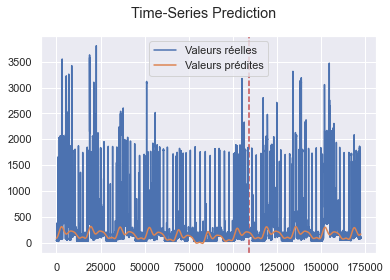

In [35]:
train_size=len(Xtest)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(Xtest,label="Valeurs réelles")
plt.plot(yhat, label="Valeurs prédites")
plt.legend()

plt.suptitle('Time-Series Prediction')
plt.show()

In [33]:
predict=pd.concat([forecasttest['ds'],pd.DataFrame(yhat)],axis=1)

In [34]:
predict.to_csv('prophet.csv',index=False)